In [43]:
import graphviz
import jupyter_black
import matplotlib.pyplot as plt
import numpy as np
import optuna
import pandas as pd
import seaborn as sns
from sklearn.metrics import roc_auc_score, recall_score, precision_score
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.tree import plot_tree, export_graphviz
import xgboost as xgb

jupyter_black.load()

In [44]:
data = pd.read_excel("dataproject2024.xlsx")
data.head()

ID  Job tenure  Age  Car price  Funding amount  Down payment  \
0   1          34   55       4875            3087             0   
1   2           5   29      13000           13000             0   
2   3          14   38      17190           14190             0   
3   4          16   37      22773           23568             0   
4   5           1   61       7700            8526             0   

   Loan duration  Monthly payment  Credit event  Married  Homeowner  \
0             36         0.047895             0        1          1   
1             60         0.091667             0        0          0   
2             60         0.088235             0        0          0   
3             48         0.110084             0        1          1   
4             48         0.123404             0        1          0   

   Default (y)  Pred_default (y_hat)        PD  Group  
0            0                     0  0.024480      1  
1            1                     0  0.331661      0  
2            0                     0  0.187505      0  
3            0                     0  0.035441      1  
4            1                     0  0.340883      0

In [45]:
data.shape

(7430, 15)

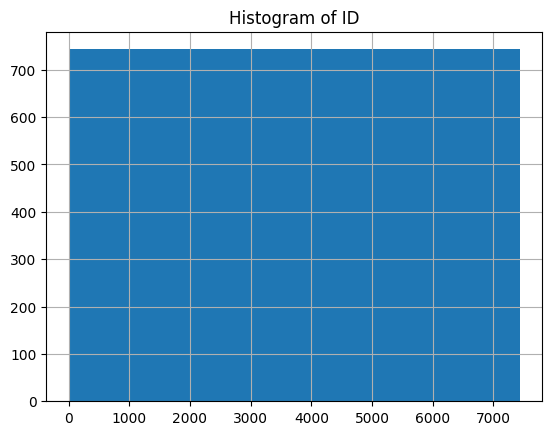

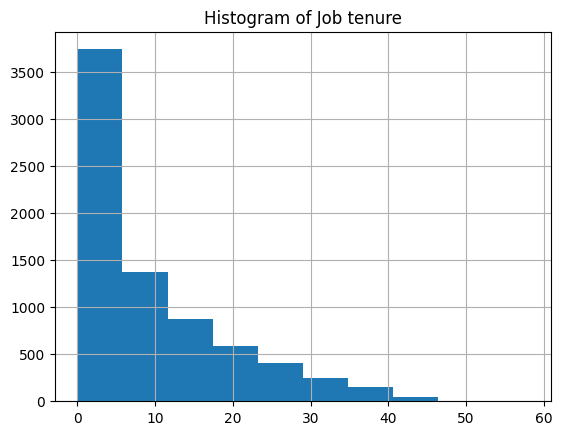

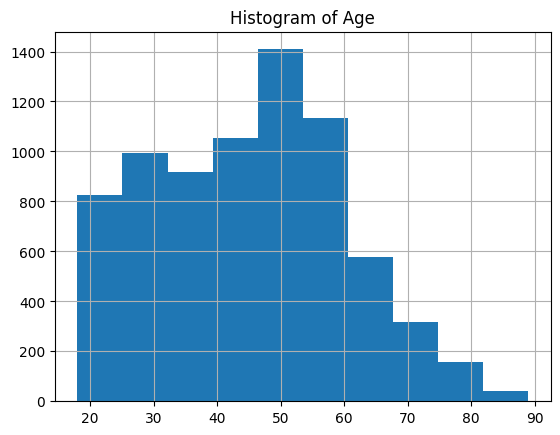

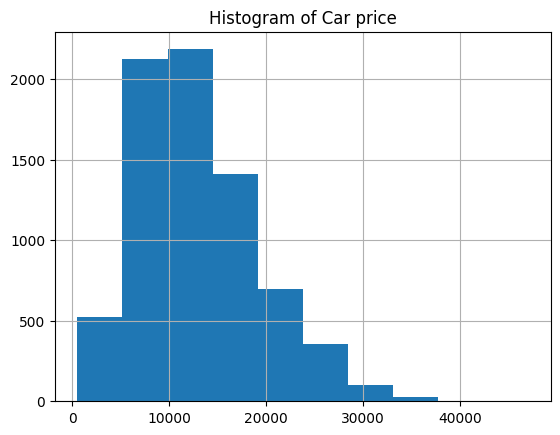

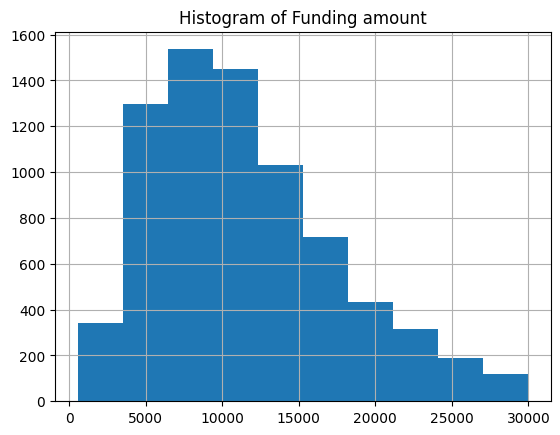

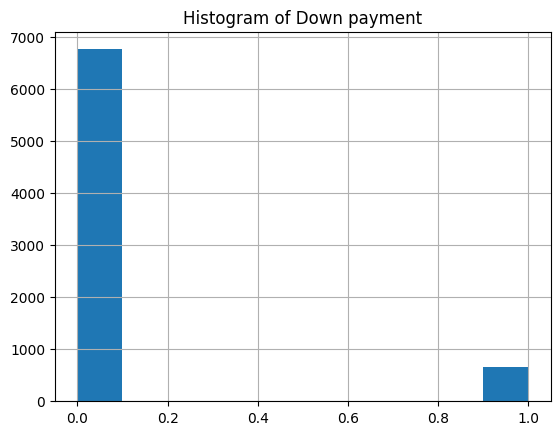

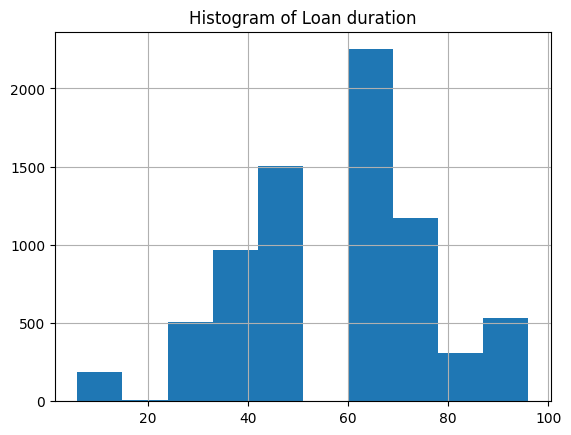

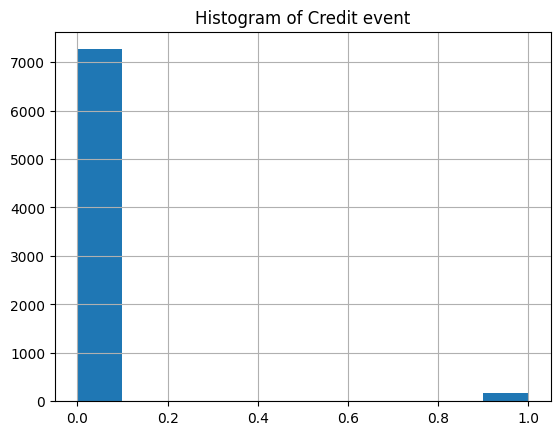

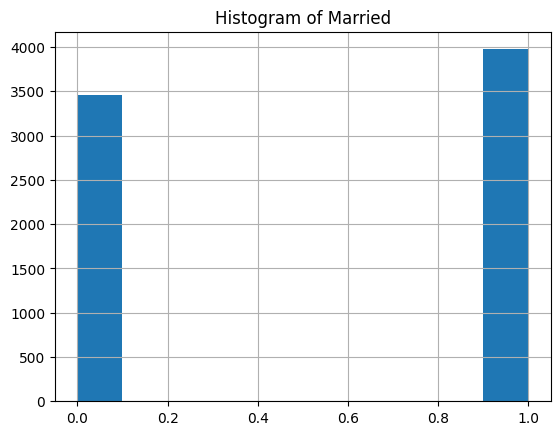

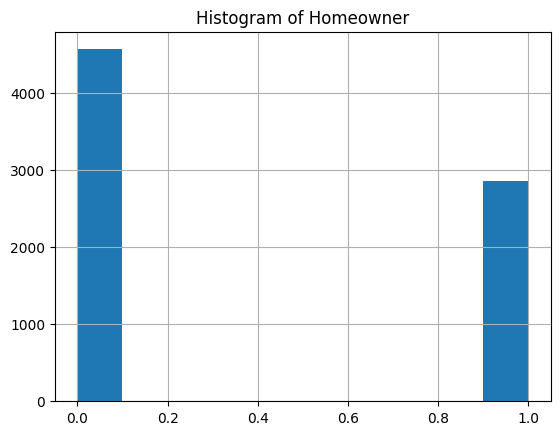

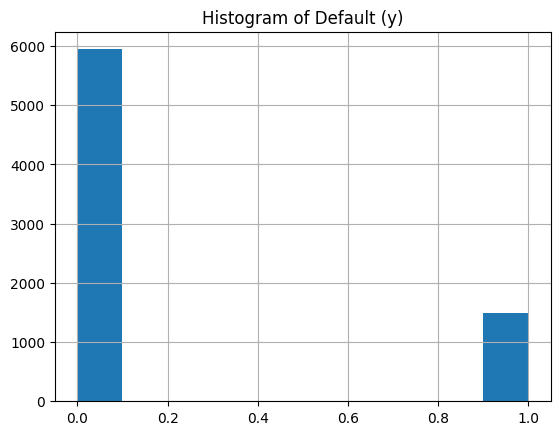

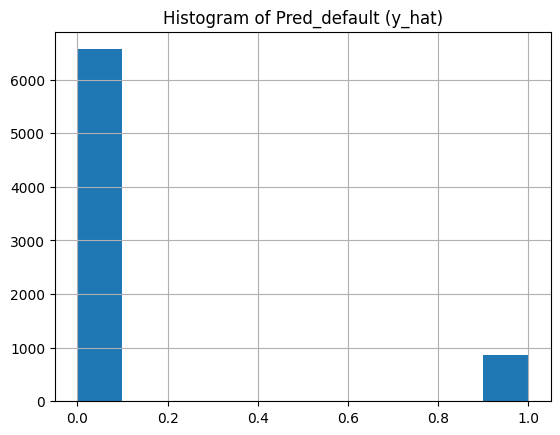

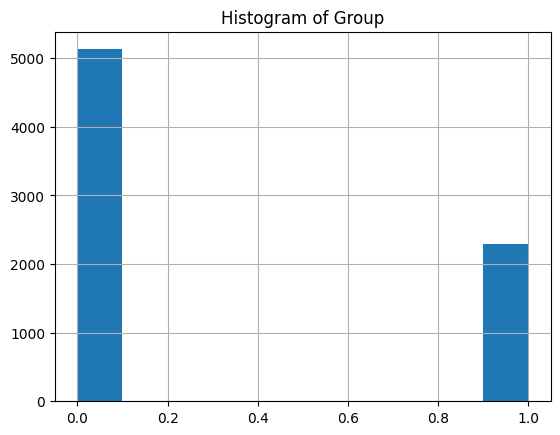

In [46]:
for col in data.select_dtypes(include=int):
    data[col].hist()
    plt.title(f"Histogram of {col}")
    plt.show()

In [47]:
data.columns

Index(['ID', 'Job tenure', 'Age', 'Car price', 'Funding amount',
       'Down payment', 'Loan duration', 'Monthly payment', 'Credit event',
       'Married', 'Homeowner', 'Default (y)', 'Pred_default (y_hat)', 'PD',
       'Group'],
      dtype='object')

In [48]:
# Drop unused features

data = data.drop(columns=["ID", "Pred_default (y_hat)", "PD", "Group"])

X = data.drop(columns="Default (y)")
y = data["Default (y)"]

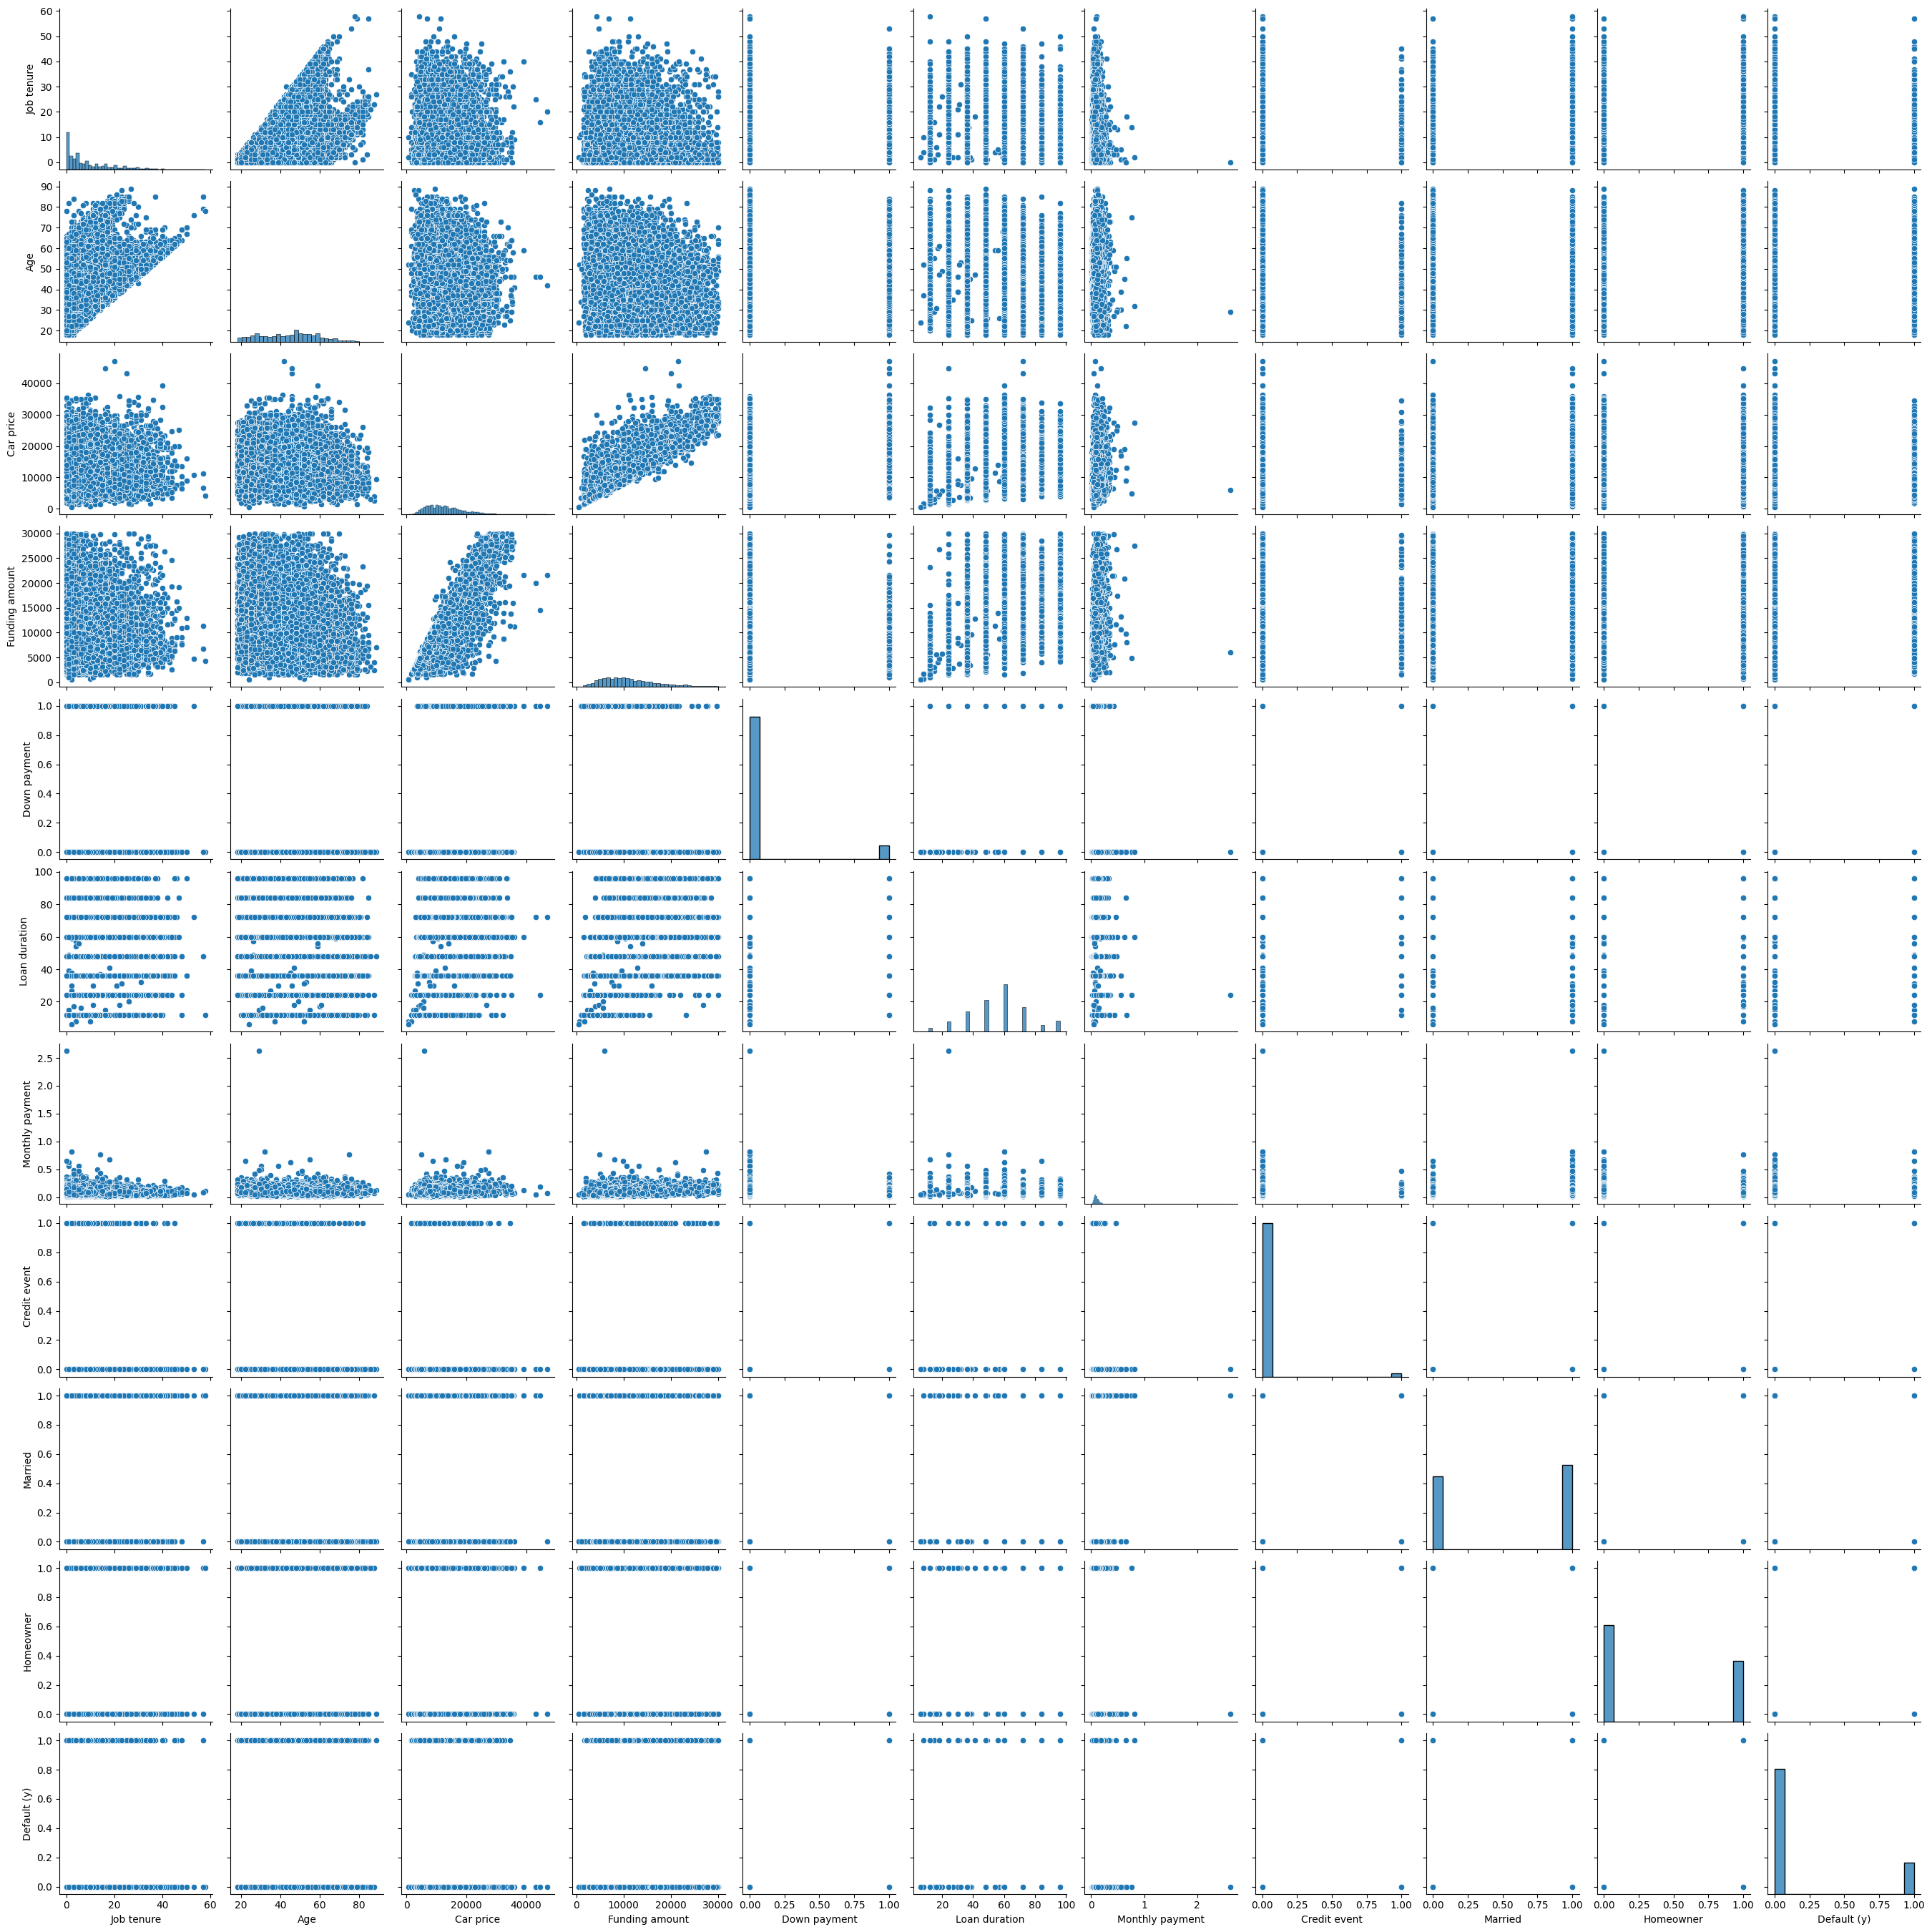

In [49]:
sns.pairplot(data)

# Train a XGB blackbox model

In [50]:
# Classic split between train and test set to fit our model
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)

xgb_clf = xgb.XGBClassifier()
xgb_clf.fit(X_train, y_train)

y_pred = xgb_clf.predict(X_test)
accuracy = xgb_clf.score(X_test, y_test)
auc = roc_auc_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)

print("Accuracy: ", accuracy)
print("AUC: ", auc)
print("Recall (sensitive to false negative): ", recall)
print("Precision (sensitive to false positive): ", precision)

Accuracy:  0.7970936490850377
AUC:  0.6016998811465214
Recall (sensitive to false positive):  0.2809917355371901
Precision (sensitive to false positive):  0.46788990825688076


In [52]:
# Create optuna study


def objective(trial):
    # Hyeprparameter search space
    params = {
        "learning_rate": trial.suggest_loguniform("learning_rate", 0.01, 0.3),
        "n_estimators": trial.suggest_int("n_estimators", 100, 1000),
        "max_depth": trial.suggest_int("max_depth", 3, 9),
    }
    # Train the XGBoost model with the current hyperparameters
    model = xgb.XGBClassifier(**params, use_label_encode=False)
    model.fit(
        X_train,
        y_train,
        eval_set=[(X_test, y_test)],
        verbose=True,
    )
    # Get predictions and evaluate using accuracy
    preds = model.predict(X_test)
    auc = roc_auc_score(y_test, preds)

    return auc


# Uncomment to run optuna study
# study = optuna.create_study(direction="maximize")
# study.optimize(objective, n_trials=100)
# print("Best hyperparameters: ", study.best_params)
# print("Best accuracy: ", study.best_value)

[I 2024-09-25 20:52:30,892] A new study created in memory with name: no-name-d866ce0d-dc98-4d06-a8db-7144a5b1c489


[0]	validation_0-logloss:0.48898
[1]	validation_0-logloss:0.48182
[2]	validation_0-logloss:0.47559
[3]	validation_0-logloss:0.46995
[4]	validation_0-logloss:0.46516
[5]	validation_0-logloss:0.46042
[6]	validation_0-logloss:0.45625
[7]	validation_0-logloss:0.45292
[8]	validation_0-logloss:0.44957
[9]	validation_0-logloss:0.44659


/var/folders/tx/qjhs2lh57lvbn8vn8s5kp38h0000gn/T/ipykernel_33662/2368969516.py:7: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  "learning_rate": trial.suggest_loguniform("learning_rate", 0.01, 0.3),
/Users/alex/Documents/credit_scoring/fairness_venv/lib/python3.11/site-packages/xgboost/core.py:158: UserWarning: [20:52:30] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encode" } are not used.

  warnings.warn(smsg, UserWarning)


[10]	validation_0-logloss:0.44424
[11]	validation_0-logloss:0.44161
[12]	validation_0-logloss:0.43948
[13]	validation_0-logloss:0.43739
[14]	validation_0-logloss:0.43586
[15]	validation_0-logloss:0.43428
[16]	validation_0-logloss:0.43315
[17]	validation_0-logloss:0.43207
[18]	validation_0-logloss:0.43118
[19]	validation_0-logloss:0.43024
[20]	validation_0-logloss:0.42899
[21]	validation_0-logloss:0.42854
[22]	validation_0-logloss:0.42772
[23]	validation_0-logloss:0.42687
[24]	validation_0-logloss:0.42625
[25]	validation_0-logloss:0.42495
[26]	validation_0-logloss:0.42420
[27]	validation_0-logloss:0.42349
[28]	validation_0-logloss:0.42323
[29]	validation_0-logloss:0.42264
[30]	validation_0-logloss:0.42211
[31]	validation_0-logloss:0.42159
[32]	validation_0-logloss:0.42088
[33]	validation_0-logloss:0.42085
[34]	validation_0-logloss:0.42072
[35]	validation_0-logloss:0.42026
[36]	validation_0-logloss:0.41976
[37]	validation_0-logloss:0.41957
[38]	validation_0-logloss:0.41943
[39]	validatio

[I 2024-09-25 20:52:39,802] Trial 0 finished with value: 0.5999484046914878 and parameters: {'learning_rate': 0.06967408183826904, 'n_estimators': 806, 'max_depth': 7}. Best is trial 0 with value: 0.5999484046914878.


[0]	validation_0-logloss:0.47751
[1]	validation_0-logloss:0.46396
[2]	validation_0-logloss:0.45667
[3]	validation_0-logloss:0.44654
[4]	validation_0-logloss:0.43994
[5]	validation_0-logloss:0.43601
[6]	validation_0-logloss:0.43213
[7]	validation_0-logloss:0.42960
[8]	validation_0-logloss:0.42705
[9]	validation_0-logloss:0.42562
[10]	validation_0-logloss:0.42319
[11]	validation_0-logloss:0.41998
[12]	validation_0-logloss:0.41975
[13]	validation_0-logloss:0.41865
[14]	validation_0-logloss:0.41793


/var/folders/tx/qjhs2lh57lvbn8vn8s5kp38h0000gn/T/ipykernel_33662/2368969516.py:7: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  "learning_rate": trial.suggest_loguniform("learning_rate", 0.01, 0.3),
/Users/alex/Documents/credit_scoring/fairness_venv/lib/python3.11/site-packages/xgboost/core.py:158: UserWarning: [20:52:39] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encode" } are not used.

  warnings.warn(smsg, UserWarning)


[15]	validation_0-logloss:0.41804
[16]	validation_0-logloss:0.41809
[17]	validation_0-logloss:0.41698
[18]	validation_0-logloss:0.41591
[19]	validation_0-logloss:0.41576
[20]	validation_0-logloss:0.41539
[21]	validation_0-logloss:0.41523
[22]	validation_0-logloss:0.41607
[23]	validation_0-logloss:0.41530
[24]	validation_0-logloss:0.41505
[25]	validation_0-logloss:0.41433
[26]	validation_0-logloss:0.41385
[27]	validation_0-logloss:0.41358
[28]	validation_0-logloss:0.41375
[29]	validation_0-logloss:0.41413
[30]	validation_0-logloss:0.41399
[31]	validation_0-logloss:0.41356
[32]	validation_0-logloss:0.41405
[33]	validation_0-logloss:0.41335
[34]	validation_0-logloss:0.41379
[35]	validation_0-logloss:0.41374
[36]	validation_0-logloss:0.41438
[37]	validation_0-logloss:0.41473
[38]	validation_0-logloss:0.41472
[39]	validation_0-logloss:0.41464
[40]	validation_0-logloss:0.41468
[41]	validation_0-logloss:0.41608
[42]	validation_0-logloss:0.41634
[43]	validation_0-logloss:0.41621
[44]	validatio

[I 2024-09-25 20:52:48,247] Trial 1 finished with value: 0.6129172540239733 and parameters: {'learning_rate': 0.2970154158937088, 'n_estimators': 955, 'max_depth': 3}. Best is trial 1 with value: 0.6129172540239733.


[0]	validation_0-logloss:0.48901
[1]	validation_0-logloss:0.48165
[2]	validation_0-logloss:0.47532
[3]	validation_0-logloss:0.47002
[4]	validation_0-logloss:0.46517


/var/folders/tx/qjhs2lh57lvbn8vn8s5kp38h0000gn/T/ipykernel_33662/2368969516.py:7: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  "learning_rate": trial.suggest_loguniform("learning_rate", 0.01, 0.3),
/Users/alex/Documents/credit_scoring/fairness_venv/lib/python3.11/site-packages/xgboost/core.py:158: UserWarning: [20:52:48] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encode" } are not used.

  warnings.warn(smsg, UserWarning)


[5]	validation_0-logloss:0.46141
[6]	validation_0-logloss:0.45677
[7]	validation_0-logloss:0.45278
[8]	validation_0-logloss:0.44895
[9]	validation_0-logloss:0.44540
[10]	validation_0-logloss:0.44220
[11]	validation_0-logloss:0.43995
[12]	validation_0-logloss:0.43750
[13]	validation_0-logloss:0.43523
[14]	validation_0-logloss:0.43342
[15]	validation_0-logloss:0.43191
[16]	validation_0-logloss:0.43060
[17]	validation_0-logloss:0.42919
[18]	validation_0-logloss:0.42790
[19]	validation_0-logloss:0.42720
[20]	validation_0-logloss:0.42643
[21]	validation_0-logloss:0.42569
[22]	validation_0-logloss:0.42510
[23]	validation_0-logloss:0.42481
[24]	validation_0-logloss:0.42434
[25]	validation_0-logloss:0.42389
[26]	validation_0-logloss:0.42360
[27]	validation_0-logloss:0.42324
[28]	validation_0-logloss:0.42298
[29]	validation_0-logloss:0.42309
[30]	validation_0-logloss:0.42249
[31]	validation_0-logloss:0.42257
[32]	validation_0-logloss:0.42216
[33]	validation_0-logloss:0.42215
[34]	validation_0-l

[I 2024-09-25 20:52:53,173] Trial 2 finished with value: 0.6040585238213696 and parameters: {'learning_rate': 0.06310168068813907, 'n_estimators': 210, 'max_depth': 9}. Best is trial 1 with value: 0.6129172540239733.


[0]	validation_0-logloss:0.49485
[1]	validation_0-logloss:0.49202


/var/folders/tx/qjhs2lh57lvbn8vn8s5kp38h0000gn/T/ipykernel_33662/2368969516.py:7: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  "learning_rate": trial.suggest_loguniform("learning_rate", 0.01, 0.3),
/Users/alex/Documents/credit_scoring/fairness_venv/lib/python3.11/site-packages/xgboost/core.py:158: UserWarning: [20:52:53] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encode" } are not used.

  warnings.warn(smsg, UserWarning)


[2]	validation_0-logloss:0.48934
[3]	validation_0-logloss:0.48695
[4]	validation_0-logloss:0.48444
[5]	validation_0-logloss:0.48206
[6]	validation_0-logloss:0.47982
[7]	validation_0-logloss:0.47780
[8]	validation_0-logloss:0.47585
[9]	validation_0-logloss:0.47394
[10]	validation_0-logloss:0.47197
[11]	validation_0-logloss:0.47038
[12]	validation_0-logloss:0.46873
[13]	validation_0-logloss:0.46731
[14]	validation_0-logloss:0.46584
[15]	validation_0-logloss:0.46458
[16]	validation_0-logloss:0.46299
[17]	validation_0-logloss:0.46197
[18]	validation_0-logloss:0.46079
[19]	validation_0-logloss:0.45950
[20]	validation_0-logloss:0.45844
[21]	validation_0-logloss:0.45722
[22]	validation_0-logloss:0.45612
[23]	validation_0-logloss:0.45482
[24]	validation_0-logloss:0.45411
[25]	validation_0-logloss:0.45283
[26]	validation_0-logloss:0.45173
[27]	validation_0-logloss:0.45101
[28]	validation_0-logloss:0.45009
[29]	validation_0-logloss:0.44883
[30]	validation_0-logloss:0.44786
[31]	validation_0-logl

[I 2024-09-25 20:52:58,609] Trial 3 finished with value: 0.6031915383694039 and parameters: {'learning_rate': 0.038042155633863144, 'n_estimators': 532, 'max_depth': 3}. Best is trial 1 with value: 0.6129172540239733.


[0]	validation_0-logloss:0.49619
[1]	validation_0-logloss:0.49454
[2]	validation_0-logloss:0.49296
[3]	validation_0-logloss:0.49147
[4]	validation_0-logloss:0.48998
[5]	validation_0-logloss:0.48856
[6]	validation_0-logloss:0.48720
[7]	validation_0-logloss:0.48583
[8]	validation_0-logloss:0.48445
[9]	validation_0-logloss:0.48328
[10]	validation_0-logloss:0.48188
[11]	validation_0-logloss:0.48061
[12]	validation_0-logloss:0.47937
[13]	validation_0-logloss:0.47819
[14]	validation_0-logloss:0.47711
[15]	validation_0-logloss:0.47607
[16]	validation_0-logloss:0.47499


/var/folders/tx/qjhs2lh57lvbn8vn8s5kp38h0000gn/T/ipykernel_33662/2368969516.py:7: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  "learning_rate": trial.suggest_loguniform("learning_rate", 0.01, 0.3),
/Users/alex/Documents/credit_scoring/fairness_venv/lib/python3.11/site-packages/xgboost/core.py:158: UserWarning: [20:52:58] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encode" } are not used.

  warnings.warn(smsg, UserWarning)


[17]	validation_0-logloss:0.47397
[18]	validation_0-logloss:0.47297
[19]	validation_0-logloss:0.47206
[20]	validation_0-logloss:0.47105
[21]	validation_0-logloss:0.47019
[22]	validation_0-logloss:0.46928
[23]	validation_0-logloss:0.46847
[24]	validation_0-logloss:0.46768
[25]	validation_0-logloss:0.46687
[26]	validation_0-logloss:0.46615
[27]	validation_0-logloss:0.46547
[28]	validation_0-logloss:0.46450
[29]	validation_0-logloss:0.46381
[30]	validation_0-logloss:0.46317
[31]	validation_0-logloss:0.46239
[32]	validation_0-logloss:0.46179
[33]	validation_0-logloss:0.46109
[34]	validation_0-logloss:0.46028
[35]	validation_0-logloss:0.45968
[36]	validation_0-logloss:0.45896
[37]	validation_0-logloss:0.45850
[38]	validation_0-logloss:0.45775
[39]	validation_0-logloss:0.45726
[40]	validation_0-logloss:0.45658
[41]	validation_0-logloss:0.45587
[42]	validation_0-logloss:0.45523
[43]	validation_0-logloss:0.45480
[44]	validation_0-logloss:0.45414
[45]	validation_0-logloss:0.45340
[46]	validatio

[I 2024-09-25 20:53:00,093] Trial 4 finished with value: 0.5463215309065111 and parameters: {'learning_rate': 0.02120932022445854, 'n_estimators': 144, 'max_depth': 3}. Best is trial 1 with value: 0.6129172540239733.


[0]	validation_0-logloss:0.49644
[1]	validation_0-logloss:0.49502
[2]	validation_0-logloss:0.49361
[3]	validation_0-logloss:0.49226
[4]	validation_0-logloss:0.49094
[5]	validation_0-logloss:0.48966
[6]	validation_0-logloss:0.48843
[7]	validation_0-logloss:0.48721
[8]	validation_0-logloss:0.48605
[9]	validation_0-logloss:0.48490


/var/folders/tx/qjhs2lh57lvbn8vn8s5kp38h0000gn/T/ipykernel_33662/2368969516.py:7: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  "learning_rate": trial.suggest_loguniform("learning_rate", 0.01, 0.3),
/Users/alex/Documents/credit_scoring/fairness_venv/lib/python3.11/site-packages/xgboost/core.py:158: UserWarning: [20:53:00] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encode" } are not used.

  warnings.warn(smsg, UserWarning)


[10]	validation_0-logloss:0.48378
[11]	validation_0-logloss:0.48268
[12]	validation_0-logloss:0.48165
[13]	validation_0-logloss:0.48065
[14]	validation_0-logloss:0.47963
[15]	validation_0-logloss:0.47871
[16]	validation_0-logloss:0.47767
[17]	validation_0-logloss:0.47669
[18]	validation_0-logloss:0.47572
[19]	validation_0-logloss:0.47479
[20]	validation_0-logloss:0.47387
[21]	validation_0-logloss:0.47299
[22]	validation_0-logloss:0.47210
[23]	validation_0-logloss:0.47123
[24]	validation_0-logloss:0.47039
[25]	validation_0-logloss:0.46962
[26]	validation_0-logloss:0.46882
[27]	validation_0-logloss:0.46806
[28]	validation_0-logloss:0.46726
[29]	validation_0-logloss:0.46651
[30]	validation_0-logloss:0.46577
[31]	validation_0-logloss:0.46510
[32]	validation_0-logloss:0.46447
[33]	validation_0-logloss:0.46379
[34]	validation_0-logloss:0.46311
[35]	validation_0-logloss:0.46246
[36]	validation_0-logloss:0.46183
[37]	validation_0-logloss:0.46117
[38]	validation_0-logloss:0.46053
[39]	validatio

[I 2024-09-25 20:53:10,753] Trial 5 finished with value: 0.5997678211116947 and parameters: {'learning_rate': 0.012951215217833335, 'n_estimators': 724, 'max_depth': 5}. Best is trial 1 with value: 0.6129172540239733.


[0]	validation_0-logloss:0.49609
[1]	validation_0-logloss:0.49431
[2]	validation_0-logloss:0.49262
[3]	validation_0-logloss:0.49101
[4]	validation_0-logloss:0.48945
[5]	validation_0-logloss:0.48794
[6]	validation_0-logloss:0.48648
[7]	validation_0-logloss:0.48513
[8]	validation_0-logloss:0.48376
[9]	validation_0-logloss:0.48240
[10]	validation_0-logloss:0.48110
[11]	validation_0-logloss:0.47982
[12]	validation_0-logloss:0.47856
[13]	validation_0-logloss:0.47731
[14]	validation_0-logloss:0.47611
[15]	validation_0-logloss:0.47500
[16]	validation_0-logloss:0.47388
[17]	validation_0-logloss:0.47276
[18]	validation_0-logloss:0.47163


/var/folders/tx/qjhs2lh57lvbn8vn8s5kp38h0000gn/T/ipykernel_33662/2368969516.py:7: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  "learning_rate": trial.suggest_loguniform("learning_rate", 0.01, 0.3),
/Users/alex/Documents/credit_scoring/fairness_venv/lib/python3.11/site-packages/xgboost/core.py:158: UserWarning: [20:53:10] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encode" } are not used.

  warnings.warn(smsg, UserWarning)


[19]	validation_0-logloss:0.47065
[20]	validation_0-logloss:0.46971
[21]	validation_0-logloss:0.46879
[22]	validation_0-logloss:0.46784
[23]	validation_0-logloss:0.46700
[24]	validation_0-logloss:0.46616
[25]	validation_0-logloss:0.46527
[26]	validation_0-logloss:0.46442
[27]	validation_0-logloss:0.46360
[28]	validation_0-logloss:0.46281
[29]	validation_0-logloss:0.46206
[30]	validation_0-logloss:0.46108
[31]	validation_0-logloss:0.46014
[32]	validation_0-logloss:0.45925
[33]	validation_0-logloss:0.45837
[34]	validation_0-logloss:0.45749
[35]	validation_0-logloss:0.45667
[36]	validation_0-logloss:0.45576
[37]	validation_0-logloss:0.45495
[38]	validation_0-logloss:0.45410
[39]	validation_0-logloss:0.45325
[40]	validation_0-logloss:0.45247
[41]	validation_0-logloss:0.45174
[42]	validation_0-logloss:0.45099
[43]	validation_0-logloss:0.45029
[44]	validation_0-logloss:0.44956
[45]	validation_0-logloss:0.44885
[46]	validation_0-logloss:0.44815
[47]	validation_0-logloss:0.44742
[48]	validatio

[I 2024-09-25 20:53:12,458] Trial 6 finished with value: 0.5595455927471737 and parameters: {'learning_rate': 0.012499884162531965, 'n_estimators': 141, 'max_depth': 9}. Best is trial 1 with value: 0.6129172540239733.


[0]	validation_0-logloss:0.49335
[1]	validation_0-logloss:0.48923
[2]	validation_0-logloss:0.48554
[3]	validation_0-logloss:0.48209
[4]	validation_0-logloss:0.47863
[5]	validation_0-logloss:0.47549
[6]	validation_0-logloss:0.47253
[7]	validation_0-logloss:0.46992
[8]	validation_0-logloss:0.46746
[9]	validation_0-logloss:0.46509
[10]	validation_0-logloss:0.46234
[11]	validation_0-logloss:0.45980
[12]	validation_0-logloss:0.45755
[13]	validation_0-logloss:0.45534
[14]	validation_0-logloss:0.45331
[15]	validation_0-logloss:0.45146
[16]	validation_0-logloss:0.44956
[17]	validation_0-logloss:0.44799
[18]	validation_0-logloss:0.44644
[19]	validation_0-logloss:0.44494
[20]	validation_0-logloss:0.44347
[21]	validation_0-logloss:0.44212
[22]	validation_0-logloss:0.44062
[23]	validation_0-logloss:0.43931


/var/folders/tx/qjhs2lh57lvbn8vn8s5kp38h0000gn/T/ipykernel_33662/2368969516.py:7: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  "learning_rate": trial.suggest_loguniform("learning_rate", 0.01, 0.3),
/Users/alex/Documents/credit_scoring/fairness_venv/lib/python3.11/site-packages/xgboost/core.py:158: UserWarning: [20:53:12] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encode" } are not used.

  warnings.warn(smsg, UserWarning)


[24]	validation_0-logloss:0.43830
[25]	validation_0-logloss:0.43717
[26]	validation_0-logloss:0.43624
[27]	validation_0-logloss:0.43542
[28]	validation_0-logloss:0.43456
[29]	validation_0-logloss:0.43363
[30]	validation_0-logloss:0.43286
[31]	validation_0-logloss:0.43204
[32]	validation_0-logloss:0.43116
[33]	validation_0-logloss:0.43054
[34]	validation_0-logloss:0.43016
[35]	validation_0-logloss:0.42946
[36]	validation_0-logloss:0.42885
[37]	validation_0-logloss:0.42831
[38]	validation_0-logloss:0.42778
[39]	validation_0-logloss:0.42737
[40]	validation_0-logloss:0.42695
[41]	validation_0-logloss:0.42653
[42]	validation_0-logloss:0.42596
[43]	validation_0-logloss:0.42560
[44]	validation_0-logloss:0.42510
[45]	validation_0-logloss:0.42486
[46]	validation_0-logloss:0.42445
[47]	validation_0-logloss:0.42389
[48]	validation_0-logloss:0.42358
[49]	validation_0-logloss:0.42309
[50]	validation_0-logloss:0.42283
[51]	validation_0-logloss:0.42257
[52]	validation_0-logloss:0.42218
[53]	validatio

[I 2024-09-25 20:53:14,783] Trial 7 finished with value: 0.6020122170319798 and parameters: {'learning_rate': 0.033744365785476675, 'n_estimators': 239, 'max_depth': 8}. Best is trial 1 with value: 0.6129172540239733.


[0]	validation_0-logloss:0.47565
[1]	validation_0-logloss:0.46144
[2]	validation_0-logloss:0.45009
[3]	validation_0-logloss:0.44157
[4]	validation_0-logloss:0.43665
[5]	validation_0-logloss:0.43241
[6]	validation_0-logloss:0.42938
[7]	validation_0-logloss:0.42850
[8]	validation_0-logloss:0.42717
[9]	validation_0-logloss:0.42617
[10]	validation_0-logloss:0.42560
[11]	validation_0-logloss:0.42464
[12]	validation_0-logloss:0.42430
[13]	validation_0-logloss:0.42340
[14]	validation_0-logloss:0.42400
[15]	validation_0-logloss:0.42529
[16]	validation_0-logloss:0.42531
[17]	validation_0-logloss:0.42501
[18]	validation_0-logloss:0.42546
[19]	validation_0-logloss:0.42605
[20]	validation_0-logloss:0.42699
[21]	validation_0-logloss:0.42687
[22]	validation_0-logloss:0.42733
[23]	validation_0-logloss:0.42870
[24]	validation_0-logloss:0.42824
[25]	validation_0-logloss:0.42830


/var/folders/tx/qjhs2lh57lvbn8vn8s5kp38h0000gn/T/ipykernel_33662/2368969516.py:7: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  "learning_rate": trial.suggest_loguniform("learning_rate", 0.01, 0.3),
/Users/alex/Documents/credit_scoring/fairness_venv/lib/python3.11/site-packages/xgboost/core.py:158: UserWarning: [20:53:14] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encode" } are not used.

  warnings.warn(smsg, UserWarning)


[26]	validation_0-logloss:0.42878
[27]	validation_0-logloss:0.42919
[28]	validation_0-logloss:0.42909
[29]	validation_0-logloss:0.43025
[30]	validation_0-logloss:0.43071
[31]	validation_0-logloss:0.43121
[32]	validation_0-logloss:0.43180
[33]	validation_0-logloss:0.43186
[34]	validation_0-logloss:0.43189
[35]	validation_0-logloss:0.43217
[36]	validation_0-logloss:0.43312
[37]	validation_0-logloss:0.43424
[38]	validation_0-logloss:0.43427
[39]	validation_0-logloss:0.43411
[40]	validation_0-logloss:0.43454
[41]	validation_0-logloss:0.43509
[42]	validation_0-logloss:0.43606
[43]	validation_0-logloss:0.43673
[44]	validation_0-logloss:0.43676
[45]	validation_0-logloss:0.43824
[46]	validation_0-logloss:0.43889
[47]	validation_0-logloss:0.43804
[48]	validation_0-logloss:0.43875
[49]	validation_0-logloss:0.43879
[50]	validation_0-logloss:0.43883
[51]	validation_0-logloss:0.43956
[52]	validation_0-logloss:0.43986
[53]	validation_0-logloss:0.44013
[54]	validation_0-logloss:0.44073
[55]	validatio

[I 2024-09-25 20:53:16,572] Trial 8 finished with value: 0.610338409943153 and parameters: {'learning_rate': 0.18543176805604117, 'n_estimators': 207, 'max_depth': 8}. Best is trial 1 with value: 0.6129172540239733.


[0]	validation_0-logloss:0.49670
[1]	validation_0-logloss:0.49553
[2]	validation_0-logloss:0.49436
[3]	validation_0-logloss:0.49322


/var/folders/tx/qjhs2lh57lvbn8vn8s5kp38h0000gn/T/ipykernel_33662/2368969516.py:7: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  "learning_rate": trial.suggest_loguniform("learning_rate", 0.01, 0.3),
/Users/alex/Documents/credit_scoring/fairness_venv/lib/python3.11/site-packages/xgboost/core.py:158: UserWarning: [20:53:16] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encode" } are not used.

  warnings.warn(smsg, UserWarning)


[4]	validation_0-logloss:0.49211
[5]	validation_0-logloss:0.49102
[6]	validation_0-logloss:0.48998
[7]	validation_0-logloss:0.48894
[8]	validation_0-logloss:0.48792
[9]	validation_0-logloss:0.48694
[10]	validation_0-logloss:0.48596
[11]	validation_0-logloss:0.48503
[12]	validation_0-logloss:0.48409
[13]	validation_0-logloss:0.48319
[14]	validation_0-logloss:0.48228
[15]	validation_0-logloss:0.48148
[16]	validation_0-logloss:0.48061
[17]	validation_0-logloss:0.47984
[18]	validation_0-logloss:0.47902
[19]	validation_0-logloss:0.47821
[20]	validation_0-logloss:0.47746
[21]	validation_0-logloss:0.47665
[22]	validation_0-logloss:0.47585
[23]	validation_0-logloss:0.47508
[24]	validation_0-logloss:0.47432
[25]	validation_0-logloss:0.47358
[26]	validation_0-logloss:0.47286
[27]	validation_0-logloss:0.47212
[28]	validation_0-logloss:0.47143
[29]	validation_0-logloss:0.47074
[30]	validation_0-logloss:0.47006
[31]	validation_0-logloss:0.46937
[32]	validation_0-logloss:0.46876
[33]	validation_0-lo

[I 2024-09-25 20:53:23,115] Trial 9 finished with value: 0.5897914996729225 and parameters: {'learning_rate': 0.010692362996907352, 'n_estimators': 960, 'max_depth': 5}. Best is trial 1 with value: 0.6129172540239733.


[0]	validation_0-logloss:0.47067
[1]	validation_0-logloss:0.45635
[2]	validation_0-logloss:0.44631
[3]	validation_0-logloss:0.43929
[4]	validation_0-logloss:0.43433
[5]	validation_0-logloss:0.42843
[6]	validation_0-logloss:0.42424
[7]	validation_0-logloss:0.42156
[8]	validation_0-logloss:0.41912
[9]	validation_0-logloss:0.41567
[10]	validation_0-logloss:0.41661
[11]	validation_0-logloss:0.41578
[12]	validation_0-logloss:0.41509
[13]	validation_0-logloss:0.41401
[14]	validation_0-logloss:0.41348
[15]	validation_0-logloss:0.41236
[16]	validation_0-logloss:0.41263
[17]	validation_0-logloss:0.41308


/var/folders/tx/qjhs2lh57lvbn8vn8s5kp38h0000gn/T/ipykernel_33662/2368969516.py:7: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  "learning_rate": trial.suggest_loguniform("learning_rate", 0.01, 0.3),
/Users/alex/Documents/credit_scoring/fairness_venv/lib/python3.11/site-packages/xgboost/core.py:158: UserWarning: [20:53:23] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encode" } are not used.

  warnings.warn(smsg, UserWarning)


[18]	validation_0-logloss:0.41309
[19]	validation_0-logloss:0.41259
[20]	validation_0-logloss:0.41376
[21]	validation_0-logloss:0.41368
[22]	validation_0-logloss:0.41407
[23]	validation_0-logloss:0.41427
[24]	validation_0-logloss:0.41451
[25]	validation_0-logloss:0.41525
[26]	validation_0-logloss:0.41661
[27]	validation_0-logloss:0.41718
[28]	validation_0-logloss:0.41785
[29]	validation_0-logloss:0.41700
[30]	validation_0-logloss:0.41717
[31]	validation_0-logloss:0.41630
[32]	validation_0-logloss:0.41794
[33]	validation_0-logloss:0.41799
[34]	validation_0-logloss:0.41802
[35]	validation_0-logloss:0.41766
[36]	validation_0-logloss:0.41943
[37]	validation_0-logloss:0.41910
[38]	validation_0-logloss:0.41984
[39]	validation_0-logloss:0.42049
[40]	validation_0-logloss:0.42039
[41]	validation_0-logloss:0.42042
[42]	validation_0-logloss:0.42051
[43]	validation_0-logloss:0.42148
[44]	validation_0-logloss:0.42119
[45]	validation_0-logloss:0.42207
[46]	validation_0-logloss:0.42392
[47]	validatio

[I 2024-09-25 20:53:25,475] Trial 10 finished with value: 0.6058717303776593 and parameters: {'learning_rate': 0.2830531092131389, 'n_estimators': 483, 'max_depth': 5}. Best is trial 1 with value: 0.6129172540239733.


[0]	validation_0-logloss:0.46656
[1]	validation_0-logloss:0.44879
[2]	validation_0-logloss:0.43871
[3]	validation_0-logloss:0.43179
[4]	validation_0-logloss:0.42733
[5]	validation_0-logloss:0.42366
[6]	validation_0-logloss:0.42256
[7]	validation_0-logloss:0.42161
[8]	validation_0-logloss:0.42115
[9]	validation_0-logloss:0.42150
[10]	validation_0-logloss:0.42077
[11]	validation_0-logloss:0.42088
[12]	validation_0-logloss:0.42101
[13]	validation_0-logloss:0.42086
[14]	validation_0-logloss:0.42155
[15]	validation_0-logloss:0.42164
[16]	validation_0-logloss:0.42231
[17]	validation_0-logloss:0.42299
[18]	validation_0-logloss:0.42364
[19]	validation_0-logloss:0.42452
[20]	validation_0-logloss:0.42412
[21]	validation_0-logloss:0.42483
[22]	validation_0-logloss:0.42450
[23]	validation_0-logloss:0.42483
[24]	validation_0-logloss:0.42458
[25]	validation_0-logloss:0.42627
[26]	validation_0-logloss:0.42690
[27]	validation_0-logloss:0.42801
[28]	validation_0-logloss:0.42897


/var/folders/tx/qjhs2lh57lvbn8vn8s5kp38h0000gn/T/ipykernel_33662/2368969516.py:7: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  "learning_rate": trial.suggest_loguniform("learning_rate", 0.01, 0.3),
/Users/alex/Documents/credit_scoring/fairness_venv/lib/python3.11/site-packages/xgboost/core.py:158: UserWarning: [20:53:25] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encode" } are not used.

  warnings.warn(smsg, UserWarning)


[29]	validation_0-logloss:0.43063
[30]	validation_0-logloss:0.43054
[31]	validation_0-logloss:0.43135
[32]	validation_0-logloss:0.43144
[33]	validation_0-logloss:0.43166
[34]	validation_0-logloss:0.43208
[35]	validation_0-logloss:0.43257
[36]	validation_0-logloss:0.43452
[37]	validation_0-logloss:0.43625
[38]	validation_0-logloss:0.43651
[39]	validation_0-logloss:0.43629
[40]	validation_0-logloss:0.43650
[41]	validation_0-logloss:0.43718
[42]	validation_0-logloss:0.43739
[43]	validation_0-logloss:0.43858
[44]	validation_0-logloss:0.43991
[45]	validation_0-logloss:0.43991
[46]	validation_0-logloss:0.44008
[47]	validation_0-logloss:0.44037
[48]	validation_0-logloss:0.44164
[49]	validation_0-logloss:0.44302
[50]	validation_0-logloss:0.44327
[51]	validation_0-logloss:0.44529
[52]	validation_0-logloss:0.44704
[53]	validation_0-logloss:0.44737
[54]	validation_0-logloss:0.44773
[55]	validation_0-logloss:0.44736
[56]	validation_0-logloss:0.44692
[57]	validation_0-logloss:0.44650
[58]	validatio

[I 2024-09-25 20:53:27,519] Trial 11 finished with value: 0.5930834646249665 and parameters: {'learning_rate': 0.28996650623927933, 'n_estimators': 373, 'max_depth': 7}. Best is trial 1 with value: 0.6129172540239733.


[0]	validation_0-logloss:0.48079
[1]	validation_0-logloss:0.46819
[2]	validation_0-logloss:0.45855
[3]	validation_0-logloss:0.45063
[4]	validation_0-logloss:0.44466
[5]	validation_0-logloss:0.43989
[6]	validation_0-logloss:0.43711
[7]	validation_0-logloss:0.43396
[8]	validation_0-logloss:0.43208
[9]	validation_0-logloss:0.42962
[10]	validation_0-logloss:0.42770
[11]	validation_0-logloss:0.42588
[12]	validation_0-logloss:0.42421
[13]	validation_0-logloss:0.42298
[14]	validation_0-logloss:0.42267
[15]	validation_0-logloss:0.42148
[16]	validation_0-logloss:0.42042
[17]	validation_0-logloss:0.42054
[18]	validation_0-logloss:0.41983
[19]	validation_0-logloss:0.41925
[20]	validation_0-logloss:0.41947
[21]	validation_0-logloss:0.41980
[22]	validation_0-logloss:0.41952
[23]	validation_0-logloss:0.41966
[24]	validation_0-logloss:0.41946
[25]	validation_0-logloss:0.41962
[26]	validation_0-logloss:0.41954
[27]	validation_0-logloss:0.41967
[28]	validation_0-logloss:0.41941
[29]	validation_0-loglos

/var/folders/tx/qjhs2lh57lvbn8vn8s5kp38h0000gn/T/ipykernel_33662/2368969516.py:7: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  "learning_rate": trial.suggest_loguniform("learning_rate", 0.01, 0.3),
/Users/alex/Documents/credit_scoring/fairness_venv/lib/python3.11/site-packages/xgboost/core.py:158: UserWarning: [20:53:27] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encode" } are not used.

  warnings.warn(smsg, UserWarning)


[31]	validation_0-logloss:0.42011
[32]	validation_0-logloss:0.42026
[33]	validation_0-logloss:0.42065
[34]	validation_0-logloss:0.42115
[35]	validation_0-logloss:0.42127
[36]	validation_0-logloss:0.42081
[37]	validation_0-logloss:0.42127
[38]	validation_0-logloss:0.42167
[39]	validation_0-logloss:0.42182
[40]	validation_0-logloss:0.42234
[41]	validation_0-logloss:0.42207
[42]	validation_0-logloss:0.42275
[43]	validation_0-logloss:0.42298
[44]	validation_0-logloss:0.42347
[45]	validation_0-logloss:0.42383
[46]	validation_0-logloss:0.42397
[47]	validation_0-logloss:0.42456
[48]	validation_0-logloss:0.42453
[49]	validation_0-logloss:0.42510
[50]	validation_0-logloss:0.42572
[51]	validation_0-logloss:0.42615
[52]	validation_0-logloss:0.42644
[53]	validation_0-logloss:0.42676
[54]	validation_0-logloss:0.42706
[55]	validation_0-logloss:0.42636
[56]	validation_0-logloss:0.42630
[57]	validation_0-logloss:0.42701
[58]	validation_0-logloss:0.42720
[59]	validation_0-logloss:0.42773
[60]	validatio

[I 2024-09-25 20:53:31,241] Trial 12 finished with value: 0.6075835890065139 and parameters: {'learning_rate': 0.15098977086909654, 'n_estimators': 700, 'max_depth': 6}. Best is trial 1 with value: 0.6129172540239733.


[0]	validation_0-logloss:0.48464
[1]	validation_0-logloss:0.47443
[2]	validation_0-logloss:0.46603
[3]	validation_0-logloss:0.45995
[4]	validation_0-logloss:0.45508
[5]	validation_0-logloss:0.45136
[6]	validation_0-logloss:0.44630
[7]	validation_0-logloss:0.44256
[8]	validation_0-logloss:0.43993
[9]	validation_0-logloss:0.43646
[10]	validation_0-logloss:0.43423
[11]	validation_0-logloss:0.43165
[12]	validation_0-logloss:0.43014
[13]	validation_0-logloss:0.42886
[14]	validation_0-logloss:0.42734
[15]	validation_0-logloss:0.42628
[16]	validation_0-logloss:0.42577
[17]	validation_0-logloss:0.42384
[18]	validation_0-logloss:0.42270
[19]	validation_0-logloss:0.42192
[20]	validation_0-logloss:0.42120
[21]	validation_0-logloss:0.42030
[22]	validation_0-logloss:0.42011
[23]	validation_0-logloss:0.41931
[24]	validation_0-logloss:0.41854
[25]	validation_0-logloss:0.41795
[26]	validation_0-logloss:0.41742
[27]	validation_0-logloss:0.41758
[28]	validation_0-logloss:0.41735
[29]	validation_0-loglos

/var/folders/tx/qjhs2lh57lvbn8vn8s5kp38h0000gn/T/ipykernel_33662/2368969516.py:7: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  "learning_rate": trial.suggest_loguniform("learning_rate", 0.01, 0.3),
/Users/alex/Documents/credit_scoring/fairness_venv/lib/python3.11/site-packages/xgboost/core.py:158: UserWarning: [20:53:31] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encode" } are not used.

  warnings.warn(smsg, UserWarning)


[33]	validation_0-logloss:0.41714
[34]	validation_0-logloss:0.41722
[35]	validation_0-logloss:0.41749
[36]	validation_0-logloss:0.41716
[37]	validation_0-logloss:0.41668
[38]	validation_0-logloss:0.41667
[39]	validation_0-logloss:0.41640
[40]	validation_0-logloss:0.41618
[41]	validation_0-logloss:0.41646
[42]	validation_0-logloss:0.41699
[43]	validation_0-logloss:0.41659
[44]	validation_0-logloss:0.41696
[45]	validation_0-logloss:0.41669
[46]	validation_0-logloss:0.41654
[47]	validation_0-logloss:0.41656
[48]	validation_0-logloss:0.41646
[49]	validation_0-logloss:0.41642
[50]	validation_0-logloss:0.41641
[51]	validation_0-logloss:0.41670
[52]	validation_0-logloss:0.41690
[53]	validation_0-logloss:0.41686
[54]	validation_0-logloss:0.41680
[55]	validation_0-logloss:0.41713
[56]	validation_0-logloss:0.41724
[57]	validation_0-logloss:0.41745
[58]	validation_0-logloss:0.41719
[59]	validation_0-logloss:0.41684
[60]	validation_0-logloss:0.41689
[61]	validation_0-logloss:0.41713
[62]	validatio

[I 2024-09-25 20:53:35,576] Trial 13 finished with value: 0.5987294655278844 and parameters: {'learning_rate': 0.14344998231387965, 'n_estimators': 975, 'max_depth': 4}. Best is trial 1 with value: 0.6129172540239733.


[0]	validation_0-logloss:0.48130
[1]	validation_0-logloss:0.46957
[2]	validation_0-logloss:0.46016
[3]	validation_0-logloss:0.45203
[4]	validation_0-logloss:0.44672
[5]	validation_0-logloss:0.44116
[6]	validation_0-logloss:0.43706
[7]	validation_0-logloss:0.43417
[8]	validation_0-logloss:0.43110
[9]	validation_0-logloss:0.42853
[10]	validation_0-logloss:0.42744
[11]	validation_0-logloss:0.42489
[12]	validation_0-logloss:0.42322
[13]	validation_0-logloss:0.42108
[14]	validation_0-logloss:0.42034
[15]	validation_0-logloss:0.42012
[16]	validation_0-logloss:0.41969
[17]	validation_0-logloss:0.41958
[18]	validation_0-logloss:0.41943
[19]	validation_0-logloss:0.41914
[20]	validation_0-logloss:0.41817
[21]	validation_0-logloss:0.41829
[22]	validation_0-logloss:0.41890
[23]	validation_0-logloss:0.41850
[24]	validation_0-logloss:0.41829
[25]	validation_0-logloss:0.41871
[26]	validation_0-logloss:0.41820


/var/folders/tx/qjhs2lh57lvbn8vn8s5kp38h0000gn/T/ipykernel_33662/2368969516.py:7: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  "learning_rate": trial.suggest_loguniform("learning_rate", 0.01, 0.3),
/Users/alex/Documents/credit_scoring/fairness_venv/lib/python3.11/site-packages/xgboost/core.py:158: UserWarning: [20:53:35] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encode" } are not used.

  warnings.warn(smsg, UserWarning)


[27]	validation_0-logloss:0.41834
[28]	validation_0-logloss:0.41804
[29]	validation_0-logloss:0.41816
[30]	validation_0-logloss:0.41854
[31]	validation_0-logloss:0.41848
[32]	validation_0-logloss:0.41847
[33]	validation_0-logloss:0.41912
[34]	validation_0-logloss:0.41958
[35]	validation_0-logloss:0.41968
[36]	validation_0-logloss:0.41941
[37]	validation_0-logloss:0.42035
[38]	validation_0-logloss:0.42051
[39]	validation_0-logloss:0.42063
[40]	validation_0-logloss:0.42063
[41]	validation_0-logloss:0.42118
[42]	validation_0-logloss:0.42082
[43]	validation_0-logloss:0.42129
[44]	validation_0-logloss:0.42178
[45]	validation_0-logloss:0.42214
[46]	validation_0-logloss:0.42236
[47]	validation_0-logloss:0.42281
[48]	validation_0-logloss:0.42338
[49]	validation_0-logloss:0.42453
[50]	validation_0-logloss:0.42455
[51]	validation_0-logloss:0.42475
[52]	validation_0-logloss:0.42506
[53]	validation_0-logloss:0.42569
[54]	validation_0-logloss:0.42587
[55]	validation_0-logloss:0.42611
[56]	validatio

[I 2024-09-25 20:53:37,301] Trial 14 finished with value: 0.6096298957959038 and parameters: {'learning_rate': 0.13579026755213672, 'n_estimators': 366, 'max_depth': 7}. Best is trial 1 with value: 0.6129172540239733.


[0]	validation_0-logloss:0.47334
[1]	validation_0-logloss:0.45916
[2]	validation_0-logloss:0.44772
[3]	validation_0-logloss:0.43845
[4]	validation_0-logloss:0.43256
[5]	validation_0-logloss:0.42774
[6]	validation_0-logloss:0.42574
[7]	validation_0-logloss:0.42390
[8]	validation_0-logloss:0.42191
[9]	validation_0-logloss:0.42221
[10]	validation_0-logloss:0.42248
[11]	validation_0-logloss:0.42066
[12]	validation_0-logloss:0.42043
[13]	validation_0-logloss:0.42034
[14]	validation_0-logloss:0.41895
[15]	validation_0-logloss:0.41922
[16]	validation_0-logloss:0.41986
[17]	validation_0-logloss:0.42090
[18]	validation_0-logloss:0.42125
[19]	validation_0-logloss:0.42161
[20]	validation_0-logloss:0.42215
[21]	validation_0-logloss:0.42402
[22]	validation_0-logloss:0.42435
[23]	validation_0-logloss:0.42488
[24]	validation_0-logloss:0.42482
[25]	validation_0-logloss:0.42478
[26]	validation_0-logloss:0.42495


/var/folders/tx/qjhs2lh57lvbn8vn8s5kp38h0000gn/T/ipykernel_33662/2368969516.py:7: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  "learning_rate": trial.suggest_loguniform("learning_rate", 0.01, 0.3),
/Users/alex/Documents/credit_scoring/fairness_venv/lib/python3.11/site-packages/xgboost/core.py:158: UserWarning: [20:53:37] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encode" } are not used.

  warnings.warn(smsg, UserWarning)


[27]	validation_0-logloss:0.42554
[28]	validation_0-logloss:0.42598
[29]	validation_0-logloss:0.42616
[30]	validation_0-logloss:0.42738
[31]	validation_0-logloss:0.42763
[32]	validation_0-logloss:0.42789
[33]	validation_0-logloss:0.42821
[34]	validation_0-logloss:0.42944
[35]	validation_0-logloss:0.43021
[36]	validation_0-logloss:0.43198
[37]	validation_0-logloss:0.43259
[38]	validation_0-logloss:0.43255
[39]	validation_0-logloss:0.43303
[40]	validation_0-logloss:0.43459
[41]	validation_0-logloss:0.43497
[42]	validation_0-logloss:0.43502
[43]	validation_0-logloss:0.43568
[44]	validation_0-logloss:0.43610
[45]	validation_0-logloss:0.43715
[46]	validation_0-logloss:0.43747
[47]	validation_0-logloss:0.43844
[48]	validation_0-logloss:0.43899
[49]	validation_0-logloss:0.43970
[50]	validation_0-logloss:0.43891
[51]	validation_0-logloss:0.43976
[52]	validation_0-logloss:0.44017
[53]	validation_0-logloss:0.44087
[54]	validation_0-logloss:0.44100
[55]	validation_0-logloss:0.44179
[56]	validatio

[I 2024-09-25 20:53:41,917] Trial 15 finished with value: 0.6026857200770245 and parameters: {'learning_rate': 0.2089264069658465, 'n_estimators': 834, 'max_depth': 8}. Best is trial 1 with value: 0.6129172540239733.


[0]	validation_0-logloss:0.48869
[1]	validation_0-logloss:0.48146
[2]	validation_0-logloss:0.47484
[3]	validation_0-logloss:0.46920
[4]	validation_0-logloss:0.46492
[5]	validation_0-logloss:0.46070
[6]	validation_0-logloss:0.45680
[7]	validation_0-logloss:0.45377
[8]	validation_0-logloss:0.45129
[9]	validation_0-logloss:0.44855
[10]	validation_0-logloss:0.44685
[11]	validation_0-logloss:0.44366
[12]	validation_0-logloss:0.44143
[13]	validation_0-logloss:0.44049
[14]	validation_0-logloss:0.43849
[15]	validation_0-logloss:0.43700
[16]	validation_0-logloss:0.43546
[17]	validation_0-logloss:0.43380
[18]	validation_0-logloss:0.43326
[19]	validation_0-logloss:0.43165
[20]	validation_0-logloss:0.43065
[21]	validation_0-logloss:0.42988
[22]	validation_0-logloss:0.42875
[23]	validation_0-logloss:0.42845
[24]	validation_0-logloss:0.42781
[25]	validation_0-logloss:0.42681
[26]	validation_0-logloss:0.42635
[27]	validation_0-logloss:0.42619
[28]	validation_0-logloss:0.42488
[29]	validation_0-loglos

/var/folders/tx/qjhs2lh57lvbn8vn8s5kp38h0000gn/T/ipykernel_33662/2368969516.py:7: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  "learning_rate": trial.suggest_loguniform("learning_rate", 0.01, 0.3),
/Users/alex/Documents/credit_scoring/fairness_venv/lib/python3.11/site-packages/xgboost/core.py:158: UserWarning: [20:53:41] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encode" } are not used.

  warnings.warn(smsg, UserWarning)


[32]	validation_0-logloss:0.42264
[33]	validation_0-logloss:0.42233
[34]	validation_0-logloss:0.42197
[35]	validation_0-logloss:0.42149
[36]	validation_0-logloss:0.42118
[37]	validation_0-logloss:0.42133
[38]	validation_0-logloss:0.42132
[39]	validation_0-logloss:0.42091
[40]	validation_0-logloss:0.42042
[41]	validation_0-logloss:0.42042
[42]	validation_0-logloss:0.42040
[43]	validation_0-logloss:0.42036
[44]	validation_0-logloss:0.42007
[45]	validation_0-logloss:0.41976
[46]	validation_0-logloss:0.41967
[47]	validation_0-logloss:0.41937
[48]	validation_0-logloss:0.41938
[49]	validation_0-logloss:0.41922
[50]	validation_0-logloss:0.41894
[51]	validation_0-logloss:0.41915
[52]	validation_0-logloss:0.41860
[53]	validation_0-logloss:0.41852
[54]	validation_0-logloss:0.41861
[55]	validation_0-logloss:0.41872
[56]	validation_0-logloss:0.41864
[57]	validation_0-logloss:0.41876
[58]	validation_0-logloss:0.41879
[59]	validation_0-logloss:0.41833
[60]	validation_0-logloss:0.41828
[61]	validatio

[I 2024-09-25 20:53:44,689] Trial 16 finished with value: 0.5967006642895971 and parameters: {'learning_rate': 0.09698069544737131, 'n_estimators': 659, 'max_depth': 4}. Best is trial 1 with value: 0.6129172540239733.


[0]	validation_0-logloss:0.47548
[1]	validation_0-logloss:0.46212
[2]	validation_0-logloss:0.45081
[3]	validation_0-logloss:0.44303
[4]	validation_0-logloss:0.43846
[5]	validation_0-logloss:0.43434
[6]	validation_0-logloss:0.42968
[7]	validation_0-logloss:0.42827
[8]	validation_0-logloss:0.42495
[9]	validation_0-logloss:0.42341
[10]	validation_0-logloss:0.42245
[11]	validation_0-logloss:0.42085
[12]	validation_0-logloss:0.41938
[13]	validation_0-logloss:0.41857
[14]	validation_0-logloss:0.41773
[15]	validation_0-logloss:0.41751
[16]	validation_0-logloss:0.41786
[17]	validation_0-logloss:0.41774
[18]	validation_0-logloss:0.41867
[19]	validation_0-logloss:0.41901
[20]	validation_0-logloss:0.41901
[21]	validation_0-logloss:0.41915
[22]	validation_0-logloss:0.41901
[23]	validation_0-logloss:0.41901
[24]	validation_0-logloss:0.41900
[25]	validation_0-logloss:0.41970
[26]	validation_0-logloss:0.41989
[27]	validation_0-logloss:0.42123
[28]	validation_0-logloss:0.42185
[29]	validation_0-loglos

/var/folders/tx/qjhs2lh57lvbn8vn8s5kp38h0000gn/T/ipykernel_33662/2368969516.py:7: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  "learning_rate": trial.suggest_loguniform("learning_rate", 0.01, 0.3),
/Users/alex/Documents/credit_scoring/fairness_venv/lib/python3.11/site-packages/xgboost/core.py:158: UserWarning: [20:53:44] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encode" } are not used.

  warnings.warn(smsg, UserWarning)


[30]	validation_0-logloss:0.42271
[31]	validation_0-logloss:0.42279
[32]	validation_0-logloss:0.42391
[33]	validation_0-logloss:0.42349
[34]	validation_0-logloss:0.42416
[35]	validation_0-logloss:0.42437
[36]	validation_0-logloss:0.42449
[37]	validation_0-logloss:0.42468
[38]	validation_0-logloss:0.42531
[39]	validation_0-logloss:0.42558
[40]	validation_0-logloss:0.42646
[41]	validation_0-logloss:0.42763
[42]	validation_0-logloss:0.42789
[43]	validation_0-logloss:0.42806
[44]	validation_0-logloss:0.42847
[45]	validation_0-logloss:0.42937
[46]	validation_0-logloss:0.42912
[47]	validation_0-logloss:0.42939
[48]	validation_0-logloss:0.42965
[49]	validation_0-logloss:0.43034
[50]	validation_0-logloss:0.43059
[51]	validation_0-logloss:0.43030
[52]	validation_0-logloss:0.43081
[53]	validation_0-logloss:0.43097
[54]	validation_0-logloss:0.43166
[55]	validation_0-logloss:0.43228
[56]	validation_0-logloss:0.43206
[57]	validation_0-logloss:0.43236
[58]	validation_0-logloss:0.43335
[59]	validatio

[I 2024-09-25 20:53:46,191] Trial 17 finished with value: 0.6092558298091895 and parameters: {'learning_rate': 0.20555827110287328, 'n_estimators': 334, 'max_depth': 6}. Best is trial 1 with value: 0.6129172540239733.


[0]	validation_0-logloss:0.48553
[1]	validation_0-logloss:0.47579
[2]	validation_0-logloss:0.46763
[3]	validation_0-logloss:0.46074
[4]	validation_0-logloss:0.45416
[5]	validation_0-logloss:0.44873
[6]	validation_0-logloss:0.44456
[7]	validation_0-logloss:0.44080
[8]	validation_0-logloss:0.43765
[9]	validation_0-logloss:0.43528
[10]	validation_0-logloss:0.43276
[11]	validation_0-logloss:0.43085
[12]	validation_0-logloss:0.42936
[13]	validation_0-logloss:0.42815
[14]	validation_0-logloss:0.42714
[15]	validation_0-logloss:0.42682
[16]	validation_0-logloss:0.42525
[17]	validation_0-logloss:0.42434
[18]	validation_0-logloss:0.42280
[19]	validation_0-logloss:0.42257
[20]	validation_0-logloss:0.42203
[21]	validation_0-logloss:0.42188
[22]	validation_0-logloss:0.42176
[23]	validation_0-logloss:0.42131


/var/folders/tx/qjhs2lh57lvbn8vn8s5kp38h0000gn/T/ipykernel_33662/2368969516.py:7: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  "learning_rate": trial.suggest_loguniform("learning_rate", 0.01, 0.3),
/Users/alex/Documents/credit_scoring/fairness_venv/lib/python3.11/site-packages/xgboost/core.py:158: UserWarning: [20:53:46] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encode" } are not used.

  warnings.warn(smsg, UserWarning)


[24]	validation_0-logloss:0.42078
[25]	validation_0-logloss:0.42080
[26]	validation_0-logloss:0.42093
[27]	validation_0-logloss:0.42075
[28]	validation_0-logloss:0.42086
[29]	validation_0-logloss:0.42087
[30]	validation_0-logloss:0.42072
[31]	validation_0-logloss:0.42081
[32]	validation_0-logloss:0.42070
[33]	validation_0-logloss:0.42108
[34]	validation_0-logloss:0.42113
[35]	validation_0-logloss:0.42140
[36]	validation_0-logloss:0.42105
[37]	validation_0-logloss:0.42141
[38]	validation_0-logloss:0.42182
[39]	validation_0-logloss:0.42185
[40]	validation_0-logloss:0.42149
[41]	validation_0-logloss:0.42197
[42]	validation_0-logloss:0.42205
[43]	validation_0-logloss:0.42257
[44]	validation_0-logloss:0.42272
[45]	validation_0-logloss:0.42322
[46]	validation_0-logloss:0.42382
[47]	validation_0-logloss:0.42389
[48]	validation_0-logloss:0.42428
[49]	validation_0-logloss:0.42443
[50]	validation_0-logloss:0.42486
[51]	validation_0-logloss:0.42487
[52]	validation_0-logloss:0.42541
[53]	validatio

[I 2024-09-25 20:53:50,517] Trial 18 finished with value: 0.6123847167325428 and parameters: {'learning_rate': 0.09575134002342346, 'n_estimators': 613, 'max_depth': 8}. Best is trial 1 with value: 0.6129172540239733.


[0]	validation_0-logloss:0.48688
[1]	validation_0-logloss:0.47783
[2]	validation_0-logloss:0.47060
[3]	validation_0-logloss:0.46392
[4]	validation_0-logloss:0.45825
[5]	validation_0-logloss:0.45360
[6]	validation_0-logloss:0.44956
[7]	validation_0-logloss:0.44625
[8]	validation_0-logloss:0.44300
[9]	validation_0-logloss:0.44020
[10]	validation_0-logloss:0.43803
[11]	validation_0-logloss:0.43628
[12]	validation_0-logloss:0.43460
[13]	validation_0-logloss:0.43264
[14]	validation_0-logloss:0.43186
[15]	validation_0-logloss:0.42973
[16]	validation_0-logloss:0.42955
[17]	validation_0-logloss:0.42849
[18]	validation_0-logloss:0.42689
[19]	validation_0-logloss:0.42623
[20]	validation_0-logloss:0.42490
[21]	validation_0-logloss:0.42404
[22]	validation_0-logloss:0.42290
[23]	validation_0-logloss:0.42212
[24]	validation_0-logloss:0.42165
[25]	validation_0-logloss:0.42143


/var/folders/tx/qjhs2lh57lvbn8vn8s5kp38h0000gn/T/ipykernel_33662/2368969516.py:7: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  "learning_rate": trial.suggest_loguniform("learning_rate", 0.01, 0.3),
/Users/alex/Documents/credit_scoring/fairness_venv/lib/python3.11/site-packages/xgboost/core.py:158: UserWarning: [20:53:50] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encode" } are not used.

  warnings.warn(smsg, UserWarning)


[26]	validation_0-logloss:0.42106
[27]	validation_0-logloss:0.42096
[28]	validation_0-logloss:0.42023
[29]	validation_0-logloss:0.42008
[30]	validation_0-logloss:0.42032
[31]	validation_0-logloss:0.41961
[32]	validation_0-logloss:0.41978
[33]	validation_0-logloss:0.41957
[34]	validation_0-logloss:0.41962
[35]	validation_0-logloss:0.41946
[36]	validation_0-logloss:0.41894
[37]	validation_0-logloss:0.41879
[38]	validation_0-logloss:0.41872
[39]	validation_0-logloss:0.41827
[40]	validation_0-logloss:0.41797
[41]	validation_0-logloss:0.41804
[42]	validation_0-logloss:0.41826
[43]	validation_0-logloss:0.41824
[44]	validation_0-logloss:0.41781
[45]	validation_0-logloss:0.41759
[46]	validation_0-logloss:0.41759
[47]	validation_0-logloss:0.41770
[48]	validation_0-logloss:0.41734
[49]	validation_0-logloss:0.41713
[50]	validation_0-logloss:0.41692
[51]	validation_0-logloss:0.41696
[52]	validation_0-logloss:0.41716
[53]	validation_0-logloss:0.41741
[54]	validation_0-logloss:0.41733
[55]	validatio

[I 2024-09-25 20:53:55,179] Trial 19 finished with value: 0.6071699051936206 and parameters: {'learning_rate': 0.09364604822181874, 'n_estimators': 880, 'max_depth': 6}. Best is trial 1 with value: 0.6129172540239733.


[0]	validation_0-logloss:0.49340
[1]	validation_0-logloss:0.48942
[2]	validation_0-logloss:0.48580
[3]	validation_0-logloss:0.48231
[4]	validation_0-logloss:0.47887
[5]	validation_0-logloss:0.47595
[6]	validation_0-logloss:0.47311
[7]	validation_0-logloss:0.47040


/var/folders/tx/qjhs2lh57lvbn8vn8s5kp38h0000gn/T/ipykernel_33662/2368969516.py:7: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  "learning_rate": trial.suggest_loguniform("learning_rate", 0.01, 0.3),
/Users/alex/Documents/credit_scoring/fairness_venv/lib/python3.11/site-packages/xgboost/core.py:158: UserWarning: [20:53:55] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encode" } are not used.

  warnings.warn(smsg, UserWarning)


[8]	validation_0-logloss:0.46825
[9]	validation_0-logloss:0.46585
[10]	validation_0-logloss:0.46370
[11]	validation_0-logloss:0.46176
[12]	validation_0-logloss:0.46001
[13]	validation_0-logloss:0.45827
[14]	validation_0-logloss:0.45682
[15]	validation_0-logloss:0.45546
[16]	validation_0-logloss:0.45398
[17]	validation_0-logloss:0.45280
[18]	validation_0-logloss:0.45127
[19]	validation_0-logloss:0.45027
[20]	validation_0-logloss:0.44851
[21]	validation_0-logloss:0.44728
[22]	validation_0-logloss:0.44625
[23]	validation_0-logloss:0.44480
[24]	validation_0-logloss:0.44402
[25]	validation_0-logloss:0.44275
[26]	validation_0-logloss:0.44180
[27]	validation_0-logloss:0.44068
[28]	validation_0-logloss:0.44018
[29]	validation_0-logloss:0.43915
[30]	validation_0-logloss:0.43824
[31]	validation_0-logloss:0.43754
[32]	validation_0-logloss:0.43648
[33]	validation_0-logloss:0.43592
[34]	validation_0-logloss:0.43509
[35]	validation_0-logloss:0.43439
[36]	validation_0-logloss:0.43404
[37]	validation_

[I 2024-09-25 20:53:57,924] Trial 20 finished with value: 0.5961285091719875 and parameters: {'learning_rate': 0.04615611576879441, 'n_estimators': 603, 'max_depth': 4}. Best is trial 1 with value: 0.6129172540239733.


[0]	validation_0-logloss:0.47405
[1]	validation_0-logloss:0.46000
[2]	validation_0-logloss:0.44822
[3]	validation_0-logloss:0.43940
[4]	validation_0-logloss:0.43472
[5]	validation_0-logloss:0.43000
[6]	validation_0-logloss:0.42824
[7]	validation_0-logloss:0.42566
[8]	validation_0-logloss:0.42461
[9]	validation_0-logloss:0.42390
[10]	validation_0-logloss:0.42344
[11]	validation_0-logloss:0.42287
[12]	validation_0-logloss:0.42267


/var/folders/tx/qjhs2lh57lvbn8vn8s5kp38h0000gn/T/ipykernel_33662/2368969516.py:7: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  "learning_rate": trial.suggest_loguniform("learning_rate", 0.01, 0.3),
/Users/alex/Documents/credit_scoring/fairness_venv/lib/python3.11/site-packages/xgboost/core.py:158: UserWarning: [20:53:58] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encode" } are not used.

  warnings.warn(smsg, UserWarning)


[13]	validation_0-logloss:0.42158
[14]	validation_0-logloss:0.42131
[15]	validation_0-logloss:0.42088
[16]	validation_0-logloss:0.42246
[17]	validation_0-logloss:0.42333
[18]	validation_0-logloss:0.42337
[19]	validation_0-logloss:0.42468
[20]	validation_0-logloss:0.42620
[21]	validation_0-logloss:0.42773
[22]	validation_0-logloss:0.42771
[23]	validation_0-logloss:0.42851
[24]	validation_0-logloss:0.42937
[25]	validation_0-logloss:0.43064
[26]	validation_0-logloss:0.43067
[27]	validation_0-logloss:0.43073
[28]	validation_0-logloss:0.43115
[29]	validation_0-logloss:0.43168
[30]	validation_0-logloss:0.43293
[31]	validation_0-logloss:0.43337
[32]	validation_0-logloss:0.43333
[33]	validation_0-logloss:0.43457
[34]	validation_0-logloss:0.43588
[35]	validation_0-logloss:0.43596
[36]	validation_0-logloss:0.43652
[37]	validation_0-logloss:0.43578
[38]	validation_0-logloss:0.43592
[39]	validation_0-logloss:0.43637
[40]	validation_0-logloss:0.43728
[41]	validation_0-logloss:0.43771
[42]	validatio

[I 2024-09-25 20:54:00,554] Trial 21 finished with value: 0.6029805504113804 and parameters: {'learning_rate': 0.20160184102905054, 'n_estimators': 452, 'max_depth': 8}. Best is trial 1 with value: 0.6129172540239733.


[0]	validation_0-logloss:0.48423
[1]	validation_0-logloss:0.47412
[2]	validation_0-logloss:0.46548
[3]	validation_0-logloss:0.45884
[4]	validation_0-logloss:0.45244
[5]	validation_0-logloss:0.44616
[6]	validation_0-logloss:0.44162
[7]	validation_0-logloss:0.43744
[8]	validation_0-logloss:0.43449
[9]	validation_0-logloss:0.43158
[10]	validation_0-logloss:0.42906
[11]	validation_0-logloss:0.42723
[12]	validation_0-logloss:0.42583
[13]	validation_0-logloss:0.42456
[14]	validation_0-logloss:0.42339
[15]	validation_0-logloss:0.42276
[16]	validation_0-logloss:0.42110


/var/folders/tx/qjhs2lh57lvbn8vn8s5kp38h0000gn/T/ipykernel_33662/2368969516.py:7: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  "learning_rate": trial.suggest_loguniform("learning_rate", 0.01, 0.3),
/Users/alex/Documents/credit_scoring/fairness_venv/lib/python3.11/site-packages/xgboost/core.py:158: UserWarning: [20:54:00] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encode" } are not used.

  warnings.warn(smsg, UserWarning)


[17]	validation_0-logloss:0.41979
[18]	validation_0-logloss:0.41943
[19]	validation_0-logloss:0.41945
[20]	validation_0-logloss:0.41911
[21]	validation_0-logloss:0.41936
[22]	validation_0-logloss:0.41871
[23]	validation_0-logloss:0.41895
[24]	validation_0-logloss:0.41857
[25]	validation_0-logloss:0.41866
[26]	validation_0-logloss:0.41831
[27]	validation_0-logloss:0.41834
[28]	validation_0-logloss:0.41838
[29]	validation_0-logloss:0.41861
[30]	validation_0-logloss:0.41883
[31]	validation_0-logloss:0.41935
[32]	validation_0-logloss:0.41890
[33]	validation_0-logloss:0.41877
[34]	validation_0-logloss:0.41898
[35]	validation_0-logloss:0.41952
[36]	validation_0-logloss:0.42027
[37]	validation_0-logloss:0.42090
[38]	validation_0-logloss:0.42115
[39]	validation_0-logloss:0.42159
[40]	validation_0-logloss:0.42154
[41]	validation_0-logloss:0.42176
[42]	validation_0-logloss:0.42215
[43]	validation_0-logloss:0.42249
[44]	validation_0-logloss:0.42256
[45]	validation_0-logloss:0.42350
[46]	validatio

[I 2024-09-25 20:54:04,908] Trial 22 finished with value: 0.6042787252273417 and parameters: {'learning_rate': 0.09992489545021496, 'n_estimators': 773, 'max_depth': 9}. Best is trial 1 with value: 0.6129172540239733.


[0]	validation_0-logloss:0.47663
[1]	validation_0-logloss:0.46292
[2]	validation_0-logloss:0.45212
[3]	validation_0-logloss:0.44462
[4]	validation_0-logloss:0.43924
[5]	validation_0-logloss:0.43400
[6]	validation_0-logloss:0.43111
[7]	validation_0-logloss:0.42815
[8]	validation_0-logloss:0.42580
[9]	validation_0-logloss:0.42431
[10]	validation_0-logloss:0.42311
[11]	validation_0-logloss:0.42201
[12]	validation_0-logloss:0.42137
[13]	validation_0-logloss:0.42041
[14]	validation_0-logloss:0.42027
[15]	validation_0-logloss:0.41872
[16]	validation_0-logloss:0.41963
[17]	validation_0-logloss:0.42024


/var/folders/tx/qjhs2lh57lvbn8vn8s5kp38h0000gn/T/ipykernel_33662/2368969516.py:7: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  "learning_rate": trial.suggest_loguniform("learning_rate", 0.01, 0.3),
/Users/alex/Documents/credit_scoring/fairness_venv/lib/python3.11/site-packages/xgboost/core.py:158: UserWarning: [20:54:04] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encode" } are not used.

  warnings.warn(smsg, UserWarning)


[18]	validation_0-logloss:0.42074
[19]	validation_0-logloss:0.42065
[20]	validation_0-logloss:0.42029
[21]	validation_0-logloss:0.42122
[22]	validation_0-logloss:0.42135
[23]	validation_0-logloss:0.42246
[24]	validation_0-logloss:0.42318
[25]	validation_0-logloss:0.42326
[26]	validation_0-logloss:0.42352
[27]	validation_0-logloss:0.42391
[28]	validation_0-logloss:0.42325
[29]	validation_0-logloss:0.42337
[30]	validation_0-logloss:0.42440
[31]	validation_0-logloss:0.42474
[32]	validation_0-logloss:0.42469
[33]	validation_0-logloss:0.42465
[34]	validation_0-logloss:0.42620
[35]	validation_0-logloss:0.42724
[36]	validation_0-logloss:0.42746
[37]	validation_0-logloss:0.42883
[38]	validation_0-logloss:0.42904
[39]	validation_0-logloss:0.42918
[40]	validation_0-logloss:0.42965
[41]	validation_0-logloss:0.42984
[42]	validation_0-logloss:0.43030
[43]	validation_0-logloss:0.43121
[44]	validation_0-logloss:0.43201
[45]	validation_0-logloss:0.43238
[46]	validation_0-logloss:0.43245
[47]	validatio

[I 2024-09-25 20:54:08,717] Trial 23 finished with value: 0.6023116540903102 and parameters: {'learning_rate': 0.1757972186205314, 'n_estimators': 594, 'max_depth': 8}. Best is trial 1 with value: 0.6129172540239733.


[0]	validation_0-logloss:0.48342
[1]	validation_0-logloss:0.47272
[2]	validation_0-logloss:0.46436
[3]	validation_0-logloss:0.45662
[4]	validation_0-logloss:0.45017
[5]	validation_0-logloss:0.44586
[6]	validation_0-logloss:0.44129
[7]	validation_0-logloss:0.43790
[8]	validation_0-logloss:0.43534
[9]	validation_0-logloss:0.43249
[10]	validation_0-logloss:0.43049
[11]	validation_0-logloss:0.42879
[12]	validation_0-logloss:0.42597
[13]	validation_0-logloss:0.42544
[14]	validation_0-logloss:0.42392
[15]	validation_0-logloss:0.42256
[16]	validation_0-logloss:0.42091
[17]	validation_0-logloss:0.42081
[18]	validation_0-logloss:0.42039
[19]	validation_0-logloss:0.41966
[20]	validation_0-logloss:0.41862
[21]	validation_0-logloss:0.41788


/var/folders/tx/qjhs2lh57lvbn8vn8s5kp38h0000gn/T/ipykernel_33662/2368969516.py:7: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  "learning_rate": trial.suggest_loguniform("learning_rate", 0.01, 0.3),
/Users/alex/Documents/credit_scoring/fairness_venv/lib/python3.11/site-packages/xgboost/core.py:158: UserWarning: [20:54:08] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encode" } are not used.

  warnings.warn(smsg, UserWarning)


[22]	validation_0-logloss:0.41790
[23]	validation_0-logloss:0.41804
[24]	validation_0-logloss:0.41821
[25]	validation_0-logloss:0.41794
[26]	validation_0-logloss:0.41842
[27]	validation_0-logloss:0.41845
[28]	validation_0-logloss:0.41842
[29]	validation_0-logloss:0.41893
[30]	validation_0-logloss:0.41887
[31]	validation_0-logloss:0.41929
[32]	validation_0-logloss:0.41941
[33]	validation_0-logloss:0.41900
[34]	validation_0-logloss:0.41904
[35]	validation_0-logloss:0.41922
[36]	validation_0-logloss:0.41916
[37]	validation_0-logloss:0.41910
[38]	validation_0-logloss:0.41978
[39]	validation_0-logloss:0.41970
[40]	validation_0-logloss:0.41950
[41]	validation_0-logloss:0.41996
[42]	validation_0-logloss:0.42025
[43]	validation_0-logloss:0.42085
[44]	validation_0-logloss:0.42063
[45]	validation_0-logloss:0.42072
[46]	validation_0-logloss:0.42121
[47]	validation_0-logloss:0.42164
[48]	validation_0-logloss:0.42176
[49]	validation_0-logloss:0.42216
[50]	validation_0-logloss:0.42224
[51]	validatio

[I 2024-09-25 20:54:13,575] Trial 24 finished with value: 0.6059905838561965 and parameters: {'learning_rate': 0.11684692101298501, 'n_estimators': 896, 'max_depth': 7}. Best is trial 1 with value: 0.6129172540239733.


[0]	validation_0-logloss:0.47012
[1]	validation_0-logloss:0.45518
[2]	validation_0-logloss:0.44474
[3]	validation_0-logloss:0.43697
[4]	validation_0-logloss:0.43168
[5]	validation_0-logloss:0.42790
[6]	validation_0-logloss:0.42609
[7]	validation_0-logloss:0.42449
[8]	validation_0-logloss:0.42465
[9]	validation_0-logloss:0.42225
[10]	validation_0-logloss:0.42315
[11]	validation_0-logloss:0.42332
[12]	validation_0-logloss:0.42331
[13]	validation_0-logloss:0.42334
[14]	validation_0-logloss:0.42499
[15]	validation_0-logloss:0.42588
[16]	validation_0-logloss:0.42666
[17]	validation_0-logloss:0.42927
[18]	validation_0-logloss:0.43091


/var/folders/tx/qjhs2lh57lvbn8vn8s5kp38h0000gn/T/ipykernel_33662/2368969516.py:7: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  "learning_rate": trial.suggest_loguniform("learning_rate", 0.01, 0.3),
/Users/alex/Documents/credit_scoring/fairness_venv/lib/python3.11/site-packages/xgboost/core.py:158: UserWarning: [20:54:13] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encode" } are not used.

  warnings.warn(smsg, UserWarning)


[19]	validation_0-logloss:0.43075
[20]	validation_0-logloss:0.43069
[21]	validation_0-logloss:0.43198
[22]	validation_0-logloss:0.43271
[23]	validation_0-logloss:0.43299
[24]	validation_0-logloss:0.43323
[25]	validation_0-logloss:0.43285
[26]	validation_0-logloss:0.43422
[27]	validation_0-logloss:0.43507
[28]	validation_0-logloss:0.43579
[29]	validation_0-logloss:0.43671
[30]	validation_0-logloss:0.43765
[31]	validation_0-logloss:0.43811
[32]	validation_0-logloss:0.43891
[33]	validation_0-logloss:0.43919
[34]	validation_0-logloss:0.43971
[35]	validation_0-logloss:0.44017
[36]	validation_0-logloss:0.44099
[37]	validation_0-logloss:0.44108
[38]	validation_0-logloss:0.44143
[39]	validation_0-logloss:0.44271
[40]	validation_0-logloss:0.44364
[41]	validation_0-logloss:0.44436
[42]	validation_0-logloss:0.44465
[43]	validation_0-logloss:0.44494
[44]	validation_0-logloss:0.44548
[45]	validation_0-logloss:0.44536
[46]	validation_0-logloss:0.44586
[47]	validation_0-logloss:0.44578
[48]	validatio

[I 2024-09-25 20:54:16,014] Trial 25 finished with value: 0.6045339377355188 and parameters: {'learning_rate': 0.2439825432369008, 'n_estimators': 272, 'max_depth': 8}. Best is trial 1 with value: 0.6129172540239733.


[0]	validation_0-logloss:0.48746
[1]	validation_0-logloss:0.47918
[2]	validation_0-logloss:0.47179
[3]	validation_0-logloss:0.46601
[4]	validation_0-logloss:0.46097
[5]	validation_0-logloss:0.45570
[6]	validation_0-logloss:0.45091
[7]	validation_0-logloss:0.44678
[8]	validation_0-logloss:0.44315


/var/folders/tx/qjhs2lh57lvbn8vn8s5kp38h0000gn/T/ipykernel_33662/2368969516.py:7: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  "learning_rate": trial.suggest_loguniform("learning_rate", 0.01, 0.3),
/Users/alex/Documents/credit_scoring/fairness_venv/lib/python3.11/site-packages/xgboost/core.py:158: UserWarning: [20:54:16] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encode" } are not used.

  warnings.warn(smsg, UserWarning)


[9]	validation_0-logloss:0.43963
[10]	validation_0-logloss:0.43674
[11]	validation_0-logloss:0.43400
[12]	validation_0-logloss:0.43203
[13]	validation_0-logloss:0.43035
[14]	validation_0-logloss:0.42898
[15]	validation_0-logloss:0.42794
[16]	validation_0-logloss:0.42656
[17]	validation_0-logloss:0.42591
[18]	validation_0-logloss:0.42549
[19]	validation_0-logloss:0.42469
[20]	validation_0-logloss:0.42414
[21]	validation_0-logloss:0.42338
[22]	validation_0-logloss:0.42205
[23]	validation_0-logloss:0.42162
[24]	validation_0-logloss:0.42144
[25]	validation_0-logloss:0.42065
[26]	validation_0-logloss:0.42067
[27]	validation_0-logloss:0.42029
[28]	validation_0-logloss:0.42053
[29]	validation_0-logloss:0.42014
[30]	validation_0-logloss:0.42004
[31]	validation_0-logloss:0.42014
[32]	validation_0-logloss:0.41984
[33]	validation_0-logloss:0.41915
[34]	validation_0-logloss:0.41925
[35]	validation_0-logloss:0.41959
[36]	validation_0-logloss:0.41952
[37]	validation_0-logloss:0.41940
[38]	validation

[I 2024-09-25 20:54:19,843] Trial 26 finished with value: 0.6110073062642233 and parameters: {'learning_rate': 0.07474750393480062, 'n_estimators': 514, 'max_depth': 9}. Best is trial 1 with value: 0.6129172540239733.


[0]	validation_0-logloss:0.48798
[1]	validation_0-logloss:0.47994
[2]	validation_0-logloss:0.47284
[3]	validation_0-logloss:0.46736
[4]	validation_0-logloss:0.46226
[5]	validation_0-logloss:0.45708
[6]	validation_0-logloss:0.45246
[7]	validation_0-logloss:0.44866


/var/folders/tx/qjhs2lh57lvbn8vn8s5kp38h0000gn/T/ipykernel_33662/2368969516.py:7: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  "learning_rate": trial.suggest_loguniform("learning_rate", 0.01, 0.3),
/Users/alex/Documents/credit_scoring/fairness_venv/lib/python3.11/site-packages/xgboost/core.py:158: UserWarning: [20:54:19] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encode" } are not used.

  warnings.warn(smsg, UserWarning)


[8]	validation_0-logloss:0.44500
[9]	validation_0-logloss:0.44147
[10]	validation_0-logloss:0.43870
[11]	validation_0-logloss:0.43652
[12]	validation_0-logloss:0.43432
[13]	validation_0-logloss:0.43239
[14]	validation_0-logloss:0.43080
[15]	validation_0-logloss:0.42945
[16]	validation_0-logloss:0.42813
[17]	validation_0-logloss:0.42662
[18]	validation_0-logloss:0.42561
[19]	validation_0-logloss:0.42509
[20]	validation_0-logloss:0.42450
[21]	validation_0-logloss:0.42372
[22]	validation_0-logloss:0.42370
[23]	validation_0-logloss:0.42311
[24]	validation_0-logloss:0.42237
[25]	validation_0-logloss:0.42156
[26]	validation_0-logloss:0.42137
[27]	validation_0-logloss:0.42124
[28]	validation_0-logloss:0.42014
[29]	validation_0-logloss:0.41990
[30]	validation_0-logloss:0.41978
[31]	validation_0-logloss:0.41925
[32]	validation_0-logloss:0.41909
[33]	validation_0-logloss:0.41877
[34]	validation_0-logloss:0.41882
[35]	validation_0-logloss:0.41827
[36]	validation_0-logloss:0.41854
[37]	validation_

[I 2024-09-25 20:54:23,284] Trial 27 finished with value: 0.610928070611865 and parameters: {'learning_rate': 0.0708364445297704, 'n_estimators': 486, 'max_depth': 9}. Best is trial 1 with value: 0.6129172540239733.


[0]	validation_0-logloss:0.49403
[1]	validation_0-logloss:0.49044
[2]	validation_0-logloss:0.48719
[3]	validation_0-logloss:0.48412
[4]	validation_0-logloss:0.48128
[5]	validation_0-logloss:0.47849
[6]	validation_0-logloss:0.47577
[7]	validation_0-logloss:0.47352
[8]	validation_0-logloss:0.47106
[9]	validation_0-logloss:0.46893
[10]	validation_0-logloss:0.46699
[11]	validation_0-logloss:0.46509
[12]	validation_0-logloss:0.46331
[13]	validation_0-logloss:0.46166
[14]	validation_0-logloss:0.45958
[15]	validation_0-logloss:0.45771
[16]	validation_0-logloss:0.45585


/var/folders/tx/qjhs2lh57lvbn8vn8s5kp38h0000gn/T/ipykernel_33662/2368969516.py:7: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  "learning_rate": trial.suggest_loguniform("learning_rate", 0.01, 0.3),
/Users/alex/Documents/credit_scoring/fairness_venv/lib/python3.11/site-packages/xgboost/core.py:158: UserWarning: [20:54:23] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encode" } are not used.

  warnings.warn(smsg, UserWarning)


[17]	validation_0-logloss:0.45419
[18]	validation_0-logloss:0.45244
[19]	validation_0-logloss:0.45084
[20]	validation_0-logloss:0.44929
[21]	validation_0-logloss:0.44782
[22]	validation_0-logloss:0.44634
[23]	validation_0-logloss:0.44496
[24]	validation_0-logloss:0.44355
[25]	validation_0-logloss:0.44229
[26]	validation_0-logloss:0.44100
[27]	validation_0-logloss:0.43992
[28]	validation_0-logloss:0.43864
[29]	validation_0-logloss:0.43765
[30]	validation_0-logloss:0.43664
[31]	validation_0-logloss:0.43571
[32]	validation_0-logloss:0.43493
[33]	validation_0-logloss:0.43423
[34]	validation_0-logloss:0.43350
[35]	validation_0-logloss:0.43278
[36]	validation_0-logloss:0.43216
[37]	validation_0-logloss:0.43158
[38]	validation_0-logloss:0.43099
[39]	validation_0-logloss:0.43042
[40]	validation_0-logloss:0.42992
[41]	validation_0-logloss:0.42924
[42]	validation_0-logloss:0.42869
[43]	validation_0-logloss:0.42816
[44]	validation_0-logloss:0.42770
[45]	validation_0-logloss:0.42734
[46]	validatio

[I 2024-09-25 20:54:27,007] Trial 28 finished with value: 0.6103559154942555 and parameters: {'learning_rate': 0.02679465189344663, 'n_estimators': 616, 'max_depth': 9}. Best is trial 1 with value: 0.6129172540239733.


[0]	validation_0-logloss:0.48797
[1]	validation_0-logloss:0.48001
[2]	validation_0-logloss:0.47331
[3]	validation_0-logloss:0.46722
[4]	validation_0-logloss:0.46142
[5]	validation_0-logloss:0.45658
[6]	validation_0-logloss:0.45257
[7]	validation_0-logloss:0.44922
[8]	validation_0-logloss:0.44620
[9]	validation_0-logloss:0.44387
[10]	validation_0-logloss:0.44096
[11]	validation_0-logloss:0.43824
[12]	validation_0-logloss:0.43651
[13]	validation_0-logloss:0.43511
[14]	validation_0-logloss:0.43349
[15]	validation_0-logloss:0.43181
[16]	validation_0-logloss:0.43062
[17]	validation_0-logloss:0.42974
[18]	validation_0-logloss:0.42856


/var/folders/tx/qjhs2lh57lvbn8vn8s5kp38h0000gn/T/ipykernel_33662/2368969516.py:7: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  "learning_rate": trial.suggest_loguniform("learning_rate", 0.01, 0.3),
/Users/alex/Documents/credit_scoring/fairness_venv/lib/python3.11/site-packages/xgboost/core.py:158: UserWarning: [20:54:27] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encode" } are not used.

  warnings.warn(smsg, UserWarning)


[19]	validation_0-logloss:0.42701
[20]	validation_0-logloss:0.42624
[21]	validation_0-logloss:0.42496
[22]	validation_0-logloss:0.42413
[23]	validation_0-logloss:0.42340
[24]	validation_0-logloss:0.42328
[25]	validation_0-logloss:0.42253
[26]	validation_0-logloss:0.42180
[27]	validation_0-logloss:0.42115
[28]	validation_0-logloss:0.42034
[29]	validation_0-logloss:0.41962
[30]	validation_0-logloss:0.41935
[31]	validation_0-logloss:0.41905
[32]	validation_0-logloss:0.41907
[33]	validation_0-logloss:0.41886
[34]	validation_0-logloss:0.41884
[35]	validation_0-logloss:0.41847
[36]	validation_0-logloss:0.41841
[37]	validation_0-logloss:0.41822
[38]	validation_0-logloss:0.41830
[39]	validation_0-logloss:0.41836
[40]	validation_0-logloss:0.41798
[41]	validation_0-logloss:0.41785
[42]	validation_0-logloss:0.41811
[43]	validation_0-logloss:0.41824
[44]	validation_0-logloss:0.41859
[45]	validation_0-logloss:0.41892
[46]	validation_0-logloss:0.41888
[47]	validation_0-logloss:0.41876
[48]	validatio

[I 2024-09-25 20:54:31,294] Trial 29 finished with value: 0.6093350654615477 and parameters: {'learning_rate': 0.07802975600397297, 'n_estimators': 793, 'max_depth': 7}. Best is trial 1 with value: 0.6129172540239733.


[0]	validation_0-logloss:0.49395
[1]	validation_0-logloss:0.49040
[2]	validation_0-logloss:0.48711
[3]	validation_0-logloss:0.48399
[4]	validation_0-logloss:0.48102
[5]	validation_0-logloss:0.47812
[6]	validation_0-logloss:0.47562
[7]	validation_0-logloss:0.47317
[8]	validation_0-logloss:0.47086
[9]	validation_0-logloss:0.46886
[10]	validation_0-logloss:0.46674
[11]	validation_0-logloss:0.46504
[12]	validation_0-logloss:0.46352
[13]	validation_0-logloss:0.46174
[14]	validation_0-logloss:0.45987
[15]	validation_0-logloss:0.45870
[16]	validation_0-logloss:0.45680
[17]	validation_0-logloss:0.45569
[18]	validation_0-logloss:0.45405
[19]	validation_0-logloss:0.45299
[20]	validation_0-logloss:0.45117
[21]	validation_0-logloss:0.44985
[22]	validation_0-logloss:0.44867
[23]	validation_0-logloss:0.44741


/var/folders/tx/qjhs2lh57lvbn8vn8s5kp38h0000gn/T/ipykernel_33662/2368969516.py:7: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  "learning_rate": trial.suggest_loguniform("learning_rate", 0.01, 0.3),
/Users/alex/Documents/credit_scoring/fairness_venv/lib/python3.11/site-packages/xgboost/core.py:158: UserWarning: [20:54:31] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encode" } are not used.

  warnings.warn(smsg, UserWarning)


[24]	validation_0-logloss:0.44664
[25]	validation_0-logloss:0.44549
[26]	validation_0-logloss:0.44478
[27]	validation_0-logloss:0.44361
[28]	validation_0-logloss:0.44273
[29]	validation_0-logloss:0.44172
[30]	validation_0-logloss:0.44081
[31]	validation_0-logloss:0.44025
[32]	validation_0-logloss:0.43958
[33]	validation_0-logloss:0.43886
[34]	validation_0-logloss:0.43837
[35]	validation_0-logloss:0.43750
[36]	validation_0-logloss:0.43689
[37]	validation_0-logloss:0.43640
[38]	validation_0-logloss:0.43574
[39]	validation_0-logloss:0.43503
[40]	validation_0-logloss:0.43450
[41]	validation_0-logloss:0.43414
[42]	validation_0-logloss:0.43358
[43]	validation_0-logloss:0.43306
[44]	validation_0-logloss:0.43279
[45]	validation_0-logloss:0.43224
[46]	validation_0-logloss:0.43178
[47]	validation_0-logloss:0.43128
[48]	validation_0-logloss:0.43081
[49]	validation_0-logloss:0.43033
[50]	validation_0-logloss:0.42992
[51]	validation_0-logloss:0.42962
[52]	validation_0-logloss:0.42906
[53]	validatio

[I 2024-09-25 20:54:32,908] Trial 30 finished with value: 0.6032311561955831 and parameters: {'learning_rate': 0.0494077689115508, 'n_estimators': 438, 'max_depth': 3}. Best is trial 1 with value: 0.6129172540239733.


[0]	validation_0-logloss:0.48923
[1]	validation_0-logloss:0.48202
[2]	validation_0-logloss:0.47584
[3]	validation_0-logloss:0.47030
[4]	validation_0-logloss:0.46562
[5]	validation_0-logloss:0.46174
[6]	validation_0-logloss:0.45707
[7]	validation_0-logloss:0.45330
[8]	validation_0-logloss:0.44961
[9]	validation_0-logloss:0.44621
[10]	validation_0-logloss:0.44305
[11]	validation_0-logloss:0.44062
[12]	validation_0-logloss:0.43796
[13]	validation_0-logloss:0.43638


/var/folders/tx/qjhs2lh57lvbn8vn8s5kp38h0000gn/T/ipykernel_33662/2368969516.py:7: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  "learning_rate": trial.suggest_loguniform("learning_rate", 0.01, 0.3),
/Users/alex/Documents/credit_scoring/fairness_venv/lib/python3.11/site-packages/xgboost/core.py:158: UserWarning: [20:54:32] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encode" } are not used.

  warnings.warn(smsg, UserWarning)


[14]	validation_0-logloss:0.43481
[15]	validation_0-logloss:0.43330
[16]	validation_0-logloss:0.43184
[17]	validation_0-logloss:0.43012
[18]	validation_0-logloss:0.42913
[19]	validation_0-logloss:0.42819
[20]	validation_0-logloss:0.42749
[21]	validation_0-logloss:0.42651
[22]	validation_0-logloss:0.42613
[23]	validation_0-logloss:0.42536
[24]	validation_0-logloss:0.42465
[25]	validation_0-logloss:0.42393
[26]	validation_0-logloss:0.42369
[27]	validation_0-logloss:0.42310
[28]	validation_0-logloss:0.42270
[29]	validation_0-logloss:0.42247
[30]	validation_0-logloss:0.42214
[31]	validation_0-logloss:0.42210
[32]	validation_0-logloss:0.42150
[33]	validation_0-logloss:0.42182
[34]	validation_0-logloss:0.42174
[35]	validation_0-logloss:0.42148
[36]	validation_0-logloss:0.42131
[37]	validation_0-logloss:0.42113
[38]	validation_0-logloss:0.42103
[39]	validation_0-logloss:0.42078
[40]	validation_0-logloss:0.42041
[41]	validation_0-logloss:0.42014
[42]	validation_0-logloss:0.41999
[43]	validatio

[I 2024-09-25 20:54:36,651] Trial 31 finished with value: 0.6098851083040806 and parameters: {'learning_rate': 0.061479562660250696, 'n_estimators': 530, 'max_depth': 9}. Best is trial 1 with value: 0.6129172540239733.
/var/folders/tx/qjhs2lh57lvbn8vn8s5kp38h0000gn/T/ipykernel_33662/2368969516.py:7: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  "learning_rate": trial.suggest_loguniform("learning_rate", 0.01, 0.3),


[0]	validation_0-logloss:0.48732
[1]	validation_0-logloss:0.47894
[2]	validation_0-logloss:0.47152
[3]	validation_0-logloss:0.46571
[4]	validation_0-logloss:0.46061
[5]	validation_0-logloss:0.45536
[6]	validation_0-logloss:0.45054
[7]	validation_0-logloss:0.44633
[8]	validation_0-logloss:0.44271
[9]	validation_0-logloss:0.43949
[10]	validation_0-logloss:0.43643
[11]	validation_0-logloss:0.43449
[12]	validation_0-logloss:0.43287
[13]	validation_0-logloss:0.43112
[14]	validation_0-logloss:0.42999
[15]	validation_0-logloss:0.42817
[16]	validation_0-logloss:0.42716
[17]	validation_0-logloss:0.42714
[18]	validation_0-logloss:0.42585
[19]	validation_0-logloss:0.42503
[20]	validation_0-logloss:0.42495
[21]	validation_0-logloss:0.42459
[22]	validation_0-logloss:0.42396
[23]	validation_0-logloss:0.42355
[24]	validation_0-logloss:0.42265
[25]	validation_0-logloss:0.42194
[26]	validation_0-logloss:0.42188


/Users/alex/Documents/credit_scoring/fairness_venv/lib/python3.11/site-packages/xgboost/core.py:158: UserWarning: [20:54:36] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encode" } are not used.

  warnings.warn(smsg, UserWarning)


[27]	validation_0-logloss:0.42152
[28]	validation_0-logloss:0.42126
[29]	validation_0-logloss:0.42071
[30]	validation_0-logloss:0.42101
[31]	validation_0-logloss:0.42039
[32]	validation_0-logloss:0.42014
[33]	validation_0-logloss:0.41962
[34]	validation_0-logloss:0.41976
[35]	validation_0-logloss:0.41987
[36]	validation_0-logloss:0.41992
[37]	validation_0-logloss:0.41947
[38]	validation_0-logloss:0.41955
[39]	validation_0-logloss:0.41926
[40]	validation_0-logloss:0.41941
[41]	validation_0-logloss:0.41955
[42]	validation_0-logloss:0.41961
[43]	validation_0-logloss:0.42019
[44]	validation_0-logloss:0.42031
[45]	validation_0-logloss:0.42042
[46]	validation_0-logloss:0.42087
[47]	validation_0-logloss:0.42110
[48]	validation_0-logloss:0.42154
[49]	validation_0-logloss:0.42212
[50]	validation_0-logloss:0.42194
[51]	validation_0-logloss:0.42184
[52]	validation_0-logloss:0.42207
[53]	validation_0-logloss:0.42209
[54]	validation_0-logloss:0.42224
[55]	validation_0-logloss:0.42269
[56]	validatio

[I 2024-09-25 20:54:40,406] Trial 32 finished with value: 0.6058321125514802 and parameters: {'learning_rate': 0.07585875784783581, 'n_estimators': 500, 'max_depth': 9}. Best is trial 1 with value: 0.6129172540239733.


[0]	validation_0-logloss:0.48705
[1]	validation_0-logloss:0.47852
[2]	validation_0-logloss:0.47101
[3]	validation_0-logloss:0.46505
[4]	validation_0-logloss:0.45988
[5]	validation_0-logloss:0.45478
[6]	validation_0-logloss:0.44996
[7]	validation_0-logloss:0.44525
[8]	validation_0-logloss:0.44170


/var/folders/tx/qjhs2lh57lvbn8vn8s5kp38h0000gn/T/ipykernel_33662/2368969516.py:7: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  "learning_rate": trial.suggest_loguniform("learning_rate", 0.01, 0.3),
/Users/alex/Documents/credit_scoring/fairness_venv/lib/python3.11/site-packages/xgboost/core.py:158: UserWarning: [20:54:40] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encode" } are not used.

  warnings.warn(smsg, UserWarning)


[9]	validation_0-logloss:0.43852
[10]	validation_0-logloss:0.43522
[11]	validation_0-logloss:0.43297
[12]	validation_0-logloss:0.43107
[13]	validation_0-logloss:0.42945
[14]	validation_0-logloss:0.42762
[15]	validation_0-logloss:0.42617
[16]	validation_0-logloss:0.42490
[17]	validation_0-logloss:0.42386
[18]	validation_0-logloss:0.42357
[19]	validation_0-logloss:0.42282
[20]	validation_0-logloss:0.42251
[21]	validation_0-logloss:0.42228
[22]	validation_0-logloss:0.42131
[23]	validation_0-logloss:0.42085
[24]	validation_0-logloss:0.42065
[25]	validation_0-logloss:0.42028
[26]	validation_0-logloss:0.42001
[27]	validation_0-logloss:0.41958
[28]	validation_0-logloss:0.41907
[29]	validation_0-logloss:0.41914
[30]	validation_0-logloss:0.41918
[31]	validation_0-logloss:0.41879
[32]	validation_0-logloss:0.41876
[33]	validation_0-logloss:0.41855
[34]	validation_0-logloss:0.41874
[35]	validation_0-logloss:0.41889
[36]	validation_0-logloss:0.41838
[37]	validation_0-logloss:0.41865
[38]	validation

[I 2024-09-25 20:54:43,760] Trial 33 finished with value: 0.6115969669329353 and parameters: {'learning_rate': 0.07788428766390963, 'n_estimators': 416, 'max_depth': 9}. Best is trial 1 with value: 0.6129172540239733.


[0]	validation_0-logloss:0.49046
[1]	validation_0-logloss:0.48412
[2]	validation_0-logloss:0.47860
[3]	validation_0-logloss:0.47361
[4]	validation_0-logloss:0.46918
[5]	validation_0-logloss:0.46524
[6]	validation_0-logloss:0.46108
[7]	validation_0-logloss:0.45704
[8]	validation_0-logloss:0.45325


/var/folders/tx/qjhs2lh57lvbn8vn8s5kp38h0000gn/T/ipykernel_33662/2368969516.py:7: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  "learning_rate": trial.suggest_loguniform("learning_rate", 0.01, 0.3),
/Users/alex/Documents/credit_scoring/fairness_venv/lib/python3.11/site-packages/xgboost/core.py:158: UserWarning: [20:54:43] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encode" } are not used.

  warnings.warn(smsg, UserWarning)


[9]	validation_0-logloss:0.45087
[10]	validation_0-logloss:0.44788
[11]	validation_0-logloss:0.44564
[12]	validation_0-logloss:0.44317
[13]	validation_0-logloss:0.44083
[14]	validation_0-logloss:0.43865
[15]	validation_0-logloss:0.43694
[16]	validation_0-logloss:0.43537
[17]	validation_0-logloss:0.43380
[18]	validation_0-logloss:0.43255
[19]	validation_0-logloss:0.43110
[20]	validation_0-logloss:0.43004
[21]	validation_0-logloss:0.42897
[22]	validation_0-logloss:0.42806
[23]	validation_0-logloss:0.42734
[24]	validation_0-logloss:0.42676
[25]	validation_0-logloss:0.42612
[26]	validation_0-logloss:0.42546
[27]	validation_0-logloss:0.42443
[28]	validation_0-logloss:0.42379
[29]	validation_0-logloss:0.42346
[30]	validation_0-logloss:0.42263
[31]	validation_0-logloss:0.42209
[32]	validation_0-logloss:0.42128
[33]	validation_0-logloss:0.42080
[34]	validation_0-logloss:0.42065
[35]	validation_0-logloss:0.42002
[36]	validation_0-logloss:0.41989
[37]	validation_0-logloss:0.41936
[38]	validation

[I 2024-09-25 20:54:46,760] Trial 34 finished with value: 0.6098454904779015 and parameters: {'learning_rate': 0.05594248493135076, 'n_estimators': 399, 'max_depth': 8}. Best is trial 1 with value: 0.6129172540239733.


[0]	validation_0-logloss:0.49232
[1]	validation_0-logloss:0.48745
[2]	validation_0-logloss:0.48299
[3]	validation_0-logloss:0.47890
[4]	validation_0-logloss:0.47518
[5]	validation_0-logloss:0.47174
[6]	validation_0-logloss:0.46869
[7]	validation_0-logloss:0.46604
[8]	validation_0-logloss:0.46309


/var/folders/tx/qjhs2lh57lvbn8vn8s5kp38h0000gn/T/ipykernel_33662/2368969516.py:7: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  "learning_rate": trial.suggest_loguniform("learning_rate", 0.01, 0.3),
/Users/alex/Documents/credit_scoring/fairness_venv/lib/python3.11/site-packages/xgboost/core.py:158: UserWarning: [20:54:46] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encode" } are not used.

  warnings.warn(smsg, UserWarning)


[9]	validation_0-logloss:0.46065
[10]	validation_0-logloss:0.45777
[11]	validation_0-logloss:0.45517
[12]	validation_0-logloss:0.45269
[13]	validation_0-logloss:0.45031
[14]	validation_0-logloss:0.44833
[15]	validation_0-logloss:0.44621
[16]	validation_0-logloss:0.44422
[17]	validation_0-logloss:0.44233
[18]	validation_0-logloss:0.44045
[19]	validation_0-logloss:0.43889
[20]	validation_0-logloss:0.43746
[21]	validation_0-logloss:0.43590
[22]	validation_0-logloss:0.43477
[23]	validation_0-logloss:0.43388
[24]	validation_0-logloss:0.43288
[25]	validation_0-logloss:0.43188
[26]	validation_0-logloss:0.43096
[27]	validation_0-logloss:0.43038
[28]	validation_0-logloss:0.42970
[29]	validation_0-logloss:0.42893
[30]	validation_0-logloss:0.42830
[31]	validation_0-logloss:0.42757
[32]	validation_0-logloss:0.42679
[33]	validation_0-logloss:0.42629
[34]	validation_0-logloss:0.42580
[35]	validation_0-logloss:0.42544
[36]	validation_0-logloss:0.42512
[37]	validation_0-logloss:0.42483
[38]	validation

[I 2024-09-25 20:54:52,157] Trial 35 finished with value: 0.6197029584381363 and parameters: {'learning_rate': 0.038919444834244706, 'n_estimators': 561, 'max_depth': 9}. Best is trial 35 with value: 0.6197029584381363.


[0]	validation_0-logloss:0.49255
[1]	validation_0-logloss:0.48779
[2]	validation_0-logloss:0.48355
[3]	validation_0-logloss:0.47964
[4]	validation_0-logloss:0.47605
[5]	validation_0-logloss:0.47255
[6]	validation_0-logloss:0.46930
[7]	validation_0-logloss:0.46644
[8]	validation_0-logloss:0.46333
[9]	validation_0-logloss:0.46041


/var/folders/tx/qjhs2lh57lvbn8vn8s5kp38h0000gn/T/ipykernel_33662/2368969516.py:7: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  "learning_rate": trial.suggest_loguniform("learning_rate", 0.01, 0.3),
/Users/alex/Documents/credit_scoring/fairness_venv/lib/python3.11/site-packages/xgboost/core.py:158: UserWarning: [20:54:52] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encode" } are not used.

  warnings.warn(smsg, UserWarning)


[10]	validation_0-logloss:0.45769
[11]	validation_0-logloss:0.45513
[12]	validation_0-logloss:0.45283
[13]	validation_0-logloss:0.45059
[14]	validation_0-logloss:0.44864
[15]	validation_0-logloss:0.44689
[16]	validation_0-logloss:0.44512
[17]	validation_0-logloss:0.44342
[18]	validation_0-logloss:0.44190
[19]	validation_0-logloss:0.44044
[20]	validation_0-logloss:0.43896
[21]	validation_0-logloss:0.43809
[22]	validation_0-logloss:0.43689
[23]	validation_0-logloss:0.43594
[24]	validation_0-logloss:0.43467
[25]	validation_0-logloss:0.43367
[26]	validation_0-logloss:0.43263
[27]	validation_0-logloss:0.43179
[28]	validation_0-logloss:0.43081
[29]	validation_0-logloss:0.43006
[30]	validation_0-logloss:0.42933
[31]	validation_0-logloss:0.42868
[32]	validation_0-logloss:0.42827
[33]	validation_0-logloss:0.42771
[34]	validation_0-logloss:0.42689
[35]	validation_0-logloss:0.42644
[36]	validation_0-logloss:0.42588
[37]	validation_0-logloss:0.42557
[38]	validation_0-logloss:0.42505
[39]	validatio

[I 2024-09-25 20:54:57,412] Trial 36 finished with value: 0.6015414098418052 and parameters: {'learning_rate': 0.039801706229821245, 'n_estimators': 719, 'max_depth': 8}. Best is trial 35 with value: 0.6197029584381363.


[0]	validation_0-logloss:0.49642
[1]	validation_0-logloss:0.49498
[2]	validation_0-logloss:0.49359
[3]	validation_0-logloss:0.49226
[4]	validation_0-logloss:0.49094
[5]	validation_0-logloss:0.48971


/var/folders/tx/qjhs2lh57lvbn8vn8s5kp38h0000gn/T/ipykernel_33662/2368969516.py:7: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  "learning_rate": trial.suggest_loguniform("learning_rate", 0.01, 0.3),
/Users/alex/Documents/credit_scoring/fairness_venv/lib/python3.11/site-packages/xgboost/core.py:158: UserWarning: [20:54:57] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encode" } are not used.

  warnings.warn(smsg, UserWarning)


[6]	validation_0-logloss:0.48849
[7]	validation_0-logloss:0.48731
[8]	validation_0-logloss:0.48612
[9]	validation_0-logloss:0.48492
[10]	validation_0-logloss:0.48388
[11]	validation_0-logloss:0.48265
[12]	validation_0-logloss:0.48153
[13]	validation_0-logloss:0.48043
[14]	validation_0-logloss:0.47938
[15]	validation_0-logloss:0.47840
[16]	validation_0-logloss:0.47747
[17]	validation_0-logloss:0.47650
[18]	validation_0-logloss:0.47558
[19]	validation_0-logloss:0.47468
[20]	validation_0-logloss:0.47381
[21]	validation_0-logloss:0.47295
[22]	validation_0-logloss:0.47209
[23]	validation_0-logloss:0.47131
[24]	validation_0-logloss:0.47046
[25]	validation_0-logloss:0.46972
[26]	validation_0-logloss:0.46901
[27]	validation_0-logloss:0.46833
[28]	validation_0-logloss:0.46747
[29]	validation_0-logloss:0.46682
[30]	validation_0-logloss:0.46620
[31]	validation_0-logloss:0.46546
[32]	validation_0-logloss:0.46487
[33]	validation_0-logloss:0.46431
[34]	validation_0-logloss:0.46362
[35]	validation_0-

[I 2024-09-25 20:54:58,794] Trial 37 finished with value: 0.5691478481992316 and parameters: {'learning_rate': 0.018389531727504505, 'n_estimators': 309, 'max_depth': 3}. Best is trial 35 with value: 0.6197029584381363.


[0]	validation_0-logloss:0.49394
[1]	validation_0-logloss:0.49027
[2]	validation_0-logloss:0.48695
[3]	validation_0-logloss:0.48386
[4]	validation_0-logloss:0.48096
[5]	validation_0-logloss:0.47813
[6]	validation_0-logloss:0.47536
[7]	validation_0-logloss:0.47308
[8]	validation_0-logloss:0.47059
[9]	validation_0-logloss:0.46852
[10]	validation_0-logloss:0.46656
[11]	validation_0-logloss:0.46475
[12]	validation_0-logloss:0.46285
[13]	validation_0-logloss:0.46109
[14]	validation_0-logloss:0.45899
[15]	validation_0-logloss:0.45712
[16]	validation_0-logloss:0.45514
[17]	validation_0-logloss:0.45343


/var/folders/tx/qjhs2lh57lvbn8vn8s5kp38h0000gn/T/ipykernel_33662/2368969516.py:7: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  "learning_rate": trial.suggest_loguniform("learning_rate", 0.01, 0.3),
/Users/alex/Documents/credit_scoring/fairness_venv/lib/python3.11/site-packages/xgboost/core.py:158: UserWarning: [20:54:58] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encode" } are not used.

  warnings.warn(smsg, UserWarning)


[18]	validation_0-logloss:0.45154
[19]	validation_0-logloss:0.44994
[20]	validation_0-logloss:0.44842
[21]	validation_0-logloss:0.44699
[22]	validation_0-logloss:0.44555
[23]	validation_0-logloss:0.44426
[24]	validation_0-logloss:0.44281
[25]	validation_0-logloss:0.44160
[26]	validation_0-logloss:0.44029
[27]	validation_0-logloss:0.43898
[28]	validation_0-logloss:0.43787
[29]	validation_0-logloss:0.43675
[30]	validation_0-logloss:0.43578
[31]	validation_0-logloss:0.43497
[32]	validation_0-logloss:0.43416
[33]	validation_0-logloss:0.43332
[34]	validation_0-logloss:0.43262
[35]	validation_0-logloss:0.43196
[36]	validation_0-logloss:0.43122
[37]	validation_0-logloss:0.43069
[38]	validation_0-logloss:0.43006
[39]	validation_0-logloss:0.42951
[40]	validation_0-logloss:0.42887
[41]	validation_0-logloss:0.42828
[42]	validation_0-logloss:0.42789
[43]	validation_0-logloss:0.42729
[44]	validation_0-logloss:0.42674
[45]	validation_0-logloss:0.42638
[46]	validation_0-logloss:0.42585
[47]	validatio

[I 2024-09-25 20:55:03,105] Trial 38 finished with value: 0.6123229866312871 and parameters: {'learning_rate': 0.027444376086993925, 'n_estimators': 569, 'max_depth': 9}. Best is trial 35 with value: 0.6197029584381363.


[0]	validation_0-logloss:0.49370
[1]	validation_0-logloss:0.48982
[2]	validation_0-logloss:0.48641
[3]	validation_0-logloss:0.48312
[4]	validation_0-logloss:0.48003
[5]	validation_0-logloss:0.47724
[6]	validation_0-logloss:0.47435
[7]	validation_0-logloss:0.47191
[8]	validation_0-logloss:0.46943
[9]	validation_0-logloss:0.46711
[10]	validation_0-logloss:0.46507
[11]	validation_0-logloss:0.46319
[12]	validation_0-logloss:0.46139
[13]	validation_0-logloss:0.45915
[14]	validation_0-logloss:0.45702
[15]	validation_0-logloss:0.45507


/var/folders/tx/qjhs2lh57lvbn8vn8s5kp38h0000gn/T/ipykernel_33662/2368969516.py:7: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  "learning_rate": trial.suggest_loguniform("learning_rate", 0.01, 0.3),
/Users/alex/Documents/credit_scoring/fairness_venv/lib/python3.11/site-packages/xgboost/core.py:158: UserWarning: [20:55:03] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encode" } are not used.

  warnings.warn(smsg, UserWarning)


[16]	validation_0-logloss:0.45331
[17]	validation_0-logloss:0.45147
[18]	validation_0-logloss:0.44963
[19]	validation_0-logloss:0.44806
[20]	validation_0-logloss:0.44639
[21]	validation_0-logloss:0.44482
[22]	validation_0-logloss:0.44342
[23]	validation_0-logloss:0.44217
[24]	validation_0-logloss:0.44086
[25]	validation_0-logloss:0.43953
[26]	validation_0-logloss:0.43825
[27]	validation_0-logloss:0.43705
[28]	validation_0-logloss:0.43611
[29]	validation_0-logloss:0.43513
[30]	validation_0-logloss:0.43433
[31]	validation_0-logloss:0.43350
[32]	validation_0-logloss:0.43275
[33]	validation_0-logloss:0.43194
[34]	validation_0-logloss:0.43136
[35]	validation_0-logloss:0.43070
[36]	validation_0-logloss:0.43001
[37]	validation_0-logloss:0.42939
[38]	validation_0-logloss:0.42886
[39]	validation_0-logloss:0.42815
[40]	validation_0-logloss:0.42758
[41]	validation_0-logloss:0.42677
[42]	validation_0-logloss:0.42629
[43]	validation_0-logloss:0.42598
[44]	validation_0-logloss:0.42546
[45]	validatio

[I 2024-09-25 20:55:08,917] Trial 39 finished with value: 0.6124418401098243 and parameters: {'learning_rate': 0.029156663032422408, 'n_estimators': 581, 'max_depth': 9}. Best is trial 35 with value: 0.6197029584381363.


[0]	validation_0-logloss:0.49577
[1]	validation_0-logloss:0.49371
[2]	validation_0-logloss:0.49176
[3]	validation_0-logloss:0.48986
[4]	validation_0-logloss:0.48807
[5]	validation_0-logloss:0.48631
[6]	validation_0-logloss:0.48467


/var/folders/tx/qjhs2lh57lvbn8vn8s5kp38h0000gn/T/ipykernel_33662/2368969516.py:7: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  "learning_rate": trial.suggest_loguniform("learning_rate", 0.01, 0.3),
/Users/alex/Documents/credit_scoring/fairness_venv/lib/python3.11/site-packages/xgboost/core.py:158: UserWarning: [20:55:09] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encode" } are not used.

  warnings.warn(smsg, UserWarning)


[7]	validation_0-logloss:0.48304
[8]	validation_0-logloss:0.48144
[9]	validation_0-logloss:0.48005
[10]	validation_0-logloss:0.47860
[11]	validation_0-logloss:0.47726
[12]	validation_0-logloss:0.47584
[13]	validation_0-logloss:0.47448
[14]	validation_0-logloss:0.47318
[15]	validation_0-logloss:0.47195
[16]	validation_0-logloss:0.47072
[17]	validation_0-logloss:0.46953
[18]	validation_0-logloss:0.46838
[19]	validation_0-logloss:0.46731
[20]	validation_0-logloss:0.46621
[21]	validation_0-logloss:0.46522
[22]	validation_0-logloss:0.46414
[23]	validation_0-logloss:0.46322
[24]	validation_0-logloss:0.46231
[25]	validation_0-logloss:0.46140
[26]	validation_0-logloss:0.46050
[27]	validation_0-logloss:0.45957
[28]	validation_0-logloss:0.45884
[29]	validation_0-logloss:0.45805
[30]	validation_0-logloss:0.45723
[31]	validation_0-logloss:0.45649
[32]	validation_0-logloss:0.45569
[33]	validation_0-logloss:0.45491
[34]	validation_0-logloss:0.45413
[35]	validation_0-logloss:0.45335
[36]	validation_0

[I 2024-09-25 20:55:15,355] Trial 40 finished with value: 0.5940029667302394 and parameters: {'learning_rate': 0.018837788243909245, 'n_estimators': 649, 'max_depth': 5}. Best is trial 35 with value: 0.6197029584381363.


[0]	validation_0-logloss:0.49382


/var/folders/tx/qjhs2lh57lvbn8vn8s5kp38h0000gn/T/ipykernel_33662/2368969516.py:7: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  "learning_rate": trial.suggest_loguniform("learning_rate", 0.01, 0.3),
/Users/alex/Documents/credit_scoring/fairness_venv/lib/python3.11/site-packages/xgboost/core.py:158: UserWarning: [20:55:15] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encode" } are not used.

  warnings.warn(smsg, UserWarning)


[1]	validation_0-logloss:0.49006
[2]	validation_0-logloss:0.48665
[3]	validation_0-logloss:0.48351
[4]	validation_0-logloss:0.48053
[5]	validation_0-logloss:0.47768
[6]	validation_0-logloss:0.47492
[7]	validation_0-logloss:0.47250
[8]	validation_0-logloss:0.47004
[9]	validation_0-logloss:0.46776
[10]	validation_0-logloss:0.46579
[11]	validation_0-logloss:0.46388
[12]	validation_0-logloss:0.46194
[13]	validation_0-logloss:0.45974
[14]	validation_0-logloss:0.45775
[15]	validation_0-logloss:0.45574
[16]	validation_0-logloss:0.45394
[17]	validation_0-logloss:0.45202
[18]	validation_0-logloss:0.45033
[19]	validation_0-logloss:0.44865
[20]	validation_0-logloss:0.44719
[21]	validation_0-logloss:0.44569
[22]	validation_0-logloss:0.44431
[23]	validation_0-logloss:0.44294
[24]	validation_0-logloss:0.44171
[25]	validation_0-logloss:0.44029
[26]	validation_0-logloss:0.43895
[27]	validation_0-logloss:0.43782
[28]	validation_0-logloss:0.43668
[29]	validation_0-logloss:0.43567
[30]	validation_0-loglo

[I 2024-09-25 20:55:27,915] Trial 41 finished with value: 0.614488146899214 and parameters: {'learning_rate': 0.028250060387890588, 'n_estimators': 564, 'max_depth': 9}. Best is trial 35 with value: 0.6197029584381363.


[0]	validation_0-logloss:0.49326
[1]	validation_0-logloss:0.48903
[2]	validation_0-logloss:0.48534


/var/folders/tx/qjhs2lh57lvbn8vn8s5kp38h0000gn/T/ipykernel_33662/2368969516.py:7: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  "learning_rate": trial.suggest_loguniform("learning_rate", 0.01, 0.3),
/Users/alex/Documents/credit_scoring/fairness_venv/lib/python3.11/site-packages/xgboost/core.py:158: UserWarning: [20:55:28] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encode" } are not used.

  warnings.warn(smsg, UserWarning)


[3]	validation_0-logloss:0.48192
[4]	validation_0-logloss:0.47843
[5]	validation_0-logloss:0.47530
[6]	validation_0-logloss:0.47231
[7]	validation_0-logloss:0.46957
[8]	validation_0-logloss:0.46716
[9]	validation_0-logloss:0.46493
[10]	validation_0-logloss:0.46289
[11]	validation_0-logloss:0.46029
[12]	validation_0-logloss:0.45797
[13]	validation_0-logloss:0.45564
[14]	validation_0-logloss:0.45370
[15]	validation_0-logloss:0.45182
[16]	validation_0-logloss:0.44970
[17]	validation_0-logloss:0.44804
[18]	validation_0-logloss:0.44631
[19]	validation_0-logloss:0.44473
[20]	validation_0-logloss:0.44330
[21]	validation_0-logloss:0.44177
[22]	validation_0-logloss:0.44040
[23]	validation_0-logloss:0.43896
[24]	validation_0-logloss:0.43782
[25]	validation_0-logloss:0.43649
[26]	validation_0-logloss:0.43536
[27]	validation_0-logloss:0.43452
[28]	validation_0-logloss:0.43361
[29]	validation_0-logloss:0.43293
[30]	validation_0-logloss:0.43213
[31]	validation_0-logloss:0.43132
[32]	validation_0-log

[I 2024-09-25 20:55:34,291] Trial 42 finished with value: 0.6146070003777513 and parameters: {'learning_rate': 0.03221082504437589, 'n_estimators': 681, 'max_depth': 9}. Best is trial 35 with value: 0.6197029584381363.
/var/folders/tx/qjhs2lh57lvbn8vn8s5kp38h0000gn/T/ipykernel_33662/2368969516.py:7: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  "learning_rate": trial.suggest_loguniform("learning_rate", 0.01, 0.3),


[0]	validation_0-logloss:0.49338
[1]	validation_0-logloss:0.48924
[2]	validation_0-logloss:0.48561
[3]	validation_0-logloss:0.48222
[4]	validation_0-logloss:0.47882
[5]	validation_0-logloss:0.47578
[6]	validation_0-logloss:0.47289
[7]	validation_0-logloss:0.47008
[8]	validation_0-logloss:0.46777
[9]	validation_0-logloss:0.46559
[10]	validation_0-logloss:0.46353
[11]	validation_0-logloss:0.46165
[12]	validation_0-logloss:0.45920
[13]	validation_0-logloss:0.45696
[14]	validation_0-logloss:0.45482
[15]	validation_0-logloss:0.45282
[16]	validation_0-logloss:0.45073
[17]	validation_0-logloss:0.44902
[18]	validation_0-logloss:0.44738
[19]	validation_0-logloss:0.44567
[20]	validation_0-logloss:0.44425
[21]	validation_0-logloss:0.44267
[22]	validation_0-logloss:0.44142
[23]	validation_0-logloss:0.44019
[24]	validation_0-logloss:0.43888
[25]	validation_0-logloss:0.43779


/Users/alex/Documents/credit_scoring/fairness_venv/lib/python3.11/site-packages/xgboost/core.py:158: UserWarning: [20:55:34] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encode" } are not used.

  warnings.warn(smsg, UserWarning)


[26]	validation_0-logloss:0.43653
[27]	validation_0-logloss:0.43549
[28]	validation_0-logloss:0.43460
[29]	validation_0-logloss:0.43388
[30]	validation_0-logloss:0.43306
[31]	validation_0-logloss:0.43218
[32]	validation_0-logloss:0.43142
[33]	validation_0-logloss:0.43070
[34]	validation_0-logloss:0.43023
[35]	validation_0-logloss:0.42948
[36]	validation_0-logloss:0.42882
[37]	validation_0-logloss:0.42830
[38]	validation_0-logloss:0.42772
[39]	validation_0-logloss:0.42721
[40]	validation_0-logloss:0.42678
[41]	validation_0-logloss:0.42634
[42]	validation_0-logloss:0.42567
[43]	validation_0-logloss:0.42533
[44]	validation_0-logloss:0.42501
[45]	validation_0-logloss:0.42457
[46]	validation_0-logloss:0.42431
[47]	validation_0-logloss:0.42400
[48]	validation_0-logloss:0.42380
[49]	validation_0-logloss:0.42364
[50]	validation_0-logloss:0.42355
[51]	validation_0-logloss:0.42330
[52]	validation_0-logloss:0.42306
[53]	validation_0-logloss:0.42302
[54]	validation_0-logloss:0.42277
[55]	validatio

[I 2024-09-25 20:55:40,757] Trial 43 finished with value: 0.6135244202437878 and parameters: {'learning_rate': 0.03140221144978247, 'n_estimators': 677, 'max_depth': 9}. Best is trial 35 with value: 0.6197029584381363.


[0]	validation_0-logloss:0.49452
[1]	validation_0-logloss:0.49128
[2]	validation_0-logloss:0.48834
[3]	validation_0-logloss:0.48559
[4]	validation_0-logloss:0.48315
[5]	validation_0-logloss:0.48061
[6]	validation_0-logloss:0.47823
[7]	validation_0-logloss:0.47588
[8]	validation_0-logloss:0.47371
[9]	validation_0-logloss:0.47175
[10]	validation_0-logloss:0.46980
[11]	validation_0-logloss:0.46795
[12]	validation_0-logloss:0.46627
[13]	validation_0-logloss:0.46471
[14]	validation_0-logloss:0.46315


/var/folders/tx/qjhs2lh57lvbn8vn8s5kp38h0000gn/T/ipykernel_33662/2368969516.py:7: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  "learning_rate": trial.suggest_loguniform("learning_rate", 0.01, 0.3),
/Users/alex/Documents/credit_scoring/fairness_venv/lib/python3.11/site-packages/xgboost/core.py:158: UserWarning: [20:55:40] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encode" } are not used.

  warnings.warn(smsg, UserWarning)


[15]	validation_0-logloss:0.46169
[16]	validation_0-logloss:0.45986
[17]	validation_0-logloss:0.45813
[18]	validation_0-logloss:0.45657
[19]	validation_0-logloss:0.45499
[20]	validation_0-logloss:0.45341
[21]	validation_0-logloss:0.45201
[22]	validation_0-logloss:0.45053
[23]	validation_0-logloss:0.44912
[24]	validation_0-logloss:0.44789
[25]	validation_0-logloss:0.44661
[26]	validation_0-logloss:0.44541
[27]	validation_0-logloss:0.44417
[28]	validation_0-logloss:0.44312
[29]	validation_0-logloss:0.44207
[30]	validation_0-logloss:0.44101
[31]	validation_0-logloss:0.43997
[32]	validation_0-logloss:0.43886
[33]	validation_0-logloss:0.43782
[34]	validation_0-logloss:0.43692
[35]	validation_0-logloss:0.43618
[36]	validation_0-logloss:0.43532
[37]	validation_0-logloss:0.43465
[38]	validation_0-logloss:0.43391
[39]	validation_0-logloss:0.43323
[40]	validation_0-logloss:0.43265
[41]	validation_0-logloss:0.43204
[42]	validation_0-logloss:0.43146
[43]	validation_0-logloss:0.43089
[44]	validatio

[I 2024-09-25 20:55:47,479] Trial 44 finished with value: 0.6096474013470061 and parameters: {'learning_rate': 0.023386931017220173, 'n_estimators': 746, 'max_depth': 9}. Best is trial 35 with value: 0.6197029584381363.


[0]	validation_0-logloss:0.49302
[1]	validation_0-logloss:0.48863
[2]	validation_0-logloss:0.48468
[3]	validation_0-logloss:0.48100
[4]	validation_0-logloss:0.47743
[5]	validation_0-logloss:0.47435
[6]	validation_0-logloss:0.47132
[7]	validation_0-logloss:0.46856


/var/folders/tx/qjhs2lh57lvbn8vn8s5kp38h0000gn/T/ipykernel_33662/2368969516.py:7: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  "learning_rate": trial.suggest_loguniform("learning_rate", 0.01, 0.3),
/Users/alex/Documents/credit_scoring/fairness_venv/lib/python3.11/site-packages/xgboost/core.py:158: UserWarning: [20:55:47] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encode" } are not used.

  warnings.warn(smsg, UserWarning)


[8]	validation_0-logloss:0.46587
[9]	validation_0-logloss:0.46341
[10]	validation_0-logloss:0.46053
[11]	validation_0-logloss:0.45786
[12]	validation_0-logloss:0.45548
[13]	validation_0-logloss:0.45325
[14]	validation_0-logloss:0.45117
[15]	validation_0-logloss:0.44931
[16]	validation_0-logloss:0.44747
[17]	validation_0-logloss:0.44582
[18]	validation_0-logloss:0.44427
[19]	validation_0-logloss:0.44270
[20]	validation_0-logloss:0.44122
[21]	validation_0-logloss:0.43969
[22]	validation_0-logloss:0.43866
[23]	validation_0-logloss:0.43747
[24]	validation_0-logloss:0.43650
[25]	validation_0-logloss:0.43546
[26]	validation_0-logloss:0.43446
[27]	validation_0-logloss:0.43355
[28]	validation_0-logloss:0.43250
[29]	validation_0-logloss:0.43165
[30]	validation_0-logloss:0.43094
[31]	validation_0-logloss:0.43007
[32]	validation_0-logloss:0.42932
[33]	validation_0-logloss:0.42879
[34]	validation_0-logloss:0.42826
[35]	validation_0-logloss:0.42776
[36]	validation_0-logloss:0.42734
[37]	validation_

[I 2024-09-25 20:55:52,751] Trial 45 finished with value: 0.6080543961966887 and parameters: {'learning_rate': 0.036208017869630155, 'n_estimators': 677, 'max_depth': 8}. Best is trial 35 with value: 0.6197029584381363.
/var/folders/tx/qjhs2lh57lvbn8vn8s5kp38h0000gn/T/ipykernel_33662/2368969516.py:7: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  "learning_rate": trial.suggest_loguniform("learning_rate", 0.01, 0.3),


[0]	validation_0-logloss:0.49179
[1]	validation_0-logloss:0.48651
[2]	validation_0-logloss:0.48172
[3]	validation_0-logloss:0.47717
[4]	validation_0-logloss:0.47328
[5]	validation_0-logloss:0.46956


/Users/alex/Documents/credit_scoring/fairness_venv/lib/python3.11/site-packages/xgboost/core.py:158: UserWarning: [20:55:53] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encode" } are not used.

  warnings.warn(smsg, UserWarning)


[6]	validation_0-logloss:0.46627
[7]	validation_0-logloss:0.46343
[8]	validation_0-logloss:0.46066
[9]	validation_0-logloss:0.45752
[10]	validation_0-logloss:0.45477
[11]	validation_0-logloss:0.45206
[12]	validation_0-logloss:0.44955
[13]	validation_0-logloss:0.44721
[14]	validation_0-logloss:0.44506
[15]	validation_0-logloss:0.44281
[16]	validation_0-logloss:0.44106
[17]	validation_0-logloss:0.43921
[18]	validation_0-logloss:0.43757
[19]	validation_0-logloss:0.43598
[20]	validation_0-logloss:0.43471
[21]	validation_0-logloss:0.43342
[22]	validation_0-logloss:0.43222
[23]	validation_0-logloss:0.43111
[24]	validation_0-logloss:0.43017
[25]	validation_0-logloss:0.42931
[26]	validation_0-logloss:0.42846
[27]	validation_0-logloss:0.42755
[28]	validation_0-logloss:0.42686
[29]	validation_0-logloss:0.42593
[30]	validation_0-logloss:0.42550
[31]	validation_0-logloss:0.42481
[32]	validation_0-logloss:0.42436
[33]	validation_0-logloss:0.42389
[34]	validation_0-logloss:0.42337
[35]	validation_0-

[I 2024-09-25 20:56:00,581] Trial 46 finished with value: 0.6174014391405696 and parameters: {'learning_rate': 0.04275380529895034, 'n_estimators': 849, 'max_depth': 9}. Best is trial 35 with value: 0.6197029584381363.


[0]	validation_0-logloss:0.49180
[1]	validation_0-logloss:0.48653


/var/folders/tx/qjhs2lh57lvbn8vn8s5kp38h0000gn/T/ipykernel_33662/2368969516.py:7: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  "learning_rate": trial.suggest_loguniform("learning_rate", 0.01, 0.3),
/Users/alex/Documents/credit_scoring/fairness_venv/lib/python3.11/site-packages/xgboost/core.py:158: UserWarning: [20:56:00] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encode" } are not used.

  warnings.warn(smsg, UserWarning)


[2]	validation_0-logloss:0.48175
[3]	validation_0-logloss:0.47721
[4]	validation_0-logloss:0.47332
[5]	validation_0-logloss:0.46961
[6]	validation_0-logloss:0.46639
[7]	validation_0-logloss:0.46354
[8]	validation_0-logloss:0.46069
[9]	validation_0-logloss:0.45764
[10]	validation_0-logloss:0.45490
[11]	validation_0-logloss:0.45207
[12]	validation_0-logloss:0.44956
[13]	validation_0-logloss:0.44715
[14]	validation_0-logloss:0.44513
[15]	validation_0-logloss:0.44297
[16]	validation_0-logloss:0.44120
[17]	validation_0-logloss:0.43917
[18]	validation_0-logloss:0.43732
[19]	validation_0-logloss:0.43571
[20]	validation_0-logloss:0.43450
[21]	validation_0-logloss:0.43327
[22]	validation_0-logloss:0.43189
[23]	validation_0-logloss:0.43087
[24]	validation_0-logloss:0.43010
[25]	validation_0-logloss:0.42928
[26]	validation_0-logloss:0.42872
[27]	validation_0-logloss:0.42800
[28]	validation_0-logloss:0.42710
[29]	validation_0-logloss:0.42651
[30]	validation_0-logloss:0.42587
[31]	validation_0-logl

[I 2024-09-25 20:56:07,742] Trial 47 finished with value: 0.6229110810138478 and parameters: {'learning_rate': 0.04266053901820389, 'n_estimators': 828, 'max_depth': 9}. Best is trial 47 with value: 0.6229110810138478.
/var/folders/tx/qjhs2lh57lvbn8vn8s5kp38h0000gn/T/ipykernel_33662/2368969516.py:7: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  "learning_rate": trial.suggest_loguniform("learning_rate", 0.01, 0.3),
/Users/alex/Documents/credit_scoring/fairness_venv/lib/python3.11/site-packages/xgboost/core.py:158: UserWarning: [20:56:07] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encode" } are not used.

  warnings.warn(smsg, UserWarning)


[0]	validation_0-logloss:0.49195
[1]	validation_0-logloss:0.48679
[2]	validation_0-logloss:0.48210
[3]	validation_0-logloss:0.47764
[4]	validation_0-logloss:0.47392
[5]	validation_0-logloss:0.47026
[6]	validation_0-logloss:0.46696
[7]	validation_0-logloss:0.46426
[8]	validation_0-logloss:0.46137
[9]	validation_0-logloss:0.45828
[10]	validation_0-logloss:0.45561
[11]	validation_0-logloss:0.45278
[12]	validation_0-logloss:0.45039
[13]	validation_0-logloss:0.44807
[14]	validation_0-logloss:0.44597
[15]	validation_0-logloss:0.44368
[16]	validation_0-logloss:0.44185
[17]	validation_0-logloss:0.44000
[18]	validation_0-logloss:0.43823
[19]	validation_0-logloss:0.43670
[20]	validation_0-logloss:0.43541
[21]	validation_0-logloss:0.43431
[22]	validation_0-logloss:0.43323
[23]	validation_0-logloss:0.43221
[24]	validation_0-logloss:0.43134
[25]	validation_0-logloss:0.43051
[26]	validation_0-logloss:0.42982
[27]	validation_0-logloss:0.42895
[28]	validation_0-logloss:0.42812
[29]	validation_0-loglos

[I 2024-09-25 20:56:19,312] Trial 48 finished with value: 0.6140569575352184 and parameters: {'learning_rate': 0.0415976745540357, 'n_estimators': 862, 'max_depth': 9}. Best is trial 47 with value: 0.6229110810138478.


[0]	validation_0-logloss:0.49599
[1]	validation_0-logloss:0.49416
[2]	validation_0-logloss:0.49240
[3]	validation_0-logloss:0.49074
[4]	validation_0-logloss:0.48913
[5]	validation_0-logloss:0.48755
[6]	validation_0-logloss:0.48602
[7]	validation_0-logloss:0.48453
[8]	validation_0-logloss:0.48314
[9]	validation_0-logloss:0.48172
[10]	validation_0-logloss:0.48043
[11]	validation_0-logloss:0.47912
[12]	validation_0-logloss:0.47791


/var/folders/tx/qjhs2lh57lvbn8vn8s5kp38h0000gn/T/ipykernel_33662/2368969516.py:7: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  "learning_rate": trial.suggest_loguniform("learning_rate", 0.01, 0.3),
/Users/alex/Documents/credit_scoring/fairness_venv/lib/python3.11/site-packages/xgboost/core.py:158: UserWarning: [20:56:19] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encode" } are not used.

  warnings.warn(smsg, UserWarning)


[13]	validation_0-logloss:0.47666
[14]	validation_0-logloss:0.47541
[15]	validation_0-logloss:0.47423
[16]	validation_0-logloss:0.47314
[17]	validation_0-logloss:0.47196
[18]	validation_0-logloss:0.47089
[19]	validation_0-logloss:0.46988
[20]	validation_0-logloss:0.46882
[21]	validation_0-logloss:0.46773
[22]	validation_0-logloss:0.46665
[23]	validation_0-logloss:0.46558
[24]	validation_0-logloss:0.46457
[25]	validation_0-logloss:0.46357
[26]	validation_0-logloss:0.46257
[27]	validation_0-logloss:0.46159
[28]	validation_0-logloss:0.46065
[29]	validation_0-logloss:0.45965
[30]	validation_0-logloss:0.45867
[31]	validation_0-logloss:0.45792
[32]	validation_0-logloss:0.45705
[33]	validation_0-logloss:0.45625
[34]	validation_0-logloss:0.45554
[35]	validation_0-logloss:0.45480
[36]	validation_0-logloss:0.45413
[37]	validation_0-logloss:0.45337
[38]	validation_0-logloss:0.45274
[39]	validation_0-logloss:0.45207
[40]	validation_0-logloss:0.45139
[41]	validation_0-logloss:0.45076
[42]	validatio

[I 2024-09-25 20:56:24,831] Trial 49 finished with value: 0.5992177782691617 and parameters: {'learning_rate': 0.014571974821456233, 'n_estimators': 920, 'max_depth': 7}. Best is trial 47 with value: 0.6229110810138478.


[0]	validation_0-logloss:0.49332
[1]	validation_0-logloss:0.48918
[2]	validation_0-logloss:0.48547
[3]	validation_0-logloss:0.48201
[4]	validation_0-logloss:0.47854
[5]	validation_0-logloss:0.47538
[6]	validation_0-logloss:0.47241
[7]	validation_0-logloss:0.46980
[8]	validation_0-logloss:0.46733
[9]	validation_0-logloss:0.46495
[10]	validation_0-logloss:0.46215
[11]	validation_0-logloss:0.45963
[12]	validation_0-logloss:0.45738
[13]	validation_0-logloss:0.45516
[14]	validation_0-logloss:0.45312
[15]	validation_0-logloss:0.45127
[16]	validation_0-logloss:0.44937


/var/folders/tx/qjhs2lh57lvbn8vn8s5kp38h0000gn/T/ipykernel_33662/2368969516.py:7: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  "learning_rate": trial.suggest_loguniform("learning_rate", 0.01, 0.3),
/Users/alex/Documents/credit_scoring/fairness_venv/lib/python3.11/site-packages/xgboost/core.py:158: UserWarning: [20:56:24] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encode" } are not used.

  warnings.warn(smsg, UserWarning)


[17]	validation_0-logloss:0.44777
[18]	validation_0-logloss:0.44613
[19]	validation_0-logloss:0.44463
[20]	validation_0-logloss:0.44325
[21]	validation_0-logloss:0.44191
[22]	validation_0-logloss:0.44037
[23]	validation_0-logloss:0.43927
[24]	validation_0-logloss:0.43801
[25]	validation_0-logloss:0.43701
[26]	validation_0-logloss:0.43610
[27]	validation_0-logloss:0.43505
[28]	validation_0-logloss:0.43446
[29]	validation_0-logloss:0.43363
[30]	validation_0-logloss:0.43301
[31]	validation_0-logloss:0.43219
[32]	validation_0-logloss:0.43127
[33]	validation_0-logloss:0.43064
[34]	validation_0-logloss:0.42991
[35]	validation_0-logloss:0.42946
[36]	validation_0-logloss:0.42895
[37]	validation_0-logloss:0.42835
[38]	validation_0-logloss:0.42794
[39]	validation_0-logloss:0.42737
[40]	validation_0-logloss:0.42706
[41]	validation_0-logloss:0.42677
[42]	validation_0-logloss:0.42614
[43]	validation_0-logloss:0.42574
[44]	validation_0-logloss:0.42544
[45]	validation_0-logloss:0.42514
[46]	validatio

[I 2024-09-25 20:56:31,044] Trial 50 finished with value: 0.6159051751937128 and parameters: {'learning_rate': 0.033947932487782356, 'n_estimators': 839, 'max_depth': 8}. Best is trial 47 with value: 0.6229110810138478.


[0]	validation_0-logloss:0.49125
[1]	validation_0-logloss:0.48556
[2]	validation_0-logloss:0.48051


/var/folders/tx/qjhs2lh57lvbn8vn8s5kp38h0000gn/T/ipykernel_33662/2368969516.py:7: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  "learning_rate": trial.suggest_loguniform("learning_rate", 0.01, 0.3),
/Users/alex/Documents/credit_scoring/fairness_venv/lib/python3.11/site-packages/xgboost/core.py:158: UserWarning: [20:56:31] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encode" } are not used.

  warnings.warn(smsg, UserWarning)


[3]	validation_0-logloss:0.47573
[4]	validation_0-logloss:0.47147
[5]	validation_0-logloss:0.46785
[6]	validation_0-logloss:0.46452
[7]	validation_0-logloss:0.46140
[8]	validation_0-logloss:0.45787
[9]	validation_0-logloss:0.45471
[10]	validation_0-logloss:0.45182
[11]	validation_0-logloss:0.44944
[12]	validation_0-logloss:0.44664
[13]	validation_0-logloss:0.44433
[14]	validation_0-logloss:0.44213
[15]	validation_0-logloss:0.44026
[16]	validation_0-logloss:0.43818
[17]	validation_0-logloss:0.43624
[18]	validation_0-logloss:0.43491
[19]	validation_0-logloss:0.43373
[20]	validation_0-logloss:0.43246
[21]	validation_0-logloss:0.43148
[22]	validation_0-logloss:0.43045
[23]	validation_0-logloss:0.42984
[24]	validation_0-logloss:0.42876
[25]	validation_0-logloss:0.42768
[26]	validation_0-logloss:0.42699
[27]	validation_0-logloss:0.42611
[28]	validation_0-logloss:0.42558
[29]	validation_0-logloss:0.42499
[30]	validation_0-logloss:0.42441
[31]	validation_0-logloss:0.42424
[32]	validation_0-log

[I 2024-09-25 20:56:41,325] Trial 51 finished with value: 0.6171066088062136 and parameters: {'learning_rate': 0.046635266353899876, 'n_estimators': 847, 'max_depth': 9}. Best is trial 47 with value: 0.6229110810138478.


[0]	validation_0-logloss:0.49189
[1]	validation_0-logloss:0.48661
[2]	validation_0-logloss:0.48204
[3]	validation_0-logloss:0.47747
[4]	validation_0-logloss:0.47355
[5]	validation_0-logloss:0.46981
[6]	validation_0-logloss:0.46647
[7]	validation_0-logloss:0.46340
[8]	validation_0-logloss:0.45996
[9]	validation_0-logloss:0.45684
[10]	validation_0-logloss:0.45387
[11]	validation_0-logloss:0.45114
[12]	validation_0-logloss:0.44898
[13]	validation_0-logloss:0.44673
[14]	validation_0-logloss:0.44473
[15]	validation_0-logloss:0.44259
[16]	validation_0-logloss:0.44119
[17]	validation_0-logloss:0.43929


/var/folders/tx/qjhs2lh57lvbn8vn8s5kp38h0000gn/T/ipykernel_33662/2368969516.py:7: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  "learning_rate": trial.suggest_loguniform("learning_rate", 0.01, 0.3),
/Users/alex/Documents/credit_scoring/fairness_venv/lib/python3.11/site-packages/xgboost/core.py:158: UserWarning: [20:56:41] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encode" } are not used.

  warnings.warn(smsg, UserWarning)


[18]	validation_0-logloss:0.43761
[19]	validation_0-logloss:0.43616
[20]	validation_0-logloss:0.43490
[21]	validation_0-logloss:0.43361
[22]	validation_0-logloss:0.43224
[23]	validation_0-logloss:0.43130
[24]	validation_0-logloss:0.43029
[25]	validation_0-logloss:0.42955
[26]	validation_0-logloss:0.42885
[27]	validation_0-logloss:0.42790
[28]	validation_0-logloss:0.42745
[29]	validation_0-logloss:0.42683
[30]	validation_0-logloss:0.42614
[31]	validation_0-logloss:0.42555
[32]	validation_0-logloss:0.42501
[33]	validation_0-logloss:0.42450
[34]	validation_0-logloss:0.42414
[35]	validation_0-logloss:0.42358
[36]	validation_0-logloss:0.42314
[37]	validation_0-logloss:0.42247
[38]	validation_0-logloss:0.42211
[39]	validation_0-logloss:0.42149
[40]	validation_0-logloss:0.42129
[41]	validation_0-logloss:0.42095
[42]	validation_0-logloss:0.42066
[43]	validation_0-logloss:0.42052
[44]	validation_0-logloss:0.42040
[45]	validation_0-logloss:0.42003
[46]	validation_0-logloss:0.41981
[47]	validatio

[I 2024-09-25 20:56:47,452] Trial 52 finished with value: 0.6112229009462211 and parameters: {'learning_rate': 0.04486080234717278, 'n_estimators': 825, 'max_depth': 8}. Best is trial 47 with value: 0.6229110810138478.


[0]	validation_0-logloss:0.49061
[1]	validation_0-logloss:0.48445
[2]	validation_0-logloss:0.47895
[3]	validation_0-logloss:0.47397
[4]	validation_0-logloss:0.46949
[5]	validation_0-logloss:0.46583
[6]	validation_0-logloss:0.46253
[7]	validation_0-logloss:0.45879
[8]	validation_0-logloss:0.45501


/var/folders/tx/qjhs2lh57lvbn8vn8s5kp38h0000gn/T/ipykernel_33662/2368969516.py:7: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  "learning_rate": trial.suggest_loguniform("learning_rate", 0.01, 0.3),
/Users/alex/Documents/credit_scoring/fairness_venv/lib/python3.11/site-packages/xgboost/core.py:158: UserWarning: [20:56:47] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encode" } are not used.

  warnings.warn(smsg, UserWarning)


[9]	validation_0-logloss:0.45167
[10]	validation_0-logloss:0.44876
[11]	validation_0-logloss:0.44606
[12]	validation_0-logloss:0.44363
[13]	validation_0-logloss:0.44130
[14]	validation_0-logloss:0.43912
[15]	validation_0-logloss:0.43731
[16]	validation_0-logloss:0.43544
[17]	validation_0-logloss:0.43410
[18]	validation_0-logloss:0.43284
[19]	validation_0-logloss:0.43153
[20]	validation_0-logloss:0.43013
[21]	validation_0-logloss:0.42925
[22]	validation_0-logloss:0.42822
[23]	validation_0-logloss:0.42785
[24]	validation_0-logloss:0.42699
[25]	validation_0-logloss:0.42637
[26]	validation_0-logloss:0.42583
[27]	validation_0-logloss:0.42533
[28]	validation_0-logloss:0.42476
[29]	validation_0-logloss:0.42443
[30]	validation_0-logloss:0.42395
[31]	validation_0-logloss:0.42354
[32]	validation_0-logloss:0.42316
[33]	validation_0-logloss:0.42237
[34]	validation_0-logloss:0.42183
[35]	validation_0-logloss:0.42146
[36]	validation_0-logloss:0.42136
[37]	validation_0-logloss:0.42086
[38]	validation

[I 2024-09-25 20:56:56,547] Trial 53 finished with value: 0.6106728581036881 and parameters: {'learning_rate': 0.05129880883037986, 'n_estimators': 938, 'max_depth': 9}. Best is trial 47 with value: 0.6229110810138478.


[0]	validation_0-logloss:0.49323
[1]	validation_0-logloss:0.48902
[2]	validation_0-logloss:0.48526
[3]	validation_0-logloss:0.48168
[4]	validation_0-logloss:0.47818
[5]	validation_0-logloss:0.47500
[6]	validation_0-logloss:0.47210
[7]	validation_0-logloss:0.46940
[8]	validation_0-logloss:0.46688
[9]	validation_0-logloss:0.46449
[10]	validation_0-logloss:0.46170
[11]	validation_0-logloss:0.45919
[12]	validation_0-logloss:0.45681
[13]	validation_0-logloss:0.45447
[14]	validation_0-logloss:0.45253
[15]	validation_0-logloss:0.45064
[16]	validation_0-logloss:0.44905
[17]	validation_0-logloss:0.44729
[18]	validation_0-logloss:0.44590


/var/folders/tx/qjhs2lh57lvbn8vn8s5kp38h0000gn/T/ipykernel_33662/2368969516.py:7: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  "learning_rate": trial.suggest_loguniform("learning_rate", 0.01, 0.3),
/Users/alex/Documents/credit_scoring/fairness_venv/lib/python3.11/site-packages/xgboost/core.py:158: UserWarning: [20:56:56] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encode" } are not used.

  warnings.warn(smsg, UserWarning)


[19]	validation_0-logloss:0.44432
[20]	validation_0-logloss:0.44286
[21]	validation_0-logloss:0.44139
[22]	validation_0-logloss:0.44032
[23]	validation_0-logloss:0.43890
[24]	validation_0-logloss:0.43786
[25]	validation_0-logloss:0.43682
[26]	validation_0-logloss:0.43600
[27]	validation_0-logloss:0.43493
[28]	validation_0-logloss:0.43398
[29]	validation_0-logloss:0.43312
[30]	validation_0-logloss:0.43234
[31]	validation_0-logloss:0.43150
[32]	validation_0-logloss:0.43093
[33]	validation_0-logloss:0.43028
[34]	validation_0-logloss:0.42963
[35]	validation_0-logloss:0.42905
[36]	validation_0-logloss:0.42840
[37]	validation_0-logloss:0.42806
[38]	validation_0-logloss:0.42759
[39]	validation_0-logloss:0.42717
[40]	validation_0-logloss:0.42650
[41]	validation_0-logloss:0.42602
[42]	validation_0-logloss:0.42564
[43]	validation_0-logloss:0.42523
[44]	validation_0-logloss:0.42465
[45]	validation_0-logloss:0.42415
[46]	validation_0-logloss:0.42386
[47]	validation_0-logloss:0.42329
[48]	validatio

[I 2024-09-25 20:57:02,379] Trial 54 finished with value: 0.6176962694749256 and parameters: {'learning_rate': 0.03459810548810555, 'n_estimators': 995, 'max_depth': 8}. Best is trial 47 with value: 0.6229110810138478.


[0]	validation_0-logloss:0.49311
[1]	validation_0-logloss:0.48879
[2]	validation_0-logloss:0.48491
[3]	validation_0-logloss:0.48127
[4]	validation_0-logloss:0.47774
[5]	validation_0-logloss:0.47450
[6]	validation_0-logloss:0.47159
[7]	validation_0-logloss:0.46888
[8]	validation_0-logloss:0.46630
[9]	validation_0-logloss:0.46384
[10]	validation_0-logloss:0.46098
[11]	validation_0-logloss:0.45827
[12]	validation_0-logloss:0.45589
[13]	validation_0-logloss:0.45361


/var/folders/tx/qjhs2lh57lvbn8vn8s5kp38h0000gn/T/ipykernel_33662/2368969516.py:7: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  "learning_rate": trial.suggest_loguniform("learning_rate", 0.01, 0.3),
/Users/alex/Documents/credit_scoring/fairness_venv/lib/python3.11/site-packages/xgboost/core.py:158: UserWarning: [20:57:02] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encode" } are not used.

  warnings.warn(smsg, UserWarning)


[14]	validation_0-logloss:0.45160
[15]	validation_0-logloss:0.44974
[16]	validation_0-logloss:0.44813
[17]	validation_0-logloss:0.44638
[18]	validation_0-logloss:0.44471
[19]	validation_0-logloss:0.44311
[20]	validation_0-logloss:0.44179
[21]	validation_0-logloss:0.44031
[22]	validation_0-logloss:0.43916
[23]	validation_0-logloss:0.43804
[24]	validation_0-logloss:0.43688
[25]	validation_0-logloss:0.43578
[26]	validation_0-logloss:0.43496
[27]	validation_0-logloss:0.43390
[28]	validation_0-logloss:0.43300
[29]	validation_0-logloss:0.43212
[30]	validation_0-logloss:0.43132
[31]	validation_0-logloss:0.43078
[32]	validation_0-logloss:0.43007
[33]	validation_0-logloss:0.42940
[34]	validation_0-logloss:0.42876
[35]	validation_0-logloss:0.42822
[36]	validation_0-logloss:0.42763
[37]	validation_0-logloss:0.42725
[38]	validation_0-logloss:0.42661
[39]	validation_0-logloss:0.42604
[40]	validation_0-logloss:0.42556
[41]	validation_0-logloss:0.42520
[42]	validation_0-logloss:0.42478
[43]	validatio

[I 2024-09-25 20:57:08,827] Trial 55 finished with value: 0.6184047836221749 and parameters: {'learning_rate': 0.03555893677596125, 'n_estimators': 999, 'max_depth': 8}. Best is trial 47 with value: 0.6229110810138478.


[0]	validation_0-logloss:0.48959
[1]	validation_0-logloss:0.48259
[2]	validation_0-logloss:0.47665
[3]	validation_0-logloss:0.47124
[4]	validation_0-logloss:0.46651
[5]	validation_0-logloss:0.46161
[6]	validation_0-logloss:0.45707
[7]	validation_0-logloss:0.45303
[8]	validation_0-logloss:0.44977
[9]	validation_0-logloss:0.44644
[10]	validation_0-logloss:0.44380
[11]	validation_0-logloss:0.44116
[12]	validation_0-logloss:0.43944
[13]	validation_0-logloss:0.43764
[14]	validation_0-logloss:0.43631


/var/folders/tx/qjhs2lh57lvbn8vn8s5kp38h0000gn/T/ipykernel_33662/2368969516.py:7: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  "learning_rate": trial.suggest_loguniform("learning_rate", 0.01, 0.3),
/Users/alex/Documents/credit_scoring/fairness_venv/lib/python3.11/site-packages/xgboost/core.py:158: UserWarning: [20:57:08] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encode" } are not used.

  warnings.warn(smsg, UserWarning)


[15]	validation_0-logloss:0.43489
[16]	validation_0-logloss:0.43318
[17]	validation_0-logloss:0.43182
[18]	validation_0-logloss:0.43031
[19]	validation_0-logloss:0.42965
[20]	validation_0-logloss:0.42868
[21]	validation_0-logloss:0.42802
[22]	validation_0-logloss:0.42718
[23]	validation_0-logloss:0.42631
[24]	validation_0-logloss:0.42551
[25]	validation_0-logloss:0.42518
[26]	validation_0-logloss:0.42467
[27]	validation_0-logloss:0.42368
[28]	validation_0-logloss:0.42301
[29]	validation_0-logloss:0.42268
[30]	validation_0-logloss:0.42236
[31]	validation_0-logloss:0.42196
[32]	validation_0-logloss:0.42195
[33]	validation_0-logloss:0.42127
[34]	validation_0-logloss:0.42055
[35]	validation_0-logloss:0.42020
[36]	validation_0-logloss:0.41982
[37]	validation_0-logloss:0.41972
[38]	validation_0-logloss:0.41961
[39]	validation_0-logloss:0.41921
[40]	validation_0-logloss:0.41899
[41]	validation_0-logloss:0.41886
[42]	validation_0-logloss:0.41854
[43]	validation_0-logloss:0.41856
[44]	validatio

[I 2024-09-25 20:57:14,287] Trial 56 finished with value: 0.6059509660300174 and parameters: {'learning_rate': 0.06272690250111397, 'n_estimators': 985, 'max_depth': 8}. Best is trial 47 with value: 0.6229110810138478.


[0]	validation_0-logloss:0.49259
[1]	validation_0-logloss:0.48798
[2]	validation_0-logloss:0.48373
[3]	validation_0-logloss:0.47986


/var/folders/tx/qjhs2lh57lvbn8vn8s5kp38h0000gn/T/ipykernel_33662/2368969516.py:7: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  "learning_rate": trial.suggest_loguniform("learning_rate", 0.01, 0.3),
/Users/alex/Documents/credit_scoring/fairness_venv/lib/python3.11/site-packages/xgboost/core.py:158: UserWarning: [20:57:14] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encode" } are not used.

  warnings.warn(smsg, UserWarning)


[4]	validation_0-logloss:0.47638
[5]	validation_0-logloss:0.47300
[6]	validation_0-logloss:0.46996
[7]	validation_0-logloss:0.46736
[8]	validation_0-logloss:0.46449
[9]	validation_0-logloss:0.46181
[10]	validation_0-logloss:0.45919
[11]	validation_0-logloss:0.45711
[12]	validation_0-logloss:0.45475
[13]	validation_0-logloss:0.45291
[14]	validation_0-logloss:0.45105
[15]	validation_0-logloss:0.44925
[16]	validation_0-logloss:0.44776
[17]	validation_0-logloss:0.44628
[18]	validation_0-logloss:0.44475
[19]	validation_0-logloss:0.44314
[20]	validation_0-logloss:0.44159
[21]	validation_0-logloss:0.44022
[22]	validation_0-logloss:0.43907
[23]	validation_0-logloss:0.43798
[24]	validation_0-logloss:0.43717
[25]	validation_0-logloss:0.43625
[26]	validation_0-logloss:0.43538
[27]	validation_0-logloss:0.43452
[28]	validation_0-logloss:0.43379
[29]	validation_0-logloss:0.43312
[30]	validation_0-logloss:0.43255
[31]	validation_0-logloss:0.43190
[32]	validation_0-logloss:0.43147
[33]	validation_0-lo

[I 2024-09-25 20:57:23,372] Trial 57 finished with value: 0.6173618213143905 and parameters: {'learning_rate': 0.040772967532272185, 'n_estimators': 997, 'max_depth': 7}. Best is trial 47 with value: 0.6229110810138478.


[0]	validation_0-logloss:0.49482
[1]	validation_0-logloss:0.49200
[2]	validation_0-logloss:0.48937
[3]	validation_0-logloss:0.48685


/var/folders/tx/qjhs2lh57lvbn8vn8s5kp38h0000gn/T/ipykernel_33662/2368969516.py:7: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  "learning_rate": trial.suggest_loguniform("learning_rate", 0.01, 0.3),
/Users/alex/Documents/credit_scoring/fairness_venv/lib/python3.11/site-packages/xgboost/core.py:158: UserWarning: [20:57:23] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encode" } are not used.

  warnings.warn(smsg, UserWarning)


[4]	validation_0-logloss:0.48441
[5]	validation_0-logloss:0.48219
[6]	validation_0-logloss:0.48003
[7]	validation_0-logloss:0.47796
[8]	validation_0-logloss:0.47594
[9]	validation_0-logloss:0.47407
[10]	validation_0-logloss:0.47223
[11]	validation_0-logloss:0.47052
[12]	validation_0-logloss:0.46888
[13]	validation_0-logloss:0.46726
[14]	validation_0-logloss:0.46557
[15]	validation_0-logloss:0.46392
[16]	validation_0-logloss:0.46233
[17]	validation_0-logloss:0.46070
[18]	validation_0-logloss:0.45932
[19]	validation_0-logloss:0.45783
[20]	validation_0-logloss:0.45644
[21]	validation_0-logloss:0.45518
[22]	validation_0-logloss:0.45388
[23]	validation_0-logloss:0.45280
[24]	validation_0-logloss:0.45170
[25]	validation_0-logloss:0.45065
[26]	validation_0-logloss:0.44970
[27]	validation_0-logloss:0.44882
[28]	validation_0-logloss:0.44816
[29]	validation_0-logloss:0.44725
[30]	validation_0-logloss:0.44630
[31]	validation_0-logloss:0.44556
[32]	validation_0-logloss:0.44463
[33]	validation_0-lo

[I 2024-09-25 20:57:29,969] Trial 58 finished with value: 0.619289274625243 and parameters: {'learning_rate': 0.023429920595362107, 'n_estimators': 944, 'max_depth': 7}. Best is trial 47 with value: 0.6229110810138478.


[0]	validation_0-logloss:0.49461
[1]	validation_0-logloss:0.49161
[2]	validation_0-logloss:0.48884
[3]	validation_0-logloss:0.48611
[4]	validation_0-logloss:0.48359


/var/folders/tx/qjhs2lh57lvbn8vn8s5kp38h0000gn/T/ipykernel_33662/2368969516.py:7: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  "learning_rate": trial.suggest_loguniform("learning_rate", 0.01, 0.3),
/Users/alex/Documents/credit_scoring/fairness_venv/lib/python3.11/site-packages/xgboost/core.py:158: UserWarning: [20:57:30] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encode" } are not used.

  warnings.warn(smsg, UserWarning)


[5]	validation_0-logloss:0.48124
[6]	validation_0-logloss:0.47897
[7]	validation_0-logloss:0.47686
[8]	validation_0-logloss:0.47467
[9]	validation_0-logloss:0.47273
[10]	validation_0-logloss:0.47087
[11]	validation_0-logloss:0.46914
[12]	validation_0-logloss:0.46753
[13]	validation_0-logloss:0.46573
[14]	validation_0-logloss:0.46398
[15]	validation_0-logloss:0.46227
[16]	validation_0-logloss:0.46056
[17]	validation_0-logloss:0.45911
[18]	validation_0-logloss:0.45747
[19]	validation_0-logloss:0.45624
[20]	validation_0-logloss:0.45486
[21]	validation_0-logloss:0.45363
[22]	validation_0-logloss:0.45252
[23]	validation_0-logloss:0.45133
[24]	validation_0-logloss:0.45027
[25]	validation_0-logloss:0.44909
[26]	validation_0-logloss:0.44793
[27]	validation_0-logloss:0.44701
[28]	validation_0-logloss:0.44598
[29]	validation_0-logloss:0.44502
[30]	validation_0-logloss:0.44430
[31]	validation_0-logloss:0.44335
[32]	validation_0-logloss:0.44231
[33]	validation_0-logloss:0.44156
[34]	validation_0-l

[I 2024-09-25 20:57:36,521] Trial 59 finished with value: 0.6065581322498319 and parameters: {'learning_rate': 0.02505721705246491, 'n_estimators': 915, 'max_depth': 7}. Best is trial 47 with value: 0.6229110810138478.


[0]	validation_0-logloss:0.49516
[1]	validation_0-logloss:0.49256
[2]	validation_0-logloss:0.49007
[3]	validation_0-logloss:0.48759
[4]	validation_0-logloss:0.48540
[5]	validation_0-logloss:0.48319
[6]	validation_0-logloss:0.48118


/var/folders/tx/qjhs2lh57lvbn8vn8s5kp38h0000gn/T/ipykernel_33662/2368969516.py:7: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  "learning_rate": trial.suggest_loguniform("learning_rate", 0.01, 0.3),
/Users/alex/Documents/credit_scoring/fairness_venv/lib/python3.11/site-packages/xgboost/core.py:158: UserWarning: [20:57:36] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encode" } are not used.

  warnings.warn(smsg, UserWarning)


[7]	validation_0-logloss:0.47914
[8]	validation_0-logloss:0.47727
[9]	validation_0-logloss:0.47551
[10]	validation_0-logloss:0.47390
[11]	validation_0-logloss:0.47227
[12]	validation_0-logloss:0.47066
[13]	validation_0-logloss:0.46902
[14]	validation_0-logloss:0.46740
[15]	validation_0-logloss:0.46593
[16]	validation_0-logloss:0.46451
[17]	validation_0-logloss:0.46311
[18]	validation_0-logloss:0.46171
[19]	validation_0-logloss:0.46055
[20]	validation_0-logloss:0.45923
[21]	validation_0-logloss:0.45808
[22]	validation_0-logloss:0.45700
[23]	validation_0-logloss:0.45597
[24]	validation_0-logloss:0.45482
[25]	validation_0-logloss:0.45385
[26]	validation_0-logloss:0.45286
[27]	validation_0-logloss:0.45187
[28]	validation_0-logloss:0.45095
[29]	validation_0-logloss:0.44997
[30]	validation_0-logloss:0.44902
[31]	validation_0-logloss:0.44825
[32]	validation_0-logloss:0.44748
[33]	validation_0-logloss:0.44670
[34]	validation_0-logloss:0.44598
[35]	validation_0-logloss:0.44520
[36]	validation_0

[I 2024-09-25 20:57:41,692] Trial 60 finished with value: 0.6082699908786865 and parameters: {'learning_rate': 0.02241399303699827, 'n_estimators': 953, 'max_depth': 6}. Best is trial 47 with value: 0.6229110810138478.
/var/folders/tx/qjhs2lh57lvbn8vn8s5kp38h0000gn/T/ipykernel_33662/2368969516.py:7: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  "learning_rate": trial.suggest_loguniform("learning_rate", 0.01, 0.3),


[0]	validation_0-logloss:0.49305
[1]	validation_0-logloss:0.48879
[2]	validation_0-logloss:0.48486
[3]	validation_0-logloss:0.48122
[4]	validation_0-logloss:0.47788
[5]	validation_0-logloss:0.47466
[6]	validation_0-logloss:0.47178
[7]	validation_0-logloss:0.46924
[8]	validation_0-logloss:0.46682
[9]	validation_0-logloss:0.46414
[10]	validation_0-logloss:0.46157
[11]	validation_0-logloss:0.45918
[12]	validation_0-logloss:0.45704
[13]	validation_0-logloss:0.45506
[14]	validation_0-logloss:0.45323
[15]	validation_0-logloss:0.45140
[16]	validation_0-logloss:0.44972
[17]	validation_0-logloss:0.44812
[18]	validation_0-logloss:0.44673
[19]	validation_0-logloss:0.44532
[20]	validation_0-logloss:0.44413
[21]	validation_0-logloss:0.44280
[22]	validation_0-logloss:0.44159
[23]	validation_0-logloss:0.44060
[24]	validation_0-logloss:0.43961
[25]	validation_0-logloss:0.43884
[26]	validation_0-logloss:0.43785
[27]	validation_0-logloss:0.43688
[28]	validation_0-logloss:0.43594
[29]	validation_0-loglos

/Users/alex/Documents/credit_scoring/fairness_venv/lib/python3.11/site-packages/xgboost/core.py:158: UserWarning: [20:57:41] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encode" } are not used.

  warnings.warn(smsg, UserWarning)


[34]	validation_0-logloss:0.43197
[35]	validation_0-logloss:0.43151
[36]	validation_0-logloss:0.43068
[37]	validation_0-logloss:0.43016
[38]	validation_0-logloss:0.42935
[39]	validation_0-logloss:0.42903
[40]	validation_0-logloss:0.42841
[41]	validation_0-logloss:0.42801
[42]	validation_0-logloss:0.42777
[43]	validation_0-logloss:0.42724
[44]	validation_0-logloss:0.42680
[45]	validation_0-logloss:0.42640
[46]	validation_0-logloss:0.42601
[47]	validation_0-logloss:0.42562
[48]	validation_0-logloss:0.42527
[49]	validation_0-logloss:0.42487
[50]	validation_0-logloss:0.42458
[51]	validation_0-logloss:0.42425
[52]	validation_0-logloss:0.42401
[53]	validation_0-logloss:0.42370
[54]	validation_0-logloss:0.42332
[55]	validation_0-logloss:0.42293
[56]	validation_0-logloss:0.42275
[57]	validation_0-logloss:0.42264
[58]	validation_0-logloss:0.42236
[59]	validation_0-logloss:0.42216
[60]	validation_0-logloss:0.42205
[61]	validation_0-logloss:0.42175
[62]	validation_0-logloss:0.42159
[63]	validatio

[I 2024-09-25 20:57:52,733] Trial 61 finished with value: 0.6080940140228678 and parameters: {'learning_rate': 0.03716833641379512, 'n_estimators': 995, 'max_depth': 7}. Best is trial 47 with value: 0.6229110810138478.
/var/folders/tx/qjhs2lh57lvbn8vn8s5kp38h0000gn/T/ipykernel_33662/2368969516.py:7: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  "learning_rate": trial.suggest_loguniform("learning_rate", 0.01, 0.3),


[0]	validation_0-logloss:0.49250
[1]	validation_0-logloss:0.48782
[2]	validation_0-logloss:0.48351
[3]	validation_0-logloss:0.47964
[4]	validation_0-logloss:0.47612
[5]	validation_0-logloss:0.47271
[6]	validation_0-logloss:0.46963
[7]	validation_0-logloss:0.46694
[8]	validation_0-logloss:0.46400
[9]	validation_0-logloss:0.46126
[10]	validation_0-logloss:0.45866
[11]	validation_0-logloss:0.45622
[12]	validation_0-logloss:0.45376
[13]	validation_0-logloss:0.45182
[14]	validation_0-logloss:0.45007
[15]	validation_0-logloss:0.44839


/Users/alex/Documents/credit_scoring/fairness_venv/lib/python3.11/site-packages/xgboost/core.py:158: UserWarning: [20:57:53] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encode" } are not used.

  warnings.warn(smsg, UserWarning)


[16]	validation_0-logloss:0.44666
[17]	validation_0-logloss:0.44521
[18]	validation_0-logloss:0.44363
[19]	validation_0-logloss:0.44213
[20]	validation_0-logloss:0.44065
[21]	validation_0-logloss:0.43953
[22]	validation_0-logloss:0.43850
[23]	validation_0-logloss:0.43743
[24]	validation_0-logloss:0.43647
[25]	validation_0-logloss:0.43552
[26]	validation_0-logloss:0.43459
[27]	validation_0-logloss:0.43391
[28]	validation_0-logloss:0.43322
[29]	validation_0-logloss:0.43254
[30]	validation_0-logloss:0.43195
[31]	validation_0-logloss:0.43099
[32]	validation_0-logloss:0.43037
[33]	validation_0-logloss:0.42935
[34]	validation_0-logloss:0.42907
[35]	validation_0-logloss:0.42843
[36]	validation_0-logloss:0.42803
[37]	validation_0-logloss:0.42746
[38]	validation_0-logloss:0.42708
[39]	validation_0-logloss:0.42654
[40]	validation_0-logloss:0.42581
[41]	validation_0-logloss:0.42546
[42]	validation_0-logloss:0.42515
[43]	validation_0-logloss:0.42491
[44]	validation_0-logloss:0.42442
[45]	validatio

[I 2024-09-25 20:57:59,630] Trial 62 finished with value: 0.6164377124851433 and parameters: {'learning_rate': 0.041485513389640724, 'n_estimators': 1000, 'max_depth': 7}. Best is trial 47 with value: 0.6229110810138478.


[0]	validation_0-logloss:0.49124
[1]	validation_0-logloss:0.48525


/var/folders/tx/qjhs2lh57lvbn8vn8s5kp38h0000gn/T/ipykernel_33662/2368969516.py:7: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  "learning_rate": trial.suggest_loguniform("learning_rate", 0.01, 0.3),
/Users/alex/Documents/credit_scoring/fairness_venv/lib/python3.11/site-packages/xgboost/core.py:158: UserWarning: [20:57:59] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encode" } are not used.

  warnings.warn(smsg, UserWarning)


[2]	validation_0-logloss:0.47994
[3]	validation_0-logloss:0.47547
[4]	validation_0-logloss:0.47165
[5]	validation_0-logloss:0.46760
[6]	validation_0-logloss:0.46398
[7]	validation_0-logloss:0.46055
[8]	validation_0-logloss:0.45752
[9]	validation_0-logloss:0.45474
[10]	validation_0-logloss:0.45211
[11]	validation_0-logloss:0.44982
[12]	validation_0-logloss:0.44770
[13]	validation_0-logloss:0.44554
[14]	validation_0-logloss:0.44381
[15]	validation_0-logloss:0.44218
[16]	validation_0-logloss:0.44069
[17]	validation_0-logloss:0.43899
[18]	validation_0-logloss:0.43771
[19]	validation_0-logloss:0.43615
[20]	validation_0-logloss:0.43539
[21]	validation_0-logloss:0.43476
[22]	validation_0-logloss:0.43371
[23]	validation_0-logloss:0.43316
[24]	validation_0-logloss:0.43173
[25]	validation_0-logloss:0.43115
[26]	validation_0-logloss:0.43013
[27]	validation_0-logloss:0.42944
[28]	validation_0-logloss:0.42887
[29]	validation_0-logloss:0.42807
[30]	validation_0-logloss:0.42688
[31]	validation_0-logl

[I 2024-09-25 20:58:04,274] Trial 63 finished with value: 0.6022499239890544 and parameters: {'learning_rate': 0.05528400266688325, 'n_estimators': 896, 'max_depth': 6}. Best is trial 47 with value: 0.6229110810138478.


[0]	validation_0-logloss:0.49318
[1]	validation_0-logloss:0.48892
[2]	validation_0-logloss:0.48512
[3]	validation_0-logloss:0.48151


/var/folders/tx/qjhs2lh57lvbn8vn8s5kp38h0000gn/T/ipykernel_33662/2368969516.py:7: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  "learning_rate": trial.suggest_loguniform("learning_rate", 0.01, 0.3),
/Users/alex/Documents/credit_scoring/fairness_venv/lib/python3.11/site-packages/xgboost/core.py:158: UserWarning: [20:58:04] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encode" } are not used.

  warnings.warn(smsg, UserWarning)


[4]	validation_0-logloss:0.47802
[5]	validation_0-logloss:0.47478
[6]	validation_0-logloss:0.47187
[7]	validation_0-logloss:0.46918
[8]	validation_0-logloss:0.46663
[9]	validation_0-logloss:0.46422
[10]	validation_0-logloss:0.46142
[11]	validation_0-logloss:0.45881
[12]	validation_0-logloss:0.45643
[13]	validation_0-logloss:0.45412
[14]	validation_0-logloss:0.45214
[15]	validation_0-logloss:0.45031
[16]	validation_0-logloss:0.44872
[17]	validation_0-logloss:0.44694
[18]	validation_0-logloss:0.44552
[19]	validation_0-logloss:0.44376
[20]	validation_0-logloss:0.44241
[21]	validation_0-logloss:0.44094
[22]	validation_0-logloss:0.43945
[23]	validation_0-logloss:0.43847
[24]	validation_0-logloss:0.43715
[25]	validation_0-logloss:0.43615
[26]	validation_0-logloss:0.43529
[27]	validation_0-logloss:0.43423
[28]	validation_0-logloss:0.43351
[29]	validation_0-logloss:0.43257
[30]	validation_0-logloss:0.43164
[31]	validation_0-logloss:0.43093
[32]	validation_0-logloss:0.43029
[33]	validation_0-lo

[I 2024-09-25 20:58:12,268] Trial 64 finished with value: 0.615689580511715 and parameters: {'learning_rate': 0.03500989516534234, 'n_estimators': 954, 'max_depth': 8}. Best is trial 47 with value: 0.6229110810138478.


[0]	validation_0-logloss:0.49382
[1]	validation_0-logloss:0.49016
[2]	validation_0-logloss:0.48682
[3]	validation_0-logloss:0.48359
[4]	validation_0-logloss:0.48069
[5]	validation_0-logloss:0.47787
[6]	validation_0-logloss:0.47525
[7]	validation_0-logloss:0.47272
[8]	validation_0-logloss:0.47043
[9]	validation_0-logloss:0.46831
[10]	validation_0-logloss:0.46605
[11]	validation_0-logloss:0.46382
[12]	validation_0-logloss:0.46179
[13]	validation_0-logloss:0.45975
[14]	validation_0-logloss:0.45782
[15]	validation_0-logloss:0.45624
[16]	validation_0-logloss:0.45477


/var/folders/tx/qjhs2lh57lvbn8vn8s5kp38h0000gn/T/ipykernel_33662/2368969516.py:7: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  "learning_rate": trial.suggest_loguniform("learning_rate", 0.01, 0.3),
/Users/alex/Documents/credit_scoring/fairness_venv/lib/python3.11/site-packages/xgboost/core.py:158: UserWarning: [20:58:12] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encode" } are not used.

  warnings.warn(smsg, UserWarning)


[17]	validation_0-logloss:0.45309
[18]	validation_0-logloss:0.45167
[19]	validation_0-logloss:0.45029
[20]	validation_0-logloss:0.44897
[21]	validation_0-logloss:0.44795
[22]	validation_0-logloss:0.44670
[23]	validation_0-logloss:0.44554
[24]	validation_0-logloss:0.44444
[25]	validation_0-logloss:0.44322
[26]	validation_0-logloss:0.44212
[27]	validation_0-logloss:0.44127
[28]	validation_0-logloss:0.44039
[29]	validation_0-logloss:0.43950
[30]	validation_0-logloss:0.43873
[31]	validation_0-logloss:0.43800
[32]	validation_0-logloss:0.43726
[33]	validation_0-logloss:0.43651
[34]	validation_0-logloss:0.43583
[35]	validation_0-logloss:0.43514
[36]	validation_0-logloss:0.43461
[37]	validation_0-logloss:0.43402
[38]	validation_0-logloss:0.43348
[39]	validation_0-logloss:0.43289
[40]	validation_0-logloss:0.43236
[41]	validation_0-logloss:0.43178
[42]	validation_0-logloss:0.43125
[43]	validation_0-logloss:0.43095
[44]	validation_0-logloss:0.43038
[45]	validation_0-logloss:0.42981
[46]	validatio

[I 2024-09-25 20:58:22,911] Trial 65 finished with value: 0.6115573491067562 and parameters: {'learning_rate': 0.031171266070358795, 'n_estimators': 926, 'max_depth': 7}. Best is trial 47 with value: 0.6229110810138478.
/var/folders/tx/qjhs2lh57lvbn8vn8s5kp38h0000gn/T/ipykernel_33662/2368969516.py:7: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  "learning_rate": trial.suggest_loguniform("learning_rate", 0.01, 0.3),


[0]	validation_0-logloss:0.49525
[1]	validation_0-logloss:0.49272
[2]	validation_0-logloss:0.49036
[3]	validation_0-logloss:0.48816
[4]	validation_0-logloss:0.48602
[5]	validation_0-logloss:0.48407
[6]	validation_0-logloss:0.48206
[7]	validation_0-logloss:0.48012
[8]	validation_0-logloss:0.47823
[9]	validation_0-logloss:0.47648
[10]	validation_0-logloss:0.47473
[11]	validation_0-logloss:0.47317
[12]	validation_0-logloss:0.47156
[13]	validation_0-logloss:0.47003
[14]	validation_0-logloss:0.46857
[15]	validation_0-logloss:0.46715


/Users/alex/Documents/credit_scoring/fairness_venv/lib/python3.11/site-packages/xgboost/core.py:158: UserWarning: [20:58:23] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encode" } are not used.

  warnings.warn(smsg, UserWarning)


[16]	validation_0-logloss:0.46574
[17]	validation_0-logloss:0.46456
[18]	validation_0-logloss:0.46299
[19]	validation_0-logloss:0.46152
[20]	validation_0-logloss:0.46009
[21]	validation_0-logloss:0.45876
[22]	validation_0-logloss:0.45748
[23]	validation_0-logloss:0.45619
[24]	validation_0-logloss:0.45515
[25]	validation_0-logloss:0.45391
[26]	validation_0-logloss:0.45273
[27]	validation_0-logloss:0.45171
[28]	validation_0-logloss:0.45065
[29]	validation_0-logloss:0.44963
[30]	validation_0-logloss:0.44870
[31]	validation_0-logloss:0.44780
[32]	validation_0-logloss:0.44681
[33]	validation_0-logloss:0.44589
[34]	validation_0-logloss:0.44512
[35]	validation_0-logloss:0.44433
[36]	validation_0-logloss:0.44341
[37]	validation_0-logloss:0.44262
[38]	validation_0-logloss:0.44181
[39]	validation_0-logloss:0.44104
[40]	validation_0-logloss:0.44030
[41]	validation_0-logloss:0.43962
[42]	validation_0-logloss:0.43900
[43]	validation_0-logloss:0.43833
[44]	validation_0-logloss:0.43770
[45]	validatio

[I 2024-09-25 20:58:31,316] Trial 66 finished with value: 0.6065185144236528 and parameters: {'learning_rate': 0.01948467390558405, 'n_estimators': 884, 'max_depth': 8}. Best is trial 47 with value: 0.6229110810138478.


[0]	validation_0-logloss:0.49592
[1]	validation_0-logloss:0.49405
[2]	validation_0-logloss:0.49223
[3]	validation_0-logloss:0.49052
[4]	validation_0-logloss:0.48887
[5]	validation_0-logloss:0.48724
[6]	validation_0-logloss:0.48569
[7]	validation_0-logloss:0.48417


/var/folders/tx/qjhs2lh57lvbn8vn8s5kp38h0000gn/T/ipykernel_33662/2368969516.py:7: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  "learning_rate": trial.suggest_loguniform("learning_rate", 0.01, 0.3),
/Users/alex/Documents/credit_scoring/fairness_venv/lib/python3.11/site-packages/xgboost/core.py:158: UserWarning: [20:58:31] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encode" } are not used.

  warnings.warn(smsg, UserWarning)


[8]	validation_0-logloss:0.48273
[9]	validation_0-logloss:0.48131
[10]	validation_0-logloss:0.47997
[11]	validation_0-logloss:0.47862
[12]	validation_0-logloss:0.47736
[13]	validation_0-logloss:0.47603
[14]	validation_0-logloss:0.47484
[15]	validation_0-logloss:0.47363
[16]	validation_0-logloss:0.47249
[17]	validation_0-logloss:0.47132
[18]	validation_0-logloss:0.47026
[19]	validation_0-logloss:0.46916
[20]	validation_0-logloss:0.46810
[21]	validation_0-logloss:0.46699
[22]	validation_0-logloss:0.46590
[23]	validation_0-logloss:0.46485
[24]	validation_0-logloss:0.46375
[25]	validation_0-logloss:0.46271
[26]	validation_0-logloss:0.46168
[27]	validation_0-logloss:0.46072
[28]	validation_0-logloss:0.45969
[29]	validation_0-logloss:0.45869
[30]	validation_0-logloss:0.45781
[31]	validation_0-logloss:0.45699
[32]	validation_0-logloss:0.45626
[33]	validation_0-logloss:0.45541
[34]	validation_0-logloss:0.45469
[35]	validation_0-logloss:0.45402
[36]	validation_0-logloss:0.45327
[37]	validation_

[I 2024-09-25 20:58:37,256] Trial 67 finished with value: 0.5964629573325225 and parameters: {'learning_rate': 0.015034111730825458, 'n_estimators': 973, 'max_depth': 7}. Best is trial 47 with value: 0.6229110810138478.


[0]	validation_0-logloss:0.49216
[1]	validation_0-logloss:0.48710
[2]	validation_0-logloss:0.48267
[3]	validation_0-logloss:0.47828


/var/folders/tx/qjhs2lh57lvbn8vn8s5kp38h0000gn/T/ipykernel_33662/2368969516.py:7: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  "learning_rate": trial.suggest_loguniform("learning_rate", 0.01, 0.3),
/Users/alex/Documents/credit_scoring/fairness_venv/lib/python3.11/site-packages/xgboost/core.py:158: UserWarning: [20:58:37] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encode" } are not used.

  warnings.warn(smsg, UserWarning)


[4]	validation_0-logloss:0.47437
[5]	validation_0-logloss:0.47091
[6]	validation_0-logloss:0.46753
[7]	validation_0-logloss:0.46466
[8]	validation_0-logloss:0.46141
[9]	validation_0-logloss:0.45842
[10]	validation_0-logloss:0.45560
[11]	validation_0-logloss:0.45292
[12]	validation_0-logloss:0.45062
[13]	validation_0-logloss:0.44868
[14]	validation_0-logloss:0.44671
[15]	validation_0-logloss:0.44480
[16]	validation_0-logloss:0.44332
[17]	validation_0-logloss:0.44152
[18]	validation_0-logloss:0.43995
[19]	validation_0-logloss:0.43846
[20]	validation_0-logloss:0.43723
[21]	validation_0-logloss:0.43613
[22]	validation_0-logloss:0.43479
[23]	validation_0-logloss:0.43338
[24]	validation_0-logloss:0.43230
[25]	validation_0-logloss:0.43110
[26]	validation_0-logloss:0.43026
[27]	validation_0-logloss:0.42964
[28]	validation_0-logloss:0.42898
[29]	validation_0-logloss:0.42852
[30]	validation_0-logloss:0.42765
[31]	validation_0-logloss:0.42694
[32]	validation_0-logloss:0.42642
[33]	validation_0-lo

[I 2024-09-25 20:58:42,326] Trial 68 finished with value: 0.6167325428194993 and parameters: {'learning_rate': 0.042739820741621325, 'n_estimators': 803, 'max_depth': 8}. Best is trial 47 with value: 0.6229110810138478.


[0]	validation_0-logloss:0.49298
[1]	validation_0-logloss:0.48867
[2]	validation_0-logloss:0.48471
[3]	validation_0-logloss:0.48103
[4]	validation_0-logloss:0.47766
[5]	validation_0-logloss:0.47440
[6]	validation_0-logloss:0.47153
[7]	validation_0-logloss:0.46895
[8]	validation_0-logloss:0.46650
[9]	validation_0-logloss:0.46380
[10]	validation_0-logloss:0.46125


/var/folders/tx/qjhs2lh57lvbn8vn8s5kp38h0000gn/T/ipykernel_33662/2368969516.py:7: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  "learning_rate": trial.suggest_loguniform("learning_rate", 0.01, 0.3),
/Users/alex/Documents/credit_scoring/fairness_venv/lib/python3.11/site-packages/xgboost/core.py:158: UserWarning: [20:58:42] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encode" } are not used.

  warnings.warn(smsg, UserWarning)


[11]	validation_0-logloss:0.45874
[12]	validation_0-logloss:0.45653
[13]	validation_0-logloss:0.45452
[14]	validation_0-logloss:0.45264
[15]	validation_0-logloss:0.45084
[16]	validation_0-logloss:0.44932
[17]	validation_0-logloss:0.44783
[18]	validation_0-logloss:0.44631
[19]	validation_0-logloss:0.44472
[20]	validation_0-logloss:0.44341
[21]	validation_0-logloss:0.44203
[22]	validation_0-logloss:0.44061
[23]	validation_0-logloss:0.43963
[24]	validation_0-logloss:0.43869
[25]	validation_0-logloss:0.43777
[26]	validation_0-logloss:0.43694
[27]	validation_0-logloss:0.43609
[28]	validation_0-logloss:0.43521
[29]	validation_0-logloss:0.43437
[30]	validation_0-logloss:0.43364
[31]	validation_0-logloss:0.43294
[32]	validation_0-logloss:0.43235
[33]	validation_0-logloss:0.43174
[34]	validation_0-logloss:0.43122
[35]	validation_0-logloss:0.43065
[36]	validation_0-logloss:0.43011
[37]	validation_0-logloss:0.42940
[38]	validation_0-logloss:0.42917
[39]	validation_0-logloss:0.42868
[40]	validatio

[I 2024-09-25 20:58:49,292] Trial 69 finished with value: 0.5981573104102748 and parameters: {'learning_rate': 0.03766284588947403, 'n_estimators': 961, 'max_depth': 7}. Best is trial 47 with value: 0.6229110810138478.


[0]	validation_0-logloss:0.49455
[1]	validation_0-logloss:0.49148
[2]	validation_0-logloss:0.48859
[3]	validation_0-logloss:0.48592
[4]	validation_0-logloss:0.48332
[5]	validation_0-logloss:0.48086
[6]	validation_0-logloss:0.47838


/var/folders/tx/qjhs2lh57lvbn8vn8s5kp38h0000gn/T/ipykernel_33662/2368969516.py:7: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  "learning_rate": trial.suggest_loguniform("learning_rate", 0.01, 0.3),
/Users/alex/Documents/credit_scoring/fairness_venv/lib/python3.11/site-packages/xgboost/core.py:158: UserWarning: [20:58:49] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encode" } are not used.

  warnings.warn(smsg, UserWarning)


[7]	validation_0-logloss:0.47630
[8]	validation_0-logloss:0.47405
[9]	validation_0-logloss:0.47209
[10]	validation_0-logloss:0.47007
[11]	validation_0-logloss:0.46825
[12]	validation_0-logloss:0.46638
[13]	validation_0-logloss:0.46479
[14]	validation_0-logloss:0.46285
[15]	validation_0-logloss:0.46102
[16]	validation_0-logloss:0.45922
[17]	validation_0-logloss:0.45755
[18]	validation_0-logloss:0.45589
[19]	validation_0-logloss:0.45448
[20]	validation_0-logloss:0.45304
[21]	validation_0-logloss:0.45174
[22]	validation_0-logloss:0.45030
[23]	validation_0-logloss:0.44916
[24]	validation_0-logloss:0.44802
[25]	validation_0-logloss:0.44680
[26]	validation_0-logloss:0.44563
[27]	validation_0-logloss:0.44462
[28]	validation_0-logloss:0.44373
[29]	validation_0-logloss:0.44258
[30]	validation_0-logloss:0.44162
[31]	validation_0-logloss:0.44052
[32]	validation_0-logloss:0.43980
[33]	validation_0-logloss:0.43883
[34]	validation_0-logloss:0.43829
[35]	validation_0-logloss:0.43755
[36]	validation_0

[I 2024-09-25 20:59:00,605] Trial 70 finished with value: 0.6100214673337203 and parameters: {'learning_rate': 0.024720645771158407, 'n_estimators': 773, 'max_depth': 8}. Best is trial 47 with value: 0.6229110810138478.
/var/folders/tx/qjhs2lh57lvbn8vn8s5kp38h0000gn/T/ipykernel_33662/2368969516.py:7: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  "learning_rate": trial.suggest_loguniform("learning_rate", 0.01, 0.3),


[0]	validation_0-logloss:0.49109
[1]	validation_0-logloss:0.48528
[2]	validation_0-logloss:0.48021
[3]	validation_0-logloss:0.47536
[4]	validation_0-logloss:0.47105
[5]	validation_0-logloss:0.46729
[6]	validation_0-logloss:0.46409
[7]	validation_0-logloss:0.46099
[8]	validation_0-logloss:0.45718
[9]	validation_0-logloss:0.45383
[10]	validation_0-logloss:0.45109


/Users/alex/Documents/credit_scoring/fairness_venv/lib/python3.11/site-packages/xgboost/core.py:158: UserWarning: [20:59:00] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encode" } are not used.

  warnings.warn(smsg, UserWarning)


[11]	validation_0-logloss:0.44825
[12]	validation_0-logloss:0.44569
[13]	validation_0-logloss:0.44334
[14]	validation_0-logloss:0.44144
[15]	validation_0-logloss:0.43946
[16]	validation_0-logloss:0.43762
[17]	validation_0-logloss:0.43625
[18]	validation_0-logloss:0.43482
[19]	validation_0-logloss:0.43342
[20]	validation_0-logloss:0.43223
[21]	validation_0-logloss:0.43111
[22]	validation_0-logloss:0.43015
[23]	validation_0-logloss:0.42935
[24]	validation_0-logloss:0.42854
[25]	validation_0-logloss:0.42765
[26]	validation_0-logloss:0.42679
[27]	validation_0-logloss:0.42626
[28]	validation_0-logloss:0.42569
[29]	validation_0-logloss:0.42516
[30]	validation_0-logloss:0.42480
[31]	validation_0-logloss:0.42437
[32]	validation_0-logloss:0.42417
[33]	validation_0-logloss:0.42374
[34]	validation_0-logloss:0.42341
[35]	validation_0-logloss:0.42274
[36]	validation_0-logloss:0.42239
[37]	validation_0-logloss:0.42210
[38]	validation_0-logloss:0.42151
[39]	validation_0-logloss:0.42150
[40]	validatio

[I 2024-09-25 20:59:09,798] Trial 71 finished with value: 0.6088817638224754 and parameters: {'learning_rate': 0.047835162678260955, 'n_estimators': 862, 'max_depth': 9}. Best is trial 47 with value: 0.6229110810138478.


[0]	validation_0-logloss:0.49035
[1]	validation_0-logloss:0.48397
[2]	validation_0-logloss:0.47837


/var/folders/tx/qjhs2lh57lvbn8vn8s5kp38h0000gn/T/ipykernel_33662/2368969516.py:7: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  "learning_rate": trial.suggest_loguniform("learning_rate", 0.01, 0.3),
/Users/alex/Documents/credit_scoring/fairness_venv/lib/python3.11/site-packages/xgboost/core.py:158: UserWarning: [20:59:09] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encode" } are not used.

  warnings.warn(smsg, UserWarning)


[3]	validation_0-logloss:0.47322
[4]	validation_0-logloss:0.46871
[5]	validation_0-logloss:0.46514
[6]	validation_0-logloss:0.46160
[7]	validation_0-logloss:0.45770
[8]	validation_0-logloss:0.45414
[9]	validation_0-logloss:0.45078
[10]	validation_0-logloss:0.44775
[11]	validation_0-logloss:0.44499
[12]	validation_0-logloss:0.44246
[13]	validation_0-logloss:0.44010
[14]	validation_0-logloss:0.43795
[15]	validation_0-logloss:0.43619
[16]	validation_0-logloss:0.43486
[17]	validation_0-logloss:0.43346
[18]	validation_0-logloss:0.43195
[19]	validation_0-logloss:0.43065
[20]	validation_0-logloss:0.42954
[21]	validation_0-logloss:0.42851
[22]	validation_0-logloss:0.42754
[23]	validation_0-logloss:0.42697
[24]	validation_0-logloss:0.42595
[25]	validation_0-logloss:0.42515
[26]	validation_0-logloss:0.42484
[27]	validation_0-logloss:0.42413
[28]	validation_0-logloss:0.42430
[29]	validation_0-logloss:0.42387
[30]	validation_0-logloss:0.42362
[31]	validation_0-logloss:0.42369
[32]	validation_0-log

[I 2024-09-25 20:59:11,047] Trial 72 finished with value: 0.6099818495075413 and parameters: {'learning_rate': 0.0532196623391619, 'n_estimators': 162, 'max_depth': 9}. Best is trial 47 with value: 0.6229110810138478.


[0]	validation_0-logloss:0.48955
[1]	validation_0-logloss:0.48254
[2]	validation_0-logloss:0.47651


/var/folders/tx/qjhs2lh57lvbn8vn8s5kp38h0000gn/T/ipykernel_33662/2368969516.py:7: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  "learning_rate": trial.suggest_loguniform("learning_rate", 0.01, 0.3),
/Users/alex/Documents/credit_scoring/fairness_venv/lib/python3.11/site-packages/xgboost/core.py:158: UserWarning: [20:59:11] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encode" } are not used.

  warnings.warn(smsg, UserWarning)


[3]	validation_0-logloss:0.47112
[4]	validation_0-logloss:0.46651
[5]	validation_0-logloss:0.46266
[6]	validation_0-logloss:0.45818
[7]	validation_0-logloss:0.45419
[8]	validation_0-logloss:0.45047
[9]	validation_0-logloss:0.44698
[10]	validation_0-logloss:0.44386
[11]	validation_0-logloss:0.44116
[12]	validation_0-logloss:0.43856
[13]	validation_0-logloss:0.43634
[14]	validation_0-logloss:0.43476
[15]	validation_0-logloss:0.43282
[16]	validation_0-logloss:0.43126
[17]	validation_0-logloss:0.42995
[18]	validation_0-logloss:0.42866
[19]	validation_0-logloss:0.42774
[20]	validation_0-logloss:0.42667
[21]	validation_0-logloss:0.42540
[22]	validation_0-logloss:0.42457
[23]	validation_0-logloss:0.42429
[24]	validation_0-logloss:0.42346
[25]	validation_0-logloss:0.42287
[26]	validation_0-logloss:0.42271
[27]	validation_0-logloss:0.42246
[28]	validation_0-logloss:0.42144
[29]	validation_0-logloss:0.42081
[30]	validation_0-logloss:0.42055
[31]	validation_0-logloss:0.42018
[32]	validation_0-log

[I 2024-09-25 20:59:16,893] Trial 73 finished with value: 0.6117950560638308 and parameters: {'learning_rate': 0.059119111059270354, 'n_estimators': 853, 'max_depth': 9}. Best is trial 47 with value: 0.6229110810138478.


[0]	validation_0-logloss:0.49142
[1]	validation_0-logloss:0.48586
[2]	validation_0-logloss:0.48090
[3]	validation_0-logloss:0.47622
[4]	validation_0-logloss:0.47199
[5]	validation_0-logloss:0.46820
[6]	validation_0-logloss:0.46500
[7]	validation_0-logloss:0.46198
[8]	validation_0-logloss:0.45915
[9]	validation_0-logloss:0.45579
[10]	validation_0-logloss:0.45298
[11]	validation_0-logloss:0.45032


/var/folders/tx/qjhs2lh57lvbn8vn8s5kp38h0000gn/T/ipykernel_33662/2368969516.py:7: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  "learning_rate": trial.suggest_loguniform("learning_rate", 0.01, 0.3),
/Users/alex/Documents/credit_scoring/fairness_venv/lib/python3.11/site-packages/xgboost/core.py:158: UserWarning: [20:59:16] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encode" } are not used.

  warnings.warn(smsg, UserWarning)


[12]	validation_0-logloss:0.44758
[13]	validation_0-logloss:0.44518
[14]	validation_0-logloss:0.44305
[15]	validation_0-logloss:0.44098
[16]	validation_0-logloss:0.43893
[17]	validation_0-logloss:0.43697
[18]	validation_0-logloss:0.43533
[19]	validation_0-logloss:0.43424
[20]	validation_0-logloss:0.43308
[21]	validation_0-logloss:0.43172
[22]	validation_0-logloss:0.43078
[23]	validation_0-logloss:0.42981
[24]	validation_0-logloss:0.42901
[25]	validation_0-logloss:0.42827
[26]	validation_0-logloss:0.42745
[27]	validation_0-logloss:0.42668
[28]	validation_0-logloss:0.42593
[29]	validation_0-logloss:0.42531
[30]	validation_0-logloss:0.42491
[31]	validation_0-logloss:0.42441
[32]	validation_0-logloss:0.42408
[33]	validation_0-logloss:0.42358
[34]	validation_0-logloss:0.42344
[35]	validation_0-logloss:0.42298
[36]	validation_0-logloss:0.42292
[37]	validation_0-logloss:0.42206
[38]	validation_0-logloss:0.42188
[39]	validation_0-logloss:0.42170
[40]	validation_0-logloss:0.42100
[41]	validatio

[I 2024-09-25 20:59:28,142] Trial 74 finished with value: 0.6126399292407197 and parameters: {'learning_rate': 0.04541598386946869, 'n_estimators': 940, 'max_depth': 9}. Best is trial 47 with value: 0.6229110810138478.


[0]	validation_0-logloss:0.49259
[1]	validation_0-logloss:0.48786
[2]	validation_0-logloss:0.48365
[3]	validation_0-logloss:0.47976
[4]	validation_0-logloss:0.47619
[5]	validation_0-logloss:0.47270
[6]	validation_0-logloss:0.46946
[7]	validation_0-logloss:0.46661


/var/folders/tx/qjhs2lh57lvbn8vn8s5kp38h0000gn/T/ipykernel_33662/2368969516.py:7: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  "learning_rate": trial.suggest_loguniform("learning_rate", 0.01, 0.3),
/Users/alex/Documents/credit_scoring/fairness_venv/lib/python3.11/site-packages/xgboost/core.py:158: UserWarning: [20:59:28] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encode" } are not used.

  warnings.warn(smsg, UserWarning)


[8]	validation_0-logloss:0.46351
[9]	validation_0-logloss:0.46060
[10]	validation_0-logloss:0.45797
[11]	validation_0-logloss:0.45529
[12]	validation_0-logloss:0.45347
[13]	validation_0-logloss:0.45134
[14]	validation_0-logloss:0.44922
[15]	validation_0-logloss:0.44729
[16]	validation_0-logloss:0.44557
[17]	validation_0-logloss:0.44378
[18]	validation_0-logloss:0.44227
[19]	validation_0-logloss:0.44100
[20]	validation_0-logloss:0.43949
[21]	validation_0-logloss:0.43865
[22]	validation_0-logloss:0.43744
[23]	validation_0-logloss:0.43636
[24]	validation_0-logloss:0.43540
[25]	validation_0-logloss:0.43451
[26]	validation_0-logloss:0.43333
[27]	validation_0-logloss:0.43227
[28]	validation_0-logloss:0.43151
[29]	validation_0-logloss:0.43096
[30]	validation_0-logloss:0.43023
[31]	validation_0-logloss:0.42949
[32]	validation_0-logloss:0.42889
[33]	validation_0-logloss:0.42825
[34]	validation_0-logloss:0.42748
[35]	validation_0-logloss:0.42698
[36]	validation_0-logloss:0.42660
[37]	validation_

[I 2024-09-25 20:59:37,629] Trial 75 finished with value: 0.6085076978357611 and parameters: {'learning_rate': 0.03949822907102142, 'n_estimators': 918, 'max_depth': 8}. Best is trial 47 with value: 0.6229110810138478.
/var/folders/tx/qjhs2lh57lvbn8vn8s5kp38h0000gn/T/ipykernel_33662/2368969516.py:7: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  "learning_rate": trial.suggest_loguniform("learning_rate", 0.01, 0.3),


[0]	validation_0-logloss:0.49426
[1]	validation_0-logloss:0.49081
[2]	validation_0-logloss:0.48754
[3]	validation_0-logloss:0.48455
[4]	validation_0-logloss:0.48178
[5]	validation_0-logloss:0.47919
[6]	validation_0-logloss:0.47660
[7]	validation_0-logloss:0.47435
[8]	validation_0-logloss:0.47212
[9]	validation_0-logloss:0.47005
[10]	validation_0-logloss:0.46789
[11]	validation_0-logloss:0.46581


/Users/alex/Documents/credit_scoring/fairness_venv/lib/python3.11/site-packages/xgboost/core.py:158: UserWarning: [20:59:38] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encode" } are not used.

  warnings.warn(smsg, UserWarning)


[12]	validation_0-logloss:0.46389
[13]	validation_0-logloss:0.46214
[14]	validation_0-logloss:0.46037
[15]	validation_0-logloss:0.45886
[16]	validation_0-logloss:0.45716
[17]	validation_0-logloss:0.45577
[18]	validation_0-logloss:0.45453
[19]	validation_0-logloss:0.45317
[20]	validation_0-logloss:0.45190
[21]	validation_0-logloss:0.45063
[22]	validation_0-logloss:0.44953
[23]	validation_0-logloss:0.44825
[24]	validation_0-logloss:0.44712
[25]	validation_0-logloss:0.44607
[26]	validation_0-logloss:0.44514
[27]	validation_0-logloss:0.44427
[28]	validation_0-logloss:0.44319
[29]	validation_0-logloss:0.44237
[30]	validation_0-logloss:0.44165
[31]	validation_0-logloss:0.44091
[32]	validation_0-logloss:0.44022
[33]	validation_0-logloss:0.43956
[34]	validation_0-logloss:0.43862
[35]	validation_0-logloss:0.43812
[36]	validation_0-logloss:0.43768
[37]	validation_0-logloss:0.43678
[38]	validation_0-logloss:0.43626
[39]	validation_0-logloss:0.43577
[40]	validation_0-logloss:0.43488
[41]	validatio

[I 2024-09-25 20:59:46,259] Trial 76 finished with value: 0.5934925417138855 and parameters: {'learning_rate': 0.029857050991607494, 'n_estimators': 978, 'max_depth': 6}. Best is trial 47 with value: 0.6229110810138478.


[0]	validation_0-logloss:0.49093
[1]	validation_0-logloss:0.48500
[2]	validation_0-logloss:0.47985


/var/folders/tx/qjhs2lh57lvbn8vn8s5kp38h0000gn/T/ipykernel_33662/2368969516.py:7: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  "learning_rate": trial.suggest_loguniform("learning_rate", 0.01, 0.3),
/Users/alex/Documents/credit_scoring/fairness_venv/lib/python3.11/site-packages/xgboost/core.py:158: UserWarning: [20:59:46] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encode" } are not used.

  warnings.warn(smsg, UserWarning)


[3]	validation_0-logloss:0.47490
[4]	validation_0-logloss:0.47052
[5]	validation_0-logloss:0.46678
[6]	validation_0-logloss:0.46354
[7]	validation_0-logloss:0.46062
[8]	validation_0-logloss:0.45706
[9]	validation_0-logloss:0.45373
[10]	validation_0-logloss:0.45054
[11]	validation_0-logloss:0.44817
[12]	validation_0-logloss:0.44561
[13]	validation_0-logloss:0.44304
[14]	validation_0-logloss:0.44090
[15]	validation_0-logloss:0.43880
[16]	validation_0-logloss:0.43703
[17]	validation_0-logloss:0.43512
[18]	validation_0-logloss:0.43384
[19]	validation_0-logloss:0.43267
[20]	validation_0-logloss:0.43133
[21]	validation_0-logloss:0.43046
[22]	validation_0-logloss:0.42936
[23]	validation_0-logloss:0.42867
[24]	validation_0-logloss:0.42819
[25]	validation_0-logloss:0.42730
[26]	validation_0-logloss:0.42661
[27]	validation_0-logloss:0.42598
[28]	validation_0-logloss:0.42552
[29]	validation_0-logloss:0.42498
[30]	validation_0-logloss:0.42490
[31]	validation_0-logloss:0.42472
[32]	validation_0-log

[I 2024-09-25 21:00:07,200] Trial 77 finished with value: 0.610633240277509 and parameters: {'learning_rate': 0.04899841004781649, 'n_estimators': 900, 'max_depth': 9}. Best is trial 47 with value: 0.6229110810138478.
/var/folders/tx/qjhs2lh57lvbn8vn8s5kp38h0000gn/T/ipykernel_33662/2368969516.py:7: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  "learning_rate": trial.suggest_loguniform("learning_rate", 0.01, 0.3),


[0]	validation_0-logloss:0.49323
[1]	validation_0-logloss:0.48901
[2]	validation_0-logloss:0.48525


/Users/alex/Documents/credit_scoring/fairness_venv/lib/python3.11/site-packages/xgboost/core.py:158: UserWarning: [21:00:07] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encode" } are not used.

  warnings.warn(smsg, UserWarning)


[3]	validation_0-logloss:0.48166
[4]	validation_0-logloss:0.47824
[5]	validation_0-logloss:0.47498
[6]	validation_0-logloss:0.47201
[7]	validation_0-logloss:0.46938
[8]	validation_0-logloss:0.46686
[9]	validation_0-logloss:0.46447
[10]	validation_0-logloss:0.46168
[11]	validation_0-logloss:0.45916
[12]	validation_0-logloss:0.45678
[13]	validation_0-logloss:0.45444
[14]	validation_0-logloss:0.45255
[15]	validation_0-logloss:0.45067
[16]	validation_0-logloss:0.44906
[17]	validation_0-logloss:0.44730
[18]	validation_0-logloss:0.44587
[19]	validation_0-logloss:0.44413
[20]	validation_0-logloss:0.44279
[21]	validation_0-logloss:0.44142
[22]	validation_0-logloss:0.43996
[23]	validation_0-logloss:0.43897
[24]	validation_0-logloss:0.43772
[25]	validation_0-logloss:0.43672
[26]	validation_0-logloss:0.43585
[27]	validation_0-logloss:0.43480
[28]	validation_0-logloss:0.43390
[29]	validation_0-logloss:0.43305
[30]	validation_0-logloss:0.43213
[31]	validation_0-logloss:0.43140
[32]	validation_0-log

[I 2024-09-25 21:00:25,183] Trial 78 finished with value: 0.6084284621834029 and parameters: {'learning_rate': 0.03463181165074581, 'n_estimators': 815, 'max_depth': 8}. Best is trial 47 with value: 0.6229110810138478.
/var/folders/tx/qjhs2lh57lvbn8vn8s5kp38h0000gn/T/ipykernel_33662/2368969516.py:7: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  "learning_rate": trial.suggest_loguniform("learning_rate", 0.01, 0.3),
/Users/alex/Documents/credit_scoring/fairness_venv/lib/python3.11/site-packages/xgboost/core.py:158: UserWarning: [21:00:25] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encode" } are not used.

  warnings.warn(smsg, UserWarning)


[0]	validation_0-logloss:0.49409
[1]	validation_0-logloss:0.49055
[2]	validation_0-logloss:0.48733
[3]	validation_0-logloss:0.48430
[4]	validation_0-logloss:0.48149
[5]	validation_0-logloss:0.47883
[6]	validation_0-logloss:0.47616
[7]	validation_0-logloss:0.47384
[8]	validation_0-logloss:0.47145
[9]	validation_0-logloss:0.46937
[10]	validation_0-logloss:0.46733
[11]	validation_0-logloss:0.46542
[12]	validation_0-logloss:0.46366
[13]	validation_0-logloss:0.46200
[14]	validation_0-logloss:0.45996
[15]	validation_0-logloss:0.45808
[16]	validation_0-logloss:0.45619
[17]	validation_0-logloss:0.45456
[18]	validation_0-logloss:0.45282
[19]	validation_0-logloss:0.45109
[20]	validation_0-logloss:0.44956
[21]	validation_0-logloss:0.44809
[22]	validation_0-logloss:0.44673
[23]	validation_0-logloss:0.44534
[24]	validation_0-logloss:0.44412
[25]	validation_0-logloss:0.44291
[26]	validation_0-logloss:0.44161
[27]	validation_0-logloss:0.44030
[28]	validation_0-logloss:0.43907
[29]	validation_0-loglos

[I 2024-09-25 21:00:42,337] Trial 79 finished with value: 0.6128159060965385 and parameters: {'learning_rate': 0.02640010758406926, 'n_estimators': 750, 'max_depth': 9}. Best is trial 47 with value: 0.6229110810138478.


[0]	validation_0-logloss:0.48870


/var/folders/tx/qjhs2lh57lvbn8vn8s5kp38h0000gn/T/ipykernel_33662/2368969516.py:7: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  "learning_rate": trial.suggest_loguniform("learning_rate", 0.01, 0.3),
/Users/alex/Documents/credit_scoring/fairness_venv/lib/python3.11/site-packages/xgboost/core.py:158: UserWarning: [21:00:42] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encode" } are not used.

  warnings.warn(smsg, UserWarning)


[1]	validation_0-logloss:0.48109
[2]	validation_0-logloss:0.47467
[3]	validation_0-logloss:0.46892
[4]	validation_0-logloss:0.46406
[5]	validation_0-logloss:0.45884
[6]	validation_0-logloss:0.45414
[7]	validation_0-logloss:0.44980
[8]	validation_0-logloss:0.44611
[9]	validation_0-logloss:0.44316
[10]	validation_0-logloss:0.44043
[11]	validation_0-logloss:0.43868
[12]	validation_0-logloss:0.43673
[13]	validation_0-logloss:0.43491
[14]	validation_0-logloss:0.43284
[15]	validation_0-logloss:0.43114
[16]	validation_0-logloss:0.42984
[17]	validation_0-logloss:0.42870
[18]	validation_0-logloss:0.42762
[19]	validation_0-logloss:0.42688
[20]	validation_0-logloss:0.42590
[21]	validation_0-logloss:0.42462
[22]	validation_0-logloss:0.42322
[23]	validation_0-logloss:0.42245
[24]	validation_0-logloss:0.42207
[25]	validation_0-logloss:0.42150
[26]	validation_0-logloss:0.42107
[27]	validation_0-logloss:0.42057
[28]	validation_0-logloss:0.42010
[29]	validation_0-logloss:0.42004
[30]	validation_0-loglo

[I 2024-09-25 21:01:04,146] Trial 80 finished with value: 0.6073283764983369 and parameters: {'learning_rate': 0.06983423143757568, 'n_estimators': 872, 'max_depth': 8}. Best is trial 47 with value: 0.6229110810138478.
/var/folders/tx/qjhs2lh57lvbn8vn8s5kp38h0000gn/T/ipykernel_33662/2368969516.py:7: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  "learning_rate": trial.suggest_loguniform("learning_rate", 0.01, 0.3),


[0]	validation_0-logloss:0.49238
[1]	validation_0-logloss:0.48748
[2]	validation_0-logloss:0.48317
[3]	validation_0-logloss:0.47912
[4]	validation_0-logloss:0.47541
[5]	validation_0-logloss:0.47201
[6]	validation_0-logloss:0.46876


/Users/alex/Documents/credit_scoring/fairness_venv/lib/python3.11/site-packages/xgboost/core.py:158: UserWarning: [21:01:04] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encode" } are not used.

  warnings.warn(smsg, UserWarning)


[7]	validation_0-logloss:0.46583
[8]	validation_0-logloss:0.46262
[9]	validation_0-logloss:0.45974
[10]	validation_0-logloss:0.45688
[11]	validation_0-logloss:0.45423
[12]	validation_0-logloss:0.45209
[13]	validation_0-logloss:0.44966
[14]	validation_0-logloss:0.44771
[15]	validation_0-logloss:0.44584
[16]	validation_0-logloss:0.44424
[17]	validation_0-logloss:0.44249
[18]	validation_0-logloss:0.44100
[19]	validation_0-logloss:0.43942
[20]	validation_0-logloss:0.43842
[21]	validation_0-logloss:0.43724
[22]	validation_0-logloss:0.43586
[23]	validation_0-logloss:0.43469
[24]	validation_0-logloss:0.43383
[25]	validation_0-logloss:0.43293
[26]	validation_0-logloss:0.43194
[27]	validation_0-logloss:0.43117
[28]	validation_0-logloss:0.43054
[29]	validation_0-logloss:0.42974
[30]	validation_0-logloss:0.42907
[31]	validation_0-logloss:0.42855
[32]	validation_0-logloss:0.42791
[33]	validation_0-logloss:0.42748
[34]	validation_0-logloss:0.42697
[35]	validation_0-logloss:0.42653
[36]	validation_0

[I 2024-09-25 21:01:20,014] Trial 81 finished with value: 0.611183283120042 and parameters: {'learning_rate': 0.04111116254316058, 'n_estimators': 794, 'max_depth': 8}. Best is trial 47 with value: 0.6229110810138478.


[0]	validation_0-logloss:0.49213
[1]	validation_0-logloss:0.48717
[2]	validation_0-logloss:0.48267
[3]	validation_0-logloss:0.47857
[4]	validation_0-logloss:0.47492
[5]	validation_0-logloss:0.47130


/var/folders/tx/qjhs2lh57lvbn8vn8s5kp38h0000gn/T/ipykernel_33662/2368969516.py:7: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  "learning_rate": trial.suggest_loguniform("learning_rate", 0.01, 0.3),
/Users/alex/Documents/credit_scoring/fairness_venv/lib/python3.11/site-packages/xgboost/core.py:158: UserWarning: [21:01:20] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encode" } are not used.

  warnings.warn(smsg, UserWarning)


[6]	validation_0-logloss:0.46821
[7]	validation_0-logloss:0.46530
[8]	validation_0-logloss:0.46219
[9]	validation_0-logloss:0.45938
[10]	validation_0-logloss:0.45655
[11]	validation_0-logloss:0.45446
[12]	validation_0-logloss:0.45207
[13]	validation_0-logloss:0.45026
[14]	validation_0-logloss:0.44874
[15]	validation_0-logloss:0.44687
[16]	validation_0-logloss:0.44538
[17]	validation_0-logloss:0.44384
[18]	validation_0-logloss:0.44214
[19]	validation_0-logloss:0.44062
[20]	validation_0-logloss:0.43934
[21]	validation_0-logloss:0.43817
[22]	validation_0-logloss:0.43708
[23]	validation_0-logloss:0.43616
[24]	validation_0-logloss:0.43504
[25]	validation_0-logloss:0.43411
[26]	validation_0-logloss:0.43334
[27]	validation_0-logloss:0.43256
[28]	validation_0-logloss:0.43176
[29]	validation_0-logloss:0.43110
[30]	validation_0-logloss:0.43033
[31]	validation_0-logloss:0.42975
[32]	validation_0-logloss:0.42904
[33]	validation_0-logloss:0.42847
[34]	validation_0-logloss:0.42765
[35]	validation_0-

[I 2024-09-25 21:01:30,669] Trial 82 finished with value: 0.6083888443572237 and parameters: {'learning_rate': 0.044368065984451595, 'n_estimators': 801, 'max_depth': 7}. Best is trial 47 with value: 0.6229110810138478.
/var/folders/tx/qjhs2lh57lvbn8vn8s5kp38h0000gn/T/ipykernel_33662/2368969516.py:7: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  "learning_rate": trial.suggest_loguniform("learning_rate", 0.01, 0.3),
/Users/alex/Documents/credit_scoring/fairness_venv/lib/python3.11/site-packages/xgboost/core.py:158: UserWarning: [21:01:30] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encode" } are not used.

  warnings.warn(smsg, UserWarning)


[0]	validation_0-logloss:0.49219
[1]	validation_0-logloss:0.48716
[2]	validation_0-logloss:0.48275
[3]	validation_0-logloss:0.47837
[4]	validation_0-logloss:0.47448
[5]	validation_0-logloss:0.47103
[6]	validation_0-logloss:0.46766
[7]	validation_0-logloss:0.46480
[8]	validation_0-logloss:0.46156
[9]	validation_0-logloss:0.45858
[10]	validation_0-logloss:0.45581
[11]	validation_0-logloss:0.45310
[12]	validation_0-logloss:0.45081
[13]	validation_0-logloss:0.44887
[14]	validation_0-logloss:0.44688
[15]	validation_0-logloss:0.44500
[16]	validation_0-logloss:0.44355
[17]	validation_0-logloss:0.44159
[18]	validation_0-logloss:0.44003
[19]	validation_0-logloss:0.43824
[20]	validation_0-logloss:0.43716
[21]	validation_0-logloss:0.43594
[22]	validation_0-logloss:0.43513
[23]	validation_0-logloss:0.43398
[24]	validation_0-logloss:0.43319
[25]	validation_0-logloss:0.43198
[26]	validation_0-logloss:0.43104
[27]	validation_0-logloss:0.43026
[28]	validation_0-logloss:0.42951
[29]	validation_0-loglos

[I 2024-09-25 21:01:53,955] Trial 83 finished with value: 0.6146862360301096 and parameters: {'learning_rate': 0.042496034794240474, 'n_estimators': 843, 'max_depth': 8}. Best is trial 47 with value: 0.6229110810138478.


[0]	validation_0-logloss:0.49317
[1]	validation_0-logloss:0.48884
[2]	validation_0-logloss:0.48510
[3]	validation_0-logloss:0.48163
[4]	validation_0-logloss:0.47805


/var/folders/tx/qjhs2lh57lvbn8vn8s5kp38h0000gn/T/ipykernel_33662/2368969516.py:7: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  "learning_rate": trial.suggest_loguniform("learning_rate", 0.01, 0.3),
/Users/alex/Documents/credit_scoring/fairness_venv/lib/python3.11/site-packages/xgboost/core.py:158: UserWarning: [21:01:54] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encode" } are not used.

  warnings.warn(smsg, UserWarning)


[5]	validation_0-logloss:0.47489
[6]	validation_0-logloss:0.47183
[7]	validation_0-logloss:0.46922
[8]	validation_0-logloss:0.46676
[9]	validation_0-logloss:0.46455
[10]	validation_0-logloss:0.46235
[11]	validation_0-logloss:0.45975
[12]	validation_0-logloss:0.45732
[13]	validation_0-logloss:0.45504
[14]	validation_0-logloss:0.45277
[15]	validation_0-logloss:0.45100
[16]	validation_0-logloss:0.44895
[17]	validation_0-logloss:0.44716
[18]	validation_0-logloss:0.44545
[19]	validation_0-logloss:0.44384
[20]	validation_0-logloss:0.44245
[21]	validation_0-logloss:0.44091
[22]	validation_0-logloss:0.43928
[23]	validation_0-logloss:0.43797
[24]	validation_0-logloss:0.43691
[25]	validation_0-logloss:0.43563
[26]	validation_0-logloss:0.43479
[27]	validation_0-logloss:0.43384
[28]	validation_0-logloss:0.43296
[29]	validation_0-logloss:0.43216
[30]	validation_0-logloss:0.43146
[31]	validation_0-logloss:0.43065
[32]	validation_0-logloss:0.42995
[33]	validation_0-logloss:0.42923
[34]	validation_0-l

[I 2024-09-25 21:02:05,580] Trial 84 finished with value: 0.6142725522172162 and parameters: {'learning_rate': 0.032898912736430495, 'n_estimators': 968, 'max_depth': 9}. Best is trial 47 with value: 0.6229110810138478.


[0]	validation_0-logloss:0.49031
[1]	validation_0-logloss:0.48387
[2]	validation_0-logloss:0.47828
[3]	validation_0-logloss:0.47329
[4]	validation_0-logloss:0.46883
[5]	validation_0-logloss:0.46482
[6]	validation_0-logloss:0.46074
[7]	validation_0-logloss:0.45669
[8]	validation_0-logloss:0.45288
[9]	validation_0-logloss:0.45005
[10]	validation_0-logloss:0.44710
[11]	validation_0-logloss:0.44466
[12]	validation_0-logloss:0.44239


/var/folders/tx/qjhs2lh57lvbn8vn8s5kp38h0000gn/T/ipykernel_33662/2368969516.py:7: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  "learning_rate": trial.suggest_loguniform("learning_rate", 0.01, 0.3),
/Users/alex/Documents/credit_scoring/fairness_venv/lib/python3.11/site-packages/xgboost/core.py:158: UserWarning: [21:02:05] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encode" } are not used.

  warnings.warn(smsg, UserWarning)


[13]	validation_0-logloss:0.44009
[14]	validation_0-logloss:0.43851
[15]	validation_0-logloss:0.43672
[16]	validation_0-logloss:0.43526
[17]	validation_0-logloss:0.43420
[18]	validation_0-logloss:0.43288
[19]	validation_0-logloss:0.43171
[20]	validation_0-logloss:0.43083
[21]	validation_0-logloss:0.42978
[22]	validation_0-logloss:0.42862
[23]	validation_0-logloss:0.42767
[24]	validation_0-logloss:0.42658
[25]	validation_0-logloss:0.42585
[26]	validation_0-logloss:0.42497
[27]	validation_0-logloss:0.42440
[28]	validation_0-logloss:0.42400
[29]	validation_0-logloss:0.42334
[30]	validation_0-logloss:0.42321
[31]	validation_0-logloss:0.42309
[32]	validation_0-logloss:0.42276
[33]	validation_0-logloss:0.42248
[34]	validation_0-logloss:0.42206
[35]	validation_0-logloss:0.42193
[36]	validation_0-logloss:0.42175
[37]	validation_0-logloss:0.42155
[38]	validation_0-logloss:0.42126
[39]	validation_0-logloss:0.42125
[40]	validation_0-logloss:0.42122
[41]	validation_0-logloss:0.42070
[42]	validatio

[I 2024-09-25 21:02:15,239] Trial 85 finished with value: 0.613013995227434 and parameters: {'learning_rate': 0.0570656154926898, 'n_estimators': 763, 'max_depth': 8}. Best is trial 47 with value: 0.6229110810138478.
/var/folders/tx/qjhs2lh57lvbn8vn8s5kp38h0000gn/T/ipykernel_33662/2368969516.py:7: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  "learning_rate": trial.suggest_loguniform("learning_rate", 0.01, 0.3),


[0]	validation_0-logloss:0.49064


/Users/alex/Documents/credit_scoring/fairness_venv/lib/python3.11/site-packages/xgboost/core.py:158: UserWarning: [21:02:15] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encode" } are not used.

  warnings.warn(smsg, UserWarning)


[1]	validation_0-logloss:0.48451
[2]	validation_0-logloss:0.47902
[3]	validation_0-logloss:0.47405
[4]	validation_0-logloss:0.46958
[5]	validation_0-logloss:0.46593
[6]	validation_0-logloss:0.46264
[7]	validation_0-logloss:0.45895
[8]	validation_0-logloss:0.45514
[9]	validation_0-logloss:0.45187
[10]	validation_0-logloss:0.44898
[11]	validation_0-logloss:0.44630
[12]	validation_0-logloss:0.44391
[13]	validation_0-logloss:0.44153
[14]	validation_0-logloss:0.43929
[15]	validation_0-logloss:0.43747
[16]	validation_0-logloss:0.43564
[17]	validation_0-logloss:0.43429
[18]	validation_0-logloss:0.43326
[19]	validation_0-logloss:0.43175
[20]	validation_0-logloss:0.43076
[21]	validation_0-logloss:0.42967
[22]	validation_0-logloss:0.42857
[23]	validation_0-logloss:0.42764
[24]	validation_0-logloss:0.42682
[25]	validation_0-logloss:0.42630
[26]	validation_0-logloss:0.42603
[27]	validation_0-logloss:0.42505
[28]	validation_0-logloss:0.42459
[29]	validation_0-logloss:0.42442
[30]	validation_0-loglo

[I 2024-09-25 21:02:32,421] Trial 86 finished with value: 0.6102987921169739 and parameters: {'learning_rate': 0.05107064121544505, 'n_estimators': 898, 'max_depth': 9}. Best is trial 47 with value: 0.6229110810138478.
/var/folders/tx/qjhs2lh57lvbn8vn8s5kp38h0000gn/T/ipykernel_33662/2368969516.py:7: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  "learning_rate": trial.suggest_loguniform("learning_rate", 0.01, 0.3),


[0]	validation_0-logloss:0.49276
[1]	validation_0-logloss:0.48816


/Users/alex/Documents/credit_scoring/fairness_venv/lib/python3.11/site-packages/xgboost/core.py:158: UserWarning: [21:02:32] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encode" } are not used.

  warnings.warn(smsg, UserWarning)


[2]	validation_0-logloss:0.48406
[3]	validation_0-logloss:0.48026
[4]	validation_0-logloss:0.47678
[5]	validation_0-logloss:0.47332
[6]	validation_0-logloss:0.47010
[7]	validation_0-logloss:0.46742
[8]	validation_0-logloss:0.46485
[9]	validation_0-logloss:0.46174
[10]	validation_0-logloss:0.45899
[11]	validation_0-logloss:0.45643
[12]	validation_0-logloss:0.45395
[13]	validation_0-logloss:0.45175
[14]	validation_0-logloss:0.44963
[15]	validation_0-logloss:0.44763
[16]	validation_0-logloss:0.44591
[17]	validation_0-logloss:0.44425
[18]	validation_0-logloss:0.44285
[19]	validation_0-logloss:0.44124
[20]	validation_0-logloss:0.43967
[21]	validation_0-logloss:0.43811
[22]	validation_0-logloss:0.43701
[23]	validation_0-logloss:0.43580
[24]	validation_0-logloss:0.43500
[25]	validation_0-logloss:0.43406
[26]	validation_0-logloss:0.43307
[27]	validation_0-logloss:0.43219
[28]	validation_0-logloss:0.43142
[29]	validation_0-logloss:0.43066
[30]	validation_0-logloss:0.43006
[31]	validation_0-logl

[I 2024-09-25 21:02:39,499] Trial 87 finished with value: 0.6116365847591143 and parameters: {'learning_rate': 0.038216361249365796, 'n_estimators': 943, 'max_depth': 8}. Best is trial 47 with value: 0.6229110810138478.


[0]	validation_0-logloss:0.48893
[1]	validation_0-logloss:0.48152
[2]	validation_0-logloss:0.47515
[3]	validation_0-logloss:0.46985


/var/folders/tx/qjhs2lh57lvbn8vn8s5kp38h0000gn/T/ipykernel_33662/2368969516.py:7: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  "learning_rate": trial.suggest_loguniform("learning_rate", 0.01, 0.3),
/Users/alex/Documents/credit_scoring/fairness_venv/lib/python3.11/site-packages/xgboost/core.py:158: UserWarning: [21:02:39] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encode" } are not used.

  warnings.warn(smsg, UserWarning)


[4]	validation_0-logloss:0.46501
[5]	validation_0-logloss:0.46142
[6]	validation_0-logloss:0.45681
[7]	validation_0-logloss:0.45269
[8]	validation_0-logloss:0.44851
[9]	validation_0-logloss:0.44519
[10]	validation_0-logloss:0.44223
[11]	validation_0-logloss:0.43968
[12]	validation_0-logloss:0.43711
[13]	validation_0-logloss:0.43461
[14]	validation_0-logloss:0.43307
[15]	validation_0-logloss:0.43158
[16]	validation_0-logloss:0.43029
[17]	validation_0-logloss:0.42878
[18]	validation_0-logloss:0.42777
[19]	validation_0-logloss:0.42690
[20]	validation_0-logloss:0.42634
[21]	validation_0-logloss:0.42535
[22]	validation_0-logloss:0.42458
[23]	validation_0-logloss:0.42375
[24]	validation_0-logloss:0.42327
[25]	validation_0-logloss:0.42296
[26]	validation_0-logloss:0.42282
[27]	validation_0-logloss:0.42173
[28]	validation_0-logloss:0.42133
[29]	validation_0-logloss:0.42120
[30]	validation_0-logloss:0.42053
[31]	validation_0-logloss:0.42043
[32]	validation_0-logloss:0.42018
[33]	validation_0-lo

[I 2024-09-25 21:02:44,627] Trial 88 finished with value: 0.615729198337894 and parameters: {'learning_rate': 0.06369262926730278, 'n_estimators': 718, 'max_depth': 9}. Best is trial 47 with value: 0.6229110810138478.


[0]	validation_0-logloss:0.49516
[1]	validation_0-logloss:0.49260
[2]	validation_0-logloss:0.49021


/var/folders/tx/qjhs2lh57lvbn8vn8s5kp38h0000gn/T/ipykernel_33662/2368969516.py:7: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  "learning_rate": trial.suggest_loguniform("learning_rate", 0.01, 0.3),
/Users/alex/Documents/credit_scoring/fairness_venv/lib/python3.11/site-packages/xgboost/core.py:158: UserWarning: [21:02:44] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encode" } are not used.

  warnings.warn(smsg, UserWarning)


[3]	validation_0-logloss:0.48791
[4]	validation_0-logloss:0.48567
[5]	validation_0-logloss:0.48360
[6]	validation_0-logloss:0.48159
[7]	validation_0-logloss:0.47970
[8]	validation_0-logloss:0.47787
[9]	validation_0-logloss:0.47614
[10]	validation_0-logloss:0.47434
[11]	validation_0-logloss:0.47267
[12]	validation_0-logloss:0.47118
[13]	validation_0-logloss:0.46974
[14]	validation_0-logloss:0.46828
[15]	validation_0-logloss:0.46673
[16]	validation_0-logloss:0.46523
[17]	validation_0-logloss:0.46378
[18]	validation_0-logloss:0.46232
[19]	validation_0-logloss:0.46096
[20]	validation_0-logloss:0.45960
[21]	validation_0-logloss:0.45841
[22]	validation_0-logloss:0.45723
[23]	validation_0-logloss:0.45606
[24]	validation_0-logloss:0.45513
[25]	validation_0-logloss:0.45421
[26]	validation_0-logloss:0.45316
[27]	validation_0-logloss:0.45205
[28]	validation_0-logloss:0.45125
[29]	validation_0-logloss:0.45031
[30]	validation_0-logloss:0.44940
[31]	validation_0-logloss:0.44849
[32]	validation_0-log

[I 2024-09-25 21:02:52,624] Trial 89 finished with value: 0.6109851939891466 and parameters: {'learning_rate': 0.020886079560024598, 'n_estimators': 998, 'max_depth': 7}. Best is trial 47 with value: 0.6229110810138478.


[0]	validation_0-logloss:0.49166
[1]	validation_0-logloss:0.48621
[2]	validation_0-logloss:0.48150
[3]	validation_0-logloss:0.47675
[4]	validation_0-logloss:0.47280
[5]	validation_0-logloss:0.46901
[6]	validation_0-logloss:0.46569
[7]	validation_0-logloss:0.46264
[8]	validation_0-logloss:0.45904
[9]	validation_0-logloss:0.45593
[10]	validation_0-logloss:0.45279
[11]	validation_0-logloss:0.45009


/var/folders/tx/qjhs2lh57lvbn8vn8s5kp38h0000gn/T/ipykernel_33662/2368969516.py:7: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  "learning_rate": trial.suggest_loguniform("learning_rate", 0.01, 0.3),
/Users/alex/Documents/credit_scoring/fairness_venv/lib/python3.11/site-packages/xgboost/core.py:158: UserWarning: [21:02:52] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encode" } are not used.

  warnings.warn(smsg, UserWarning)


[12]	validation_0-logloss:0.44788
[13]	validation_0-logloss:0.44570
[14]	validation_0-logloss:0.44367
[15]	validation_0-logloss:0.44207
[16]	validation_0-logloss:0.43997
[17]	validation_0-logloss:0.43880
[18]	validation_0-logloss:0.43735
[19]	validation_0-logloss:0.43577
[20]	validation_0-logloss:0.43419
[21]	validation_0-logloss:0.43310
[22]	validation_0-logloss:0.43212
[23]	validation_0-logloss:0.43117
[24]	validation_0-logloss:0.43017
[25]	validation_0-logloss:0.42945
[26]	validation_0-logloss:0.42868
[27]	validation_0-logloss:0.42803
[28]	validation_0-logloss:0.42764
[29]	validation_0-logloss:0.42689
[30]	validation_0-logloss:0.42596
[31]	validation_0-logloss:0.42502
[32]	validation_0-logloss:0.42447
[33]	validation_0-logloss:0.42412
[34]	validation_0-logloss:0.42347
[35]	validation_0-logloss:0.42266
[36]	validation_0-logloss:0.42213
[37]	validation_0-logloss:0.42202
[38]	validation_0-logloss:0.42141
[39]	validation_0-logloss:0.42084
[40]	validation_0-logloss:0.42045
[41]	validatio

[I 2024-09-25 21:02:58,127] Trial 90 finished with value: 0.6091765941568313 and parameters: {'learning_rate': 0.046631001882499974, 'n_estimators': 821, 'max_depth': 8}. Best is trial 47 with value: 0.6229110810138478.
/var/folders/tx/qjhs2lh57lvbn8vn8s5kp38h0000gn/T/ipykernel_33662/2368969516.py:7: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  "learning_rate": trial.suggest_loguniform("learning_rate", 0.01, 0.3),


[0]	validation_0-logloss:0.49239
[1]	validation_0-logloss:0.48763
[2]	validation_0-logloss:0.48325
[3]	validation_0-logloss:0.47928
[4]	validation_0-logloss:0.47576
[5]	validation_0-logloss:0.47240
[6]	validation_0-logloss:0.46920
[7]	validation_0-logloss:0.46646
[8]	validation_0-logloss:0.46349
[9]	validation_0-logloss:0.46077
[10]	validation_0-logloss:0.45806
[11]	validation_0-logloss:0.45564
[12]	validation_0-logloss:0.45364
[13]	validation_0-logloss:0.45174
[14]	validation_0-logloss:0.44988
[15]	validation_0-logloss:0.44832
[16]	validation_0-logloss:0.44685
[17]	validation_0-logloss:0.44585
[18]	validation_0-logloss:0.44414
[19]	validation_0-logloss:0.44277
[20]	validation_0-logloss:0.44129
[21]	validation_0-logloss:0.44012
[22]	validation_0-logloss:0.43902
[23]	validation_0-logloss:0.43812
[24]	validation_0-logloss:0.43711
[25]	validation_0-logloss:0.43646
[26]	validation_0-logloss:0.43557
[27]	validation_0-logloss:0.43484
[28]	validation_0-logloss:0.43404
[29]	validation_0-loglos

/Users/alex/Documents/credit_scoring/fairness_venv/lib/python3.11/site-packages/xgboost/core.py:158: UserWarning: [21:02:58] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encode" } are not used.

  warnings.warn(smsg, UserWarning)


[31]	validation_0-logloss:0.43191
[32]	validation_0-logloss:0.43125
[33]	validation_0-logloss:0.43068
[34]	validation_0-logloss:0.42980
[35]	validation_0-logloss:0.42935
[36]	validation_0-logloss:0.42873
[37]	validation_0-logloss:0.42814
[38]	validation_0-logloss:0.42760
[39]	validation_0-logloss:0.42696
[40]	validation_0-logloss:0.42673
[41]	validation_0-logloss:0.42603
[42]	validation_0-logloss:0.42568
[43]	validation_0-logloss:0.42520
[44]	validation_0-logloss:0.42465
[45]	validation_0-logloss:0.42440
[46]	validation_0-logloss:0.42394
[47]	validation_0-logloss:0.42371
[48]	validation_0-logloss:0.42336
[49]	validation_0-logloss:0.42300
[50]	validation_0-logloss:0.42280
[51]	validation_0-logloss:0.42222
[52]	validation_0-logloss:0.42214
[53]	validation_0-logloss:0.42184
[54]	validation_0-logloss:0.42175
[55]	validation_0-logloss:0.42133
[56]	validation_0-logloss:0.42140
[57]	validation_0-logloss:0.42128
[58]	validation_0-logloss:0.42107
[59]	validation_0-logloss:0.42075
[60]	validatio

[I 2024-09-25 21:03:04,134] Trial 91 finished with value: 0.6019947114808775 and parameters: {'learning_rate': 0.042337398557092246, 'n_estimators': 1000, 'max_depth': 7}. Best is trial 47 with value: 0.6229110810138478.
/var/folders/tx/qjhs2lh57lvbn8vn8s5kp38h0000gn/T/ipykernel_33662/2368969516.py:7: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  "learning_rate": trial.suggest_loguniform("learning_rate", 0.01, 0.3),


[0]	validation_0-logloss:0.49316
[1]	validation_0-logloss:0.48899
[2]	validation_0-logloss:0.48517
[3]	validation_0-logloss:0.48156
[4]	validation_0-logloss:0.47827
[5]	validation_0-logloss:0.47511
[6]	validation_0-logloss:0.47227
[7]	validation_0-logloss:0.46964
[8]	validation_0-logloss:0.46718
[9]	validation_0-logloss:0.46439
[10]	validation_0-logloss:0.46182
[11]	validation_0-logloss:0.45931
[12]	validation_0-logloss:0.45725
[13]	validation_0-logloss:0.45538
[14]	validation_0-logloss:0.45353
[15]	validation_0-logloss:0.45183
[16]	validation_0-logloss:0.45004
[17]	validation_0-logloss:0.44844
[18]	validation_0-logloss:0.44686
[19]	validation_0-logloss:0.44553
[20]	validation_0-logloss:0.44421
[21]	validation_0-logloss:0.44274
[22]	validation_0-logloss:0.44146
[23]	validation_0-logloss:0.44041
[24]	validation_0-logloss:0.43929
[25]	validation_0-logloss:0.43834


/Users/alex/Documents/credit_scoring/fairness_venv/lib/python3.11/site-packages/xgboost/core.py:158: UserWarning: [21:03:04] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encode" } are not used.

  warnings.warn(smsg, UserWarning)


[26]	validation_0-logloss:0.43742
[27]	validation_0-logloss:0.43653
[28]	validation_0-logloss:0.43565
[29]	validation_0-logloss:0.43480
[30]	validation_0-logloss:0.43411
[31]	validation_0-logloss:0.43338
[32]	validation_0-logloss:0.43278
[33]	validation_0-logloss:0.43223
[34]	validation_0-logloss:0.43170
[35]	validation_0-logloss:0.43112
[36]	validation_0-logloss:0.43050
[37]	validation_0-logloss:0.43005
[38]	validation_0-logloss:0.42928
[39]	validation_0-logloss:0.42883
[40]	validation_0-logloss:0.42821
[41]	validation_0-logloss:0.42779
[42]	validation_0-logloss:0.42724
[43]	validation_0-logloss:0.42677
[44]	validation_0-logloss:0.42623
[45]	validation_0-logloss:0.42588
[46]	validation_0-logloss:0.42541
[47]	validation_0-logloss:0.42507
[48]	validation_0-logloss:0.42455
[49]	validation_0-logloss:0.42434
[50]	validation_0-logloss:0.42387
[51]	validation_0-logloss:0.42377
[52]	validation_0-logloss:0.42347
[53]	validation_0-logloss:0.42312
[54]	validation_0-logloss:0.42281
[55]	validatio

[I 2024-09-25 21:03:10,253] Trial 92 finished with value: 0.6091765941568313 and parameters: {'learning_rate': 0.0362725811123805, 'n_estimators': 978, 'max_depth': 7}. Best is trial 47 with value: 0.6229110810138478.
/var/folders/tx/qjhs2lh57lvbn8vn8s5kp38h0000gn/T/ipykernel_33662/2368969516.py:7: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  "learning_rate": trial.suggest_loguniform("learning_rate", 0.01, 0.3),


[0]	validation_0-logloss:0.49427
[1]	validation_0-logloss:0.49083
[2]	validation_0-logloss:0.48757
[3]	validation_0-logloss:0.48459
[4]	validation_0-logloss:0.48183
[5]	validation_0-logloss:0.47924
[6]	validation_0-logloss:0.47666
[7]	validation_0-logloss:0.47441
[8]	validation_0-logloss:0.47218
[9]	validation_0-logloss:0.47011
[10]	validation_0-logloss:0.46795
[11]	validation_0-logloss:0.46588
[12]	validation_0-logloss:0.46396
[13]	validation_0-logloss:0.46222
[14]	validation_0-logloss:0.46045
[15]	validation_0-logloss:0.45894
[16]	validation_0-logloss:0.45724
[17]	validation_0-logloss:0.45586
[18]	validation_0-logloss:0.45461
[19]	validation_0-logloss:0.45326
[20]	validation_0-logloss:0.45199
[21]	validation_0-logloss:0.45071
[22]	validation_0-logloss:0.44962
[23]	validation_0-logloss:0.44834
[24]	validation_0-logloss:0.44721
[25]	validation_0-logloss:0.44615
[26]	validation_0-logloss:0.44523
[27]	validation_0-logloss:0.44437
[28]	validation_0-logloss:0.44321
[29]	validation_0-loglos

/Users/alex/Documents/credit_scoring/fairness_venv/lib/python3.11/site-packages/xgboost/core.py:158: UserWarning: [21:03:10] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encode" } are not used.

  warnings.warn(smsg, UserWarning)


[35]	validation_0-logloss:0.43818
[36]	validation_0-logloss:0.43774
[37]	validation_0-logloss:0.43692
[38]	validation_0-logloss:0.43644
[39]	validation_0-logloss:0.43595
[40]	validation_0-logloss:0.43506
[41]	validation_0-logloss:0.43468
[42]	validation_0-logloss:0.43412
[43]	validation_0-logloss:0.43373
[44]	validation_0-logloss:0.43326
[45]	validation_0-logloss:0.43260
[46]	validation_0-logloss:0.43217
[47]	validation_0-logloss:0.43198
[48]	validation_0-logloss:0.43140
[49]	validation_0-logloss:0.43120
[50]	validation_0-logloss:0.43072
[51]	validation_0-logloss:0.43038
[52]	validation_0-logloss:0.42996
[53]	validation_0-logloss:0.42950
[54]	validation_0-logloss:0.42932
[55]	validation_0-logloss:0.42883
[56]	validation_0-logloss:0.42848
[57]	validation_0-logloss:0.42791
[58]	validation_0-logloss:0.42731
[59]	validation_0-logloss:0.42693
[60]	validation_0-logloss:0.42652
[61]	validation_0-logloss:0.42625
[62]	validation_0-logloss:0.42581
[63]	validation_0-logloss:0.42545
[64]	validatio

[I 2024-09-25 21:03:15,660] Trial 93 finished with value: 0.6038825469655509 and parameters: {'learning_rate': 0.029761157776246834, 'n_estimators': 932, 'max_depth': 6}. Best is trial 47 with value: 0.6229110810138478.


[0]	validation_0-logloss:0.49245
[1]	validation_0-logloss:0.48773
[2]	validation_0-logloss:0.48339


/var/folders/tx/qjhs2lh57lvbn8vn8s5kp38h0000gn/T/ipykernel_33662/2368969516.py:7: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  "learning_rate": trial.suggest_loguniform("learning_rate", 0.01, 0.3),
/Users/alex/Documents/credit_scoring/fairness_venv/lib/python3.11/site-packages/xgboost/core.py:158: UserWarning: [21:03:15] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encode" } are not used.

  warnings.warn(smsg, UserWarning)


[3]	validation_0-logloss:0.47945
[4]	validation_0-logloss:0.47595
[5]	validation_0-logloss:0.47257
[6]	validation_0-logloss:0.46938
[7]	validation_0-logloss:0.46668
[8]	validation_0-logloss:0.46373
[9]	validation_0-logloss:0.46102
[10]	validation_0-logloss:0.45831
[11]	validation_0-logloss:0.45600
[12]	validation_0-logloss:0.45359
[13]	validation_0-logloss:0.45169
[14]	validation_0-logloss:0.44992
[15]	validation_0-logloss:0.44826
[16]	validation_0-logloss:0.44674
[17]	validation_0-logloss:0.44542
[18]	validation_0-logloss:0.44373
[19]	validation_0-logloss:0.44238
[20]	validation_0-logloss:0.44101
[21]	validation_0-logloss:0.43990
[22]	validation_0-logloss:0.43887
[23]	validation_0-logloss:0.43781
[24]	validation_0-logloss:0.43699
[25]	validation_0-logloss:0.43602
[26]	validation_0-logloss:0.43507
[27]	validation_0-logloss:0.43425
[28]	validation_0-logloss:0.43340
[29]	validation_0-logloss:0.43269
[30]	validation_0-logloss:0.43229
[31]	validation_0-logloss:0.43168
[32]	validation_0-log

[I 2024-09-25 21:03:22,384] Trial 94 finished with value: 0.6120106507458286 and parameters: {'learning_rate': 0.04189179149213097, 'n_estimators': 954, 'max_depth': 7}. Best is trial 47 with value: 0.6229110810138478.


[0]	validation_0-logloss:0.49397
[1]	validation_0-logloss:0.49027
[2]	validation_0-logloss:0.48678
[3]	validation_0-logloss:0.48362


/var/folders/tx/qjhs2lh57lvbn8vn8s5kp38h0000gn/T/ipykernel_33662/2368969516.py:7: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  "learning_rate": trial.suggest_loguniform("learning_rate", 0.01, 0.3),
/Users/alex/Documents/credit_scoring/fairness_venv/lib/python3.11/site-packages/xgboost/core.py:158: UserWarning: [21:03:22] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encode" } are not used.

  warnings.warn(smsg, UserWarning)


[4]	validation_0-logloss:0.48059
[5]	validation_0-logloss:0.47796
[6]	validation_0-logloss:0.47525
[7]	validation_0-logloss:0.47287
[8]	validation_0-logloss:0.47069
[9]	validation_0-logloss:0.46828
[10]	validation_0-logloss:0.46608
[11]	validation_0-logloss:0.46403
[12]	validation_0-logloss:0.46213
[13]	validation_0-logloss:0.46035
[14]	validation_0-logloss:0.45858
[15]	validation_0-logloss:0.45706
[16]	validation_0-logloss:0.45554
[17]	validation_0-logloss:0.45394
[18]	validation_0-logloss:0.45239
[19]	validation_0-logloss:0.45087
[20]	validation_0-logloss:0.44967
[21]	validation_0-logloss:0.44835
[22]	validation_0-logloss:0.44733
[23]	validation_0-logloss:0.44624
[24]	validation_0-logloss:0.44517
[25]	validation_0-logloss:0.44407
[26]	validation_0-logloss:0.44309
[27]	validation_0-logloss:0.44216
[28]	validation_0-logloss:0.44131
[29]	validation_0-logloss:0.44033
[30]	validation_0-logloss:0.43974
[31]	validation_0-logloss:0.43881
[32]	validation_0-logloss:0.43813
[33]	validation_0-lo

[I 2024-09-25 21:03:27,649] Trial 95 finished with value: 0.6010484903765536 and parameters: {'learning_rate': 0.0322484877895995, 'n_estimators': 882, 'max_depth': 6}. Best is trial 47 with value: 0.6229110810138478.
/var/folders/tx/qjhs2lh57lvbn8vn8s5kp38h0000gn/T/ipykernel_33662/2368969516.py:7: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  "learning_rate": trial.suggest_loguniform("learning_rate", 0.01, 0.3),
/Users/alex/Documents/credit_scoring/fairness_venv/lib/python3.11/site-packages/xgboost/core.py:158: UserWarning: [21:03:27] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encode" } are not used.

  warnings.warn(smsg, UserWarning)


[0]	validation_0-logloss:0.49234
[1]	validation_0-logloss:0.48748
[2]	validation_0-logloss:0.48303
[3]	validation_0-logloss:0.47894
[4]	validation_0-logloss:0.47523
[5]	validation_0-logloss:0.47179
[6]	validation_0-logloss:0.46874
[7]	validation_0-logloss:0.46609
[8]	validation_0-logloss:0.46315
[9]	validation_0-logloss:0.46072
[10]	validation_0-logloss:0.45784
[11]	validation_0-logloss:0.45531
[12]	validation_0-logloss:0.45276
[13]	validation_0-logloss:0.45038
[14]	validation_0-logloss:0.44841
[15]	validation_0-logloss:0.44628
[16]	validation_0-logloss:0.44423
[17]	validation_0-logloss:0.44232
[18]	validation_0-logloss:0.44038
[19]	validation_0-logloss:0.43889
[20]	validation_0-logloss:0.43737
[21]	validation_0-logloss:0.43606
[22]	validation_0-logloss:0.43491
[23]	validation_0-logloss:0.43383
[24]	validation_0-logloss:0.43291
[25]	validation_0-logloss:0.43204
[26]	validation_0-logloss:0.43113
[27]	validation_0-logloss:0.43049
[28]	validation_0-logloss:0.42968
[29]	validation_0-loglos

[I 2024-09-25 21:03:34,667] Trial 96 finished with value: 0.610928070611865 and parameters: {'learning_rate': 0.03882135460550932, 'n_estimators': 978, 'max_depth': 9}. Best is trial 47 with value: 0.6229110810138478.
/var/folders/tx/qjhs2lh57lvbn8vn8s5kp38h0000gn/T/ipykernel_33662/2368969516.py:7: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  "learning_rate": trial.suggest_loguniform("learning_rate", 0.01, 0.3),


[0]	validation_0-logloss:0.49138
[1]	validation_0-logloss:0.48591
[2]	validation_0-logloss:0.48090
[3]	validation_0-logloss:0.47647
[4]	validation_0-logloss:0.47239
[5]	validation_0-logloss:0.46858
[6]	validation_0-logloss:0.46489
[7]	validation_0-logloss:0.46116
[8]	validation_0-logloss:0.45807
[9]	validation_0-logloss:0.45558
[10]	validation_0-logloss:0.45320
[11]	validation_0-logloss:0.45049
[12]	validation_0-logloss:0.44826
[13]	validation_0-logloss:0.44620
[14]	validation_0-logloss:0.44441
[15]	validation_0-logloss:0.44254
[16]	validation_0-logloss:0.44076
[17]	validation_0-logloss:0.43939
[18]	validation_0-logloss:0.43807
[19]	validation_0-logloss:0.43691
[20]	validation_0-logloss:0.43575
[21]	validation_0-logloss:0.43456
[22]	validation_0-logloss:0.43361
[23]	validation_0-logloss:0.43268
[24]	validation_0-logloss:0.43194
[25]	validation_0-logloss:0.43107
[26]	validation_0-logloss:0.43035
[27]	validation_0-logloss:0.42936


/Users/alex/Documents/credit_scoring/fairness_venv/lib/python3.11/site-packages/xgboost/core.py:158: UserWarning: [21:03:35] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encode" } are not used.

  warnings.warn(smsg, UserWarning)


[28]	validation_0-logloss:0.42880
[29]	validation_0-logloss:0.42778
[30]	validation_0-logloss:0.42719
[31]	validation_0-logloss:0.42665
[32]	validation_0-logloss:0.42618
[33]	validation_0-logloss:0.42560
[34]	validation_0-logloss:0.42517
[35]	validation_0-logloss:0.42483
[36]	validation_0-logloss:0.42415
[37]	validation_0-logloss:0.42394
[38]	validation_0-logloss:0.42355
[39]	validation_0-logloss:0.42301
[40]	validation_0-logloss:0.42236
[41]	validation_0-logloss:0.42188
[42]	validation_0-logloss:0.42150
[43]	validation_0-logloss:0.42141
[44]	validation_0-logloss:0.42110
[45]	validation_0-logloss:0.42089
[46]	validation_0-logloss:0.42032
[47]	validation_0-logloss:0.42019
[48]	validation_0-logloss:0.41972
[49]	validation_0-logloss:0.41960
[50]	validation_0-logloss:0.41943
[51]	validation_0-logloss:0.41965
[52]	validation_0-logloss:0.41947
[53]	validation_0-logloss:0.41933
[54]	validation_0-logloss:0.41927
[55]	validation_0-logloss:0.41923
[56]	validation_0-logloss:0.41902
[57]	validatio

[I 2024-09-25 21:03:41,497] Trial 97 finished with value: 0.608468080009582 and parameters: {'learning_rate': 0.050302290117008625, 'n_estimators': 924, 'max_depth': 7}. Best is trial 47 with value: 0.6229110810138478.


[0]	validation_0-logloss:0.49551
[1]	validation_0-logloss:0.49319
[2]	validation_0-logloss:0.49100
[3]	validation_0-logloss:0.48895
[4]	validation_0-logloss:0.48701
[5]	validation_0-logloss:0.48516


/var/folders/tx/qjhs2lh57lvbn8vn8s5kp38h0000gn/T/ipykernel_33662/2368969516.py:7: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  "learning_rate": trial.suggest_loguniform("learning_rate", 0.01, 0.3),
/Users/alex/Documents/credit_scoring/fairness_venv/lib/python3.11/site-packages/xgboost/core.py:158: UserWarning: [21:03:41] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encode" } are not used.

  warnings.warn(smsg, UserWarning)


[6]	validation_0-logloss:0.48336
[7]	validation_0-logloss:0.48157
[8]	validation_0-logloss:0.47984
[9]	validation_0-logloss:0.47811
[10]	validation_0-logloss:0.47662
[11]	validation_0-logloss:0.47503
[12]	validation_0-logloss:0.47350
[13]	validation_0-logloss:0.47208
[14]	validation_0-logloss:0.47066
[15]	validation_0-logloss:0.46933
[16]	validation_0-logloss:0.46810
[17]	validation_0-logloss:0.46692
[18]	validation_0-logloss:0.46578
[19]	validation_0-logloss:0.46466
[20]	validation_0-logloss:0.46353
[21]	validation_0-logloss:0.46252
[22]	validation_0-logloss:0.46148
[23]	validation_0-logloss:0.46018
[24]	validation_0-logloss:0.45898
[25]	validation_0-logloss:0.45780
[26]	validation_0-logloss:0.45668
[27]	validation_0-logloss:0.45560
[28]	validation_0-logloss:0.45449
[29]	validation_0-logloss:0.45335
[30]	validation_0-logloss:0.45239
[31]	validation_0-logloss:0.45138
[32]	validation_0-logloss:0.45039
[33]	validation_0-logloss:0.44942
[34]	validation_0-logloss:0.44844
[35]	validation_0-

[I 2024-09-25 21:03:49,032] Trial 98 finished with value: 0.6130315007785363 and parameters: {'learning_rate': 0.016522719158128363, 'n_estimators': 898, 'max_depth': 9}. Best is trial 47 with value: 0.6229110810138478.


[0]	validation_0-logloss:0.49317
[1]	validation_0-logloss:0.48890
[2]	validation_0-logloss:0.48510
[3]	validation_0-logloss:0.48148
[4]	validation_0-logloss:0.47797
[5]	validation_0-logloss:0.47473


/var/folders/tx/qjhs2lh57lvbn8vn8s5kp38h0000gn/T/ipykernel_33662/2368969516.py:7: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  "learning_rate": trial.suggest_loguniform("learning_rate", 0.01, 0.3),
/Users/alex/Documents/credit_scoring/fairness_venv/lib/python3.11/site-packages/xgboost/core.py:158: UserWarning: [21:03:49] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encode" } are not used.

  warnings.warn(smsg, UserWarning)


[6]	validation_0-logloss:0.47182
[7]	validation_0-logloss:0.46913
[8]	validation_0-logloss:0.46658
[9]	validation_0-logloss:0.46416
[10]	validation_0-logloss:0.46135
[11]	validation_0-logloss:0.45875
[12]	validation_0-logloss:0.45637
[13]	validation_0-logloss:0.45406
[14]	validation_0-logloss:0.45210
[15]	validation_0-logloss:0.45026
[16]	validation_0-logloss:0.44860
[17]	validation_0-logloss:0.44681
[18]	validation_0-logloss:0.44503
[19]	validation_0-logloss:0.44359
[20]	validation_0-logloss:0.44220
[21]	validation_0-logloss:0.44075
[22]	validation_0-logloss:0.43949
[23]	validation_0-logloss:0.43808
[24]	validation_0-logloss:0.43691
[25]	validation_0-logloss:0.43607
[26]	validation_0-logloss:0.43523
[27]	validation_0-logloss:0.43422
[28]	validation_0-logloss:0.43343
[29]	validation_0-logloss:0.43277
[30]	validation_0-logloss:0.43194
[31]	validation_0-logloss:0.43116
[32]	validation_0-logloss:0.43066
[33]	validation_0-logloss:0.43009
[34]	validation_0-logloss:0.42946
[35]	validation_0-

[I 2024-09-25 21:03:54,847] Trial 99 finished with value: 0.6224577793747755 and parameters: {'learning_rate': 0.035098615572471015, 'n_estimators': 780, 'max_depth': 8}. Best is trial 47 with value: 0.6229110810138478.


Best hyperparameters:  {'learning_rate': 0.04266053901820389, 'n_estimators': 828, 'max_depth': 9}
Best accuracy:  0.6229110810138478


In [66]:
best_param_dict = {
    "learning_rate": 0.04266053901820389,
    "n_estimators": 828,
    "max_depth": 9,
}
optuna_xgb_clf = xgb.XGBClassifier(**best_param_dict)

optuna_xgb_clf.fit(X_train, y_train)
y_pred = optuna_xgb_clf.predict(X_test)

accuracy = xgb_clf.score(X_test, y_test)
auc = roc_auc_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)

print("Accuracy: ", accuracy)
print("AUC: ", auc)
print("Recall (sensitive to false negative): ", recall)
print("Precision (sensitive to false positive): ", precision)

Accuracy:  0.7970936490850377
AUC:  0.6229110810138478
Recall (sensitive to false negative):  0.3140495867768595
Precision (sensitive to false positive):  0.5277777777777778
